## Things to adjust 

1. Scaling
2. tau diff
3. tau lim
4. Adjust link angle limits


tau_sum
foot_velocity
walking speed

In [1]:
%reset
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

import dill
dill.load_session('Biped_th0_Imotors.db')


def hide_sloution(hiddenLines):
    from IPython.core.display import display, HTML
    toggle_code_str = '''
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Solution: {0}"></form>
    '''.format(hiddenLines)

    toggle_code_prepare_str = '''
        <script>
        function code_toggle() {
            if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
                $('div.cell.code_cell.rendered.selected div.input').hide();
            } else {
                $('div.cell.code_cell.rendered.selected div.input').show();
            }
        }
        </script>

    '''

    display(HTML(toggle_code_prepare_str))
    display(HTML(toggle_code_str))
    
hide_sloution('Import Files')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Set parameters
h_min = 0.5
h_max = 1.0

tau_diff_lim = 7
# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

max_foot_height = 0.05

tests = {0:'High_Drop', 1:'Low_Drop', 2:'Periodic_Walk',\
         3:'Start_Periodic_Walk', 4:'Stop_Periodic_Walk'}

test = tests[2]
mu_value = 1

# NOTE: there is a link between the knee angle and unstretched leg length - kinematics
# knee = 120deg --> r = 0.45

knee_angle_max = 140 # deg
unstretched_leg_length = 0.4
speed_factor = 0.4 # Remy paper 0.4, 0.5 and 1
V_avg = speed_factor*sqrt(unstretched_leg_length*9.81)


if test == 'High_Drop' or test == 'Low_Drop':
    N = 50
    TT = 0.1
elif test == 'Start_Periodic_Walk':
    N = 50
    TT = 1.0
    #TT = xfinal/V_avg
elif test == 'Periodic_Walk':
    #     x_final = stride_length
    N = 50
    TT = 0.3 # 0.2 for optimal
elif test =='Stop_Periodic_Walk':
    N = 50
    TT = 0.3
else:
    pass


In [3]:
hide_sloution('Symbolic Imports')
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [BLD] + [foot_angle] + [foot_length] +\
           [cg] + [lx_boom] + [ly_boom] + [N_GR] +\
           [y_boomOffset] + [y_bodyOffset] + [x_footOffset] +\
           [COMR[link,leg] for leg in legs for link in links]+\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias['body']] + [inertias['boom','X']] + [inertias['boom','Y']] + [inertias['motors']] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+ [th[link,leg] for leg in legs for link in links] +\
           [dx_body]+[dy_body]+[dth[link,leg] for leg in legs for link in links] +\
           [ddx_body]+[ddy_body] + [ddth[link,leg] for leg in legs for link in links] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for leg in legs:
    for link in links:
        DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


In [4]:
hide_sloution('Parameters')
# PARAMETERS:

COMR_ = {'ULA': 41.14/174.5,
         'LLA': 132.2/300,
         'URA': 41.14/174.5,
         'LRA': 190.4/295.5,
         'ULB': 41.14/174.5,
         'LLB': 132.2/300,
         'URB': 41.14/174.5,         
         'LRB': 190.4/295.5}

masses_ = {'body': 5756.78/1000,
           'boom': 2470.66/1000,
           'ULA': 153.81/1000,
           'LLA': 346.45/1000,
           'URA': 153.81/1000,
           'LRA': 499.95/1000,
           'ULB': 153.81/1000,
           'LLB': 346.45/1000,
           'URB': 153.81/1000,
           'LRB': 499.95/1000}

lengths_ = {'body': 253/1000,
            'boom': None,
            'ULA': 174.5/1000,
            'LLA': 300.0/1000,
            'URA': 174.5/1000,
            'LRA': 295.5/1000,
            'ULB': 174.5/1000,
            'LLB': 300.0/1000,
            'URB': 174.5/1000,
            'LRB': 295.5/1000}

inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'boom_X': 1947254622.19*1e-9,
             'boom_Y': 1947254622.19*1e-9,
             'motors': 181877.41*1e-9,
             'ULA': 600933.68*1e-9, # rotates as pendulumn
             'LLA': 4659658.63*1e-9,
             'URA': 600933.68*1e-9,
             'LRA': 7369968.50*1e-9,
             'ULB': 600933.68*1e-9, # rotates as pendulumn 
             'LLB': 4659658.63*1e-9,
             'URB': 600933.68*1e-9,
             'LRB': 7369968.50*1e-9}

all_links = []
all_links_inertia = []
leg_links = []
[leg_links.append(link+leg) for leg in legs for link in links]
[all_links.append(base) for base in bases]
[all_links.append(link+leg) for leg in legs for link in links]
all_links_inertia.append('body')
all_links_inertia.append('boom_X')
all_links_inertia.append('boom_Y')
all_links_inertia.append('motors')
[all_links_inertia.append(link+leg) for leg in legs for link in links]


total_mass = 0.0
for mass in masses_: # must equal ~ 9.1 - 9.5kg
    if mass == 'boom':
        total_mass += masses_[mass]*0.5
    else:
        total_mass += masses_[mass]
print("Mass must equal 9.1 - 9.5kg, current mass value = ",total_mass)


WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Mass must equal 9.1 - 9.5kg, current mass value =  9.30015


--------------
Stall torque =  85.40816326530614
Max speed =  27.9
--------------


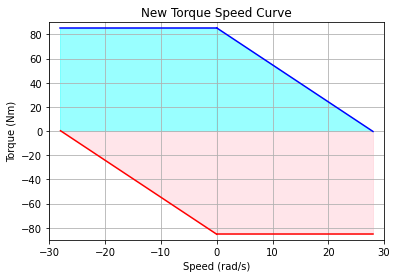

In [5]:
hide_sloution('Torque Speed Curve Display')

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, int(no_load_speed+1), num=int(no_load_speed+1))
x_n = np.linspace(-int(no_load_speed+1), 0, num=int(no_load_speed+1))

# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

m_grad = (rated_torque-0.0)/(speed_rated_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(peak_torque)
    rated_torque_n.append(-peak_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-30,30,-90,90))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [6]:
hide_sloution('Integration')
m = ConcreteModel('Biped_th0_Imotors')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.leg_links = Set(initialize = leg_links)
m.all_links_inertia = Set(initialize = all_links_inertia)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)

#FixedParams--------------------------
m.g = Param(initialize = 9.81)
m.BLD = Param(initialize = 60/1000)
m.foot_angle = Param(initialize = 135*(np.pi/180))
m.foot_length = Param(initialize = 42.5/1000)
m.cg = Param(initialize = 1.149)
m.lx_boom = Param(initialize = 2.575)
m.ly_boom = Param(initialize = 2.493)
m.y_boomOffset = Param(initialize = 0.101)
m.y_bodyOffset = Param(initialize = 8.36/1000)
m.x_footOffset = Param(initialize = 1.63/1000)
m.N_GR = Param(initialize = 9)


m.COMR = Param(m.leg_links, initialize = COMR_)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links_inertia, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_min,h_max)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/uct/anaconda3/envs/test-ipopt/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [7]:
hide_sloution('Connection Constraint')
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [8]:
hide_sloution('Ground Contact Constraints')
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [9]:
hide_sloution('Torque Speed Curve Constraint')
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-peak_torque,peak_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_TW_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.TW_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_right)

def def_TW_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.TW_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_left)



In [10]:
# hide_sloution('Limit Torque Difference')
# def def_max_change_torque(m,n,side,leg):
#     if n<(N-1):
#         return abs(m.tau_torque[n+1,side,leg] - m.tau_torque[n,side,leg]) <= tau_diff_lim
#     else:
#         return abs(m.tau_torque[n,side,leg] - m.tau_torque[n-1,side,leg]) <= tau_diff_lim
# m.max_change_torque = Constraint(m.N, m.sides, m.legs, rule = def_max_change_torque)

In [11]:
hide_sloution('Knee Angle Limit')
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,knee_angle_max*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_LL'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_LR'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [12]:
hide_sloution('Mark Periodic Constraints')
# Get the foot position in WDOF
# if test == "Periodic_Walk" or test == "Periodic_Hop":
    
#     lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
#     m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

#     # CONSTRAINTS
#     def def_body_position(m,n,wdof):
#         var_list = get_var_list_zeros(m,n)
#         if wdof == 'X':
#             return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
#         else: return Constraint.Skip
#     m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
#     if test == "Periodic_Walk":
        
# #         def def_hold_foot(m,n):
# #             return m.foot_position[1,'X','B'] - m.foot_position[N,'X','B'] == 0
# #         m.def_hold_foot_constraint = Constraint(m.N, rule = def_hold_foot)
# #         def def_foot_velocity(m,n,wdof,leg):
# #             if wdof == 'Y':
# #                 return m.foot_velocity[1,'Y','+ve',l]-m.foot_velocity[n,'Y','-ve',leg] == 0
# #             else: return Constraint.Skip
# #         m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)
    
    
#         # Average velocities
#         def def_body_position_average(m,wdof):
#             if wdof == 'X':
#                 return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
#             else: return Constraint.Skip
#         m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
#         # Equate states
#         def def_equate_position_states(m,n,dof_i):
            
#             if dof_i == 'y_body':
#                 return m.q[1,dof_i] == m.q[N,dof_i]
            
#             elif dof_i == 'theta_ULA':
#                 return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
#             elif dof_i == 'theta_ULB':
#                 return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
#             elif dof_i == 'theta_URA':
#                 return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
#             elif dof_i == 'theta_URB':
#                 return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
#             elif dof_i == 'theta_LLA':
#                 return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
#             elif dof_i == 'theta_LLB':
#                 return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
#             elif dof_i == 'theta_LRA':
#                 return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']

# #             elif dof_i == 'theta_ULA':
# #                 return m.q[1,'theta_ULA'] == m.q[N,'theta_ULA']
# #             elif dof_i == 'theta_ULB':
# #                 return m.q[1,'theta_ULB'] == m.q[N,'theta_ULB']
            
# #             elif dof_i == 'theta_URA':
# #                 return m.q[1,'theta_URA'] == m.q[N,'theta_URA']
# #             elif dof_i == 'theta_URB':
# #                 return m.q[1,'theta_URB'] == m.q[N,'theta_URB']
            
# #             elif dof_i == 'theta_LLA':
# #                 return m.q[1,'theta_LLA'] == m.q[N,'theta_LLA']
# #             elif dof_i == 'theta_LLB':
# #                 return m.q[1,'theta_LLB'] == m.q[N,'theta_LLB']
            
# #             elif dof_i == 'theta_LRA':
# #                 return m.q[1,'theta_LRA'] == m.q[N,'theta_LRA']
            
# #             elif dof_i == 'theta_LRB':
# #                 return m.q[1,'theta_LRB'] == m.q[N,'theta_LRB']
#             else: 
#                  return Constraint.Skip
#         m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
#         def def_equate_vel_states(m,n,dof_i):
#             return m.dq[1,dof_i] == m.dq[N,dof_i]
#         m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
#         # Condition where the GRF can't increase twice from zero          
    
    
#     else: 
        
#         def def_equate_position_states(m,n,dof_i):
#             return m.q[1,dof_i] == m.q[N,dof_i]
#         m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
#         def def_equate_vel_states(m,n,dof_i):
#             return m.dq[1,dof_i] == m.dq[N,dof_i]
#         m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

# else: pass
                                    


In [13]:
hide_sloution('Periodic Constraints')
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Walk":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ULA':
                return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
            elif dof_i == 'theta_ULB':
                return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
            elif dof_i == 'theta_URA':
                return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
            elif dof_i == 'theta_URB':
                return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
            elif dof_i == 'theta_LLA':
                return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
            elif dof_i == 'theta_LLB':
                return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
            elif dof_i == 'theta_LRA':
                return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']
#             elif dof_i == 'theta_LRB':
#                 return m.q[1,'theta_LRB'] == m.q[N,'theta_LRA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
        # Condition where the GRF can't increase twice from zero          
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [14]:
#test code
hide_sloution('Initial Conditions')
sign_symbols = ['+','-']
boundaries = ['setub','setlb']

for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_UL\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_LL\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_UR\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_LR\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))


# for n in range(1,N+1):    
    if test == 'High_Drop' or test == 'Low_Drop':
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    else:
        x_low_lim = -1.0
        x_high_lim = 2.0
        y_low_lim = -0.5
        y_high_lim = 1.5
        
        if test == 'Periodic_Walk' or test == 'Periodic_Walk_Stop':
            pass
        else:
            # test == 'Start_Periodic_Walk'
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        

In [15]:
if test == 'High_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)


    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Low_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(0.5)
    
    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Periodic_Walk':
    # Approach: begin and end in stance
    guide = np.linspace(0,TT*V_avg,N)
    
    m.q[1,'x_body'].setlb(-1.0)
    m.q[1,'x_body'].setub(1.0)
    m.foot_position[1,'Y','A'].fix(0.00)
    m.foot_position[1,'Y','B'].fix(0.00)
    m.foot_position[int(N/2),'Y','A'].setlb(0.05)
    
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
        # Added on
        m.foot_position[n,'Y','B'].fix(0.00)
        if n<int(N/2)-int(N*0.3) or n>int(N/2)+int(N*0.3):
            m.foot_position[n,'Y','A'].fix(0.00)
            
    def def_zero_velocityA(m,n):
        if n==1:
            return m.foot_velocity[n,'X','+ve','A']-m.foot_velocity[n,'X','-ve','A'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocityA_constraint = Constraint(m.N, rule = def_zero_velocityA)
    
    def def_zero_velocityB(m,n):
        if n>0:
            return m.foot_velocity[n,'X','+ve','B']-m.foot_velocity[n,'X','-ve','B'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocityB_constraint = Constraint(m.N, rule = def_zero_velocityB)
    
    def def_zero_velocity_end(m,n):
        if n>int(N/2)+int(N*0.3):
            return m.foot_velocity[n,'X','+ve','A']-m.foot_velocity[n,'X','-ve','A'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocity_end_constraint = Constraint(m.N, rule = def_zero_velocity_end)
            
else:
    pass

In [16]:
hide_sloution('Worked Solutions')

#     def def_mirror_foot(m,n):
#         if n>1 and n<int(N/2)-int(0.3*N):
#             return m.foot_position[n,'Y','B'] - m.foot_position[N-n,'Y','A'] <=0.01
#         else: return Constraint.Skip
#     m.def_mirror_foot_constraint = Constraint(m.N, rule = def_mirror_foot)



# elif test == "Periodic_Walk":
# #     # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# #     guide = np.linspace(0,TT*V_avg,N)
# #     for n in range(1,N+1):
# #         m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25) 
# #     def def_hold_xposition(m,n):
# #         # maintain x-foot position up to 0.01m
# #         if n < int(N/4):
# #             return  m.foot_position[n+1, 'X', 'B'] - m.foot_position[n, 'X', 'B'] <= 0.01
# #         else:
# #             return Constraint.Skip
# #     m.def_hold_xposition_constraint = Constraint(m.N,rule = def_hold_xposition)

# #     m.q[1,'x_body'].fix(0.0) # initial condition


#     m.GRF_y[n,'A'].fix(0.0)
#     for n in range (1,int(N/4)):
#         m.foot_position[n,'X','B'].fix(0.0)
            
    
# #     for n in range(1,N+1):
# #         m.foot_position[n, 'Y', 'A'].setub(max_foot_height)
# #         m.foot_position[n, 'Y', 'B'].setub(max_foot_height)
        
# #         if n < int(N/4):   
# #             m.foot_position[n,'X','B'].fix(0.0)
# #             m.GRF_y[n,'A'].fix(0.0)


#         m.q[n,'y_body'].setlb(0.3)
        
#         if n < (int(N/2)):
#             m.GRF_y[n,'B'].setlb(50)
#             m.GRF_y[n,'A'].fix(0.0)
#             m.foot_position[n,'X','B'].fix(0.0)        
#         else:
#             pass
    
    
#     guide = np.linspace(0,TT*V_avg,N)
#     m.foot_position[1,'X','A'].fix(0.00)
#     m.foot_position[1,'Y','A'].setlb(0.05)
    
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
        
#         if n < (int(N/2)+5):
#             m.GRF_y[n,'B'].setlb(50)
#             m.GRF_y[n,'A'].fix(0.0)
#             m.foot_position[n,'X','B'].fix(0.0)        
# #         elif n > (int(N/2)+5) and n < (int(N/2)+10):
# #             m.foot_position[n,'Y','B'].setlb(0.01)
# #             m.foot_position[n,'Y','B'].setub(0.03)
            
#         elif n > (int(N/2)-5):
#             m.GRF_y[n,'A'].setlb(50)
#         elif n < (int(N/2)-5) and n > (int(N/2)-10):
#             m.foot_position[n,'Y','A'].setlb(0.01)
#             m.foot_position[n,'Y','A'].setub(0.03)

#         else:
#             pass

In [17]:
hide_sloution('Mark Periodic Conditions')

# elif test == 'Start_Periodic_Walk':
#     #init conditions
#     #match mid walk node1 conditions
#     with open('periodic_walk_N1_data_v10.pkl','rb') as f:
#         start_data = pickle.load(f)
    
# #     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'y_body'].setub(0.5)
#         m.q[n,'x_body'].setub(1.0)
#         m.q[n,'x_body'].setlb(0.0)
# #         m.foot_position[n,'X','A'].setlb(0.0)
# #         m.foot_position[n,'X','B'].setlb(0.0)
# #         m.foot_position[n,'Y','A'].setub(0.06)
# #         m.foot_position[n,'Y','B'].setub(0.06)

# #         m.q[n,'x_body'].setub(1.0)
# #         m.q[n,'x_body'].value = guide[n-1]
        
#     m.q[1,'x_body'].fix(0.0)

    
#     m.foot_position[1,'X','A'].fix(0.0)
#     m.foot_position[1,'X','B'].fix(0.0)
#     m.foot_position[1,'Y','A'].fix(0.0)
#     m.foot_position[1,'Y','B'].fix(0.0)
    
# #     m.foot_position[N/2,'Y','A'].fix(0.0)
# #     m.foot_position[N/2,'Y','B'].fix(0.0)
    
# #     m.foot_position[N,'Y','B'].fix(0.0)
    
# #     for n in range(1,N+1):
# #         if n<(N/2):
# # #             m.foot_position[n,'Y','B'].fix(0.0)
# # #             m.foot_position[n,'X','B'].fix(0.0)
# # #             m.GRF_y[n,'B'].fix(0.0)
# #             m.GRF_y[n,'A'].setlb(0.1)
# # # #             m.foot_position[n,'X','A'].fix(0.0)
    
# #             if n>1:
# #                 m.GRF_y[n,'B'].fix(0.0)

# #         elif n>(N/2):
# #             m.GRF_y[n,'A'].fix(0.0)
# #             m.foot_position[n,'Y','B'].fix(0.0)
# #             if n>(N-10):
# #                 m.foot_position[n,'Y','A'].setlb(0.02)

    
#     m.q[N,'y_body'].fix(start_data['ybod'])
#     m.dq[N,'y_body'].fix(start_data['dybod'])
#     m.dq[N,'x_body'].fix(start_data['dxbod'])
    
#     m.q[N,'theta_ULA'].fix(start_data['thULA'])
#     m.q[N,'theta_LLA'].fix(start_data['thLLA'])
#     m.q[N,'theta_URA'].fix(start_data['thURA'])
#     m.q[N,'theta_LRA'].fix(start_data['thLRA'])
    
#     m.q[N,'theta_ULB'].fix(start_data['thULB'])
#     m.q[N,'theta_LLB'].fix(start_data['thLLB'])
#     m.q[N,'theta_URB'].fix(start_data['thURB'])
#     m.q[N,'theta_LRB'].fix(start_data['thLRB'])
    
#     m.dq[N,'theta_ULA'].fix(start_data['dthULA'])
#     m.dq[N,'theta_LLA'].fix(start_data['dthLLA'])
#     m.dq[N,'theta_URA'].fix(start_data['dthURA'])
#     m.dq[N,'theta_LRA'].fix(start_data['dthLRA'])
    
#     m.dq[N,'theta_ULB'].fix(start_data['dthULB'])
#     m.dq[N,'theta_LLB'].fix(start_data['dthLLB'])
#     m.dq[N,'theta_URB'].fix(start_data['dthURB'])
#     m.dq[N,'theta_LRB'].fix(start_data['dthLRB'])
    
    

# elif test == 'Periodic_Walk':
#     guide = np.linspace(0,TT*V_avg,N)

#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
#         m.q[n,'y_body'].setub(0.42)

#     m.foot_position[1,'Y','B'].fix(0.0)
    
#     m.q[1,'x_body'].fix(0.0)


    
#     m.foot_position[N/2,'Y','A'].fix(0.0)
#     m.foot_position[N/2,'Y','B'].fix(0.0)
    
#     for n in range(1,N+1):
#         if n<(N/2):
#             m.GRF_y[n,'A'].fix(0.0)
#             m.GRF_y[n,'B'].setlb(1)
#             m.foot_position[n,'X','B'].fix(0.0)
            
#             if n<(N/2 - 5):
#                 m.foot_position[n,'Y','A'].setlb(0.04)
#                 m.foot_position[n,'Y','A'].setub(0.06)
                
#         elif n>(N/2):
#             m.GRF_y[n,'B'].fix(0.0)
#             m.GRF_y[n,'A'].setlb(1)
            
#             if n>(N/2 + 15):
#                 m.foot_position[n,'Y','B'].setlb(0.04)
#                 m.foot_position[n,'Y','B'].setub(0.06)
                

#         else:
#             pass
            
#     m.foot_position[N,'Y','A'].fix(0.0)
    

    
# elif test == 'Periodic_Walk_Stop':
    
#     with open('periodic_walk_mid_v1.pkl','rb') as f:
#         start_data = pickle.load(f)
    
#     m.q[1,'y_body'].fix(start_data['ybod'])
#     m.dq[1,'x_body'].fix(start_data['dxbod'])
    
#     m.dq[1,'theta_ULA'].fix(start_data['dthULA'])
#     m.dq[1,'theta_LLA'].fix(start_data['dthLLA'])
#     m.dq[1,'theta_URA'].fix(start_data['dthURA'])
#     m.dq[1,'theta_LRA'].fix(start_data['dthLRA'])
    
#     m.dq[1,'theta_ULB'].fix(start_data['dthULB'])
#     m.dq[1,'theta_LLB'].fix(start_data['dthLLB'])
#     m.dq[1,'theta_URB'].fix(start_data['dthURB'])
#     m.dq[1,'theta_LRB'].fix(start_data['dthLRB'])
    
#     m.q[1,'x_body'].fix(0.0) # initial condition

# #     m.q[1,'y_body'].fix(body_height)
    

# #     m.dq[1,'y_body'].fix(0.0)

#     m.foot_position[1,'X','A'].fix(0.0-(stride_length/2))
#     m.foot_position[1,'X','B'].fix(0.0+(stride_length/2))
#     m.foot_position[1,'Y','A'].fix(0.0)
#     m.foot_position[1,'Y','B'].fix(0.0)
# #     m.q[1,'y_body'].fix(body_height)
    
#     for n in range(1,N+1):
#         m.foot_position[n,'X','B'].fix(stride_length/2)
#         m.foot_position[n,'Y','B'].fix(0.0)
    
#     for n5 in range(N-5,N+1): # last 5 nodes 
#         for dof_i in DOFs:
#             if dof_i == 'x_body':
#                 m.dq[n5,dof_i].setub(0.0)
#             else:
#                 pass
# #                 m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
#         m.foot_position[n5, 'Y', 'A'].fix(0.0)
#         m.foot_position[n5, 'Y', 'B'].fix(0.0)
        
#     m.q[N,'x_body'].fix(stride_length/2)
# #     m.q[N,'y_body'].fix(body_height)

    
#     m.dq[N,'x_body'].fix(0.0)
#     m.dq[N,'y_body'].fix(0.0)

    
#     m.dq[N,'theta_ULA'].fix(0.0)
#     m.dq[N,'theta_URA'].fix(0.0)
#     m.dq[N,'theta_LLA'].fix(0.0)
#     m.dq[N,'theta_LRA'].fix(0.0)
    
#     m.dq[N,'theta_ULB'].fix(0.0)
#     m.dq[N,'theta_URB'].fix(0.0)
#     m.dq[N,'theta_LLB'].fix(0.0)
#     m.dq[N,'theta_LRB'].fix(0.0)
    
    
    
#     m.foot_position[N,'X','A'].fix(stride_length/2)
#     m.foot_position[N,'X','B'].fix(stride_length/2)
    
    
    
# #     m.foot_position[N,'X','A'].fix(0.75)
# #     m.foot_position[N,'X','B'].fix(0.25)
    
# else:
#     pass


In [18]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 #row = 1e3 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    tau_diff = 0.0
    foot_diff = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            if n<N:
                foot_diff += (m.foot_position[n+1,'Y',leg] - m.foot_position[n,'Y',leg])**2
            for side in sides:
                tau_sum += (m.tau_torque[n,side,leg])**2 # m.h[n]*(m.tau_torque[n,side,leg])**2
                #tau_diff = sum(diff(m.tau_torque[n,side,leg]))
                if n<N:
                    tau_diff += (m.tau_torque[n+1,side,leg])**2 - m.tau_torque[n,side,leg]**2
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    return row*pen_sum + tau_sum + tau_diff  #return row*pen_sum + tau_sum/10 #+ tau_diff
m.Cost = Objective(rule = CostFun)

In [19]:
hide_sloution('Lambdify EOMs')

''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_ULA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULA'](*var_list) == 0
m.EOM_th_ULA_constraint = Constraint(m.N, rule = EOM_th_ULA)

def EOM_th_LLA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLA'](*var_list) == 0
m.EOM_th_LLA_constraint = Constraint(m.N, rule = EOM_th_LLA)

def EOM_th_URA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URA'](*var_list) == 0
m.EOM_th_URA_constraint = Constraint(m.N, rule = EOM_th_URA)

def EOM_th_LRA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRA'](*var_list) == 0
m.EOM_th_LRA_constraint = Constraint(m.N, rule = EOM_th_LRA)

def EOM_th_ULB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULB'](*var_list) == 0
m.EOM_th_ULB_constraint = Constraint(m.N, rule = EOM_th_ULB)

def EOM_th_LLB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLB'](*var_list) == 0
m.EOM_th_LLB_constraint = Constraint(m.N, rule = EOM_th_LLB)

def EOM_th_URB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URB'](*var_list) == 0
m.EOM_th_URB_constraint = Constraint(m.N, rule = EOM_th_URB)

def EOM_th_LRB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRB'](*var_list) == 0
m.EOM_th_LRB_constraint = Constraint(m.N, rule = EOM_th_LRB)

In [20]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
bambi = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt'
lenovo = '/home/zubair/build/bin/ipopt'
opt = SolverFactory(bambi)
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*20   # maximum number of iterations
opt.options["max_cpu_time"] = 600*20 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=600000
max_cpu_time=12000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    18201
Number of nonzeros in inequality constraint Jacobian.:     1952
Number of nonzeros in Lagrangian Hessian.............:    11064

Total number of variables............................:     3925
                     variables with only lower bounds:      331
                variables with lower and upper bounds:     1945
                     variables with only 

 118r 8.5762964e+06 1.84e+00 2.70e+02  -1.2 1.07e+00   1.0 5.96e-01 1.69e-01f  1
 119r 8.5834090e+06 1.84e+00 2.70e+02  -1.2 1.61e+02   0.5 5.10e-03 7.71e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 8.5624840e+06 1.84e+00 1.93e+02  -1.2 3.47e+00   0.9 2.56e-01 3.02e-01f  1
 121r 8.5572288e+06 1.84e+00 1.65e+02  -1.2 1.54e+00   1.4 4.72e-01 1.85e-01f  1
 122r 8.5461733e+06 1.83e+00 4.88e+01  -1.2 4.76e-01   1.8 1.00e+00 8.98e-01f  1
 123r 8.5488901e+06 1.83e+00 5.00e+02  -1.2 2.04e+01   1.3 3.79e-02 8.77e-02f  1
 124r 8.5482531e+06 1.83e+00 6.34e+02  -1.2 2.09e-01   2.6 1.00e+00 3.83e-01f  1
 125r 8.5435136e+06 1.83e+00 3.24e+02  -1.2 9.60e-01   2.2 5.80e-01 1.00e+00f  1
 126r 8.5431369e+06 1.83e+00 9.57e+02  -1.2 4.69e-01   2.6 1.00e+00 2.12e-01f  1
 127r 8.5428528e+06 1.83e+00 1.36e+03  -1.2 4.34e+00   2.1 1.53e-01 3.88e-02f  1
 128r 8.5420833e+06 1.83e+00 6.63e+02  -1.2 6.93e-01   2.5 1.00e+00 3.47e-01f  1
 129r 8.5417246e+06 1.83e+00

 255r 7.9890325e+06 1.65e+00 1.80e+02  -1.2 9.46e-01   1.5 6.76e-01 5.63e-01f  1
 256r 7.9869964e+06 1.65e+00 3.45e+01  -1.2 3.67e-01   2.0 1.00e+00 1.00e+00f  1
 257r 7.9862460e+06 1.65e+00 2.18e+02  -1.2 2.34e+00   1.5 3.37e-01 6.91e-01f  1
 258r 7.9858593e+06 1.64e+00 3.06e+02  -1.2 1.35e+00   1.9 8.82e-01 4.86e-01f  1
 259r 7.9852037e+06 1.64e+00 1.01e+02  -1.2 4.69e-01   2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 7.9843402e+06 1.64e+00 5.86e+02  -1.2 4.43e+00   1.9 3.38e-01 1.14e-01f  1
 261r 7.9832584e+06 1.64e+00 2.41e+02  -1.2 9.29e-01   2.3 1.15e-01 5.45e-01f  1
 262r 7.9832424e+06 1.64e+00 2.44e+02  -1.2 2.44e+01   1.8 2.61e-03 3.20e-04f  1
 263r 7.9828036e+06 1.64e+00 2.22e+02  -1.2 9.88e-01   1.3 8.59e-02 2.85e-02f  1
 264r 7.9841761e+06 1.64e+00 2.06e+02  -1.2 2.35e+01   0.9 5.51e-02 5.05e-02f  1
 265r 7.9828239e+06 1.64e+00 3.77e+02  -1.2 2.66e+00   1.3 2.32e-01 1.12e-01f  1
 266r 7.9788866e+06 1.64e+00

 393r 7.9282035e+06 1.50e+00 2.42e+02  -1.2 4.35e+01   1.6 2.48e-02 3.93e-04f  1
 394r 7.9283651e+06 1.50e+00 6.76e+02  -1.2 1.65e+00   1.2 6.55e-01 1.35e-02f  1
 395r 7.9346554e+06 1.49e+00 5.81e+02  -1.2 4.50e+00   0.7 9.96e-02 1.35e-01f  1
 396r 7.9461809e+06 1.49e+00 5.65e+02  -1.2 2.28e+01   0.2 5.65e-02 3.32e-02f  1
 397r 7.9592611e+06 1.49e+00 4.60e+02  -1.2 4.42e+00   0.6 1.55e-01 1.79e-01f  1
 398r 7.9662804e+06 1.49e+00 4.73e+02  -1.2 2.72e+01   0.1 9.50e-02 1.06e-02f  1
 399r 7.9939885e+06 1.48e+00 3.65e+02  -1.2 4.55e+00   0.6 9.02e-03 1.69e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r 8.0170402e+06 1.47e+00 1.88e+02  -1.2 1.51e+00   1.0 2.46e-01 4.03e-01f  1
 401r 8.0316180e+06 1.47e+00 1.80e+02  -1.2 1.14e+01   0.5 9.42e-03 2.16e-02f  1
 402r 8.0378532e+06 1.47e+00 3.08e+02  -1.2 1.55e+00   0.9 6.93e-01 7.33e-02f  1
 403r 8.0465180e+06 1.47e+00 3.01e+02  -1.2 5.81e-01   1.4 4.45e-01 2.58e-01f  1
 404r 8.0504719e+06 1.47e+00

 531r 7.6614201e+06 8.53e-01 3.06e+02  -1.2 2.83e+01  -0.1 4.05e-02 2.71e-02f  1
 532r 7.6522694e+06 8.49e-01 2.89e+02  -1.2 8.11e+00   0.3 2.18e-02 5.01e-02f  1
 533r 7.6367976e+06 8.17e-01 2.84e+02  -1.2 2.18e+02  -0.1 2.53e-02 2.05e-02f  1
 534r 7.6209397e+06 8.15e-01 3.33e+02  -1.2 1.85e+01   0.3 2.56e-02 7.64e-02f  1
 535r 7.6183171e+06 8.15e-01 5.76e+02  -1.2 3.96e+00   0.7 1.78e-01 3.73e-02f  1
 536r 7.6118882e+06 8.14e-01 4.00e+02  -1.2 1.22e+00   1.1 2.62e-01 2.76e-01f  1
 537r 7.6019160e+06 8.13e-01 3.43e+02  -1.2 5.57e+00   0.7 1.46e-01 1.25e-01f  1
 538r 7.5955866e+06 8.12e-01 2.37e+02  -1.2 1.62e+00   1.1 3.19e-01 2.25e-01f  1
 539r 7.5921554e+06 8.11e-01 3.58e+02  -1.2 9.88e+00   0.6 1.17e-01 3.73e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r 7.5876458e+06 8.10e-01 4.51e+02  -1.2 1.48e+01   0.1 4.87e-02 1.40e-02f  1
 541r 7.5687464e+06 8.10e-01 4.34e+02  -1.2 3.03e+02  -0.3 4.70e-03 8.02e-03f  1
 542r 7.5668725e+06 8.09e-01

 669r 7.0247028e+06 5.81e-01 3.51e+02  -1.2 2.99e+00  -0.0 2.79e-02 7.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r 7.0201167e+06 5.81e-01 3.35e+02  -1.2 1.17e+01  -0.5 3.19e-02 2.84e-02f  1
 671r 7.0178616e+06 5.80e-01 3.18e+02  -1.2 2.97e+00  -0.1 4.45e-02 4.25e-02f  1
 672r 7.0115849e+06 5.80e-01 3.22e+02  -1.2 2.51e+01  -0.5 9.94e-03 2.64e-02f  1
 673r 7.0104022e+06 5.80e-01 2.84e+02  -1.2 4.15e+00  -0.1 4.70e-02 2.09e-02f  1
 674r 7.0061168e+06 5.79e-01 3.03e+02  -1.2 1.49e+01  -0.6 7.74e-03 2.86e-02f  1
 675r 7.0051335e+06 5.79e-01 2.50e+02  -1.2 4.46e+00  -0.2 6.24e-02 1.49e-02f  1
 676r 6.9986721e+06 5.78e-01 2.55e+02  -1.2 1.64e+01  -0.6 1.41e-02 3.22e-02f  1
 677r 6.9964103e+06 5.77e-01 2.63e+02  -1.2 4.83e+00  -0.2 1.46e-02 3.04e-02f  1
 678r 6.9951941e+06 5.77e-01 2.85e+02  -1.2 2.13e+00   0.2 4.48e-02 5.62e-02f  1
 679r 6.9928906e+06 5.76e-01 2.96e+02  -1.2 5.95e+00  -0.3 1.69e-02 2.60e-02f  1
iter    objective    inf_pr 

 761r 6.9372044e+06 5.23e-01 8.16e+02  -1.2 1.39e+00   1.2 2.80e-01 4.74e-01f  1
 762r 6.9373692e+06 5.28e-01 9.23e+02  -1.2 4.98e+00   0.8 3.87e-01 1.85e-02f  1
 763r 6.9401452e+06 5.17e-01 9.66e+02  -1.2 5.44e+01   0.3 3.30e-02 7.44e-02f  1
 764r 6.9402177e+06 5.17e-01 1.20e+03  -1.2 7.26e+00   0.7 2.21e-01 6.81e-03f  1
 765r 6.9436214e+06 5.03e-01 1.13e+03  -1.2 9.50e+00   0.2 1.77e-02 7.92e-02f  1
 766r 6.9456975e+06 4.92e-01 9.47e+02  -1.2 2.60e+00   0.7 1.49e-01 1.63e-01f  1
 767r 6.9481190e+06 4.82e-01 9.09e+02  -1.2 2.47e+01   0.2 3.70e-02 4.01e-02f  1
 768r 6.9494543e+06 4.75e-01 8.34e+02  -1.2 3.53e+00   0.6 6.75e-02 8.23e-02f  1
 769r 6.9506565e+06 4.68e-01 6.48e+02  -1.2 1.08e+00   1.0 2.60e-01 2.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770r 6.9535631e+06 4.54e-01 5.54e+02  -1.2 4.81e+00   0.6 1.59e-01 1.46e-01f  1
 771r 6.9545035e+06 4.49e-01 4.75e+02  -1.2 1.43e+00   1.0 2.78e-01 1.38e-01f  1
 772r 6.9583234e+06 4.33e-01

 899r 3.9285500e+06 4.99e-02 6.06e+02  -2.8 5.96e+01    -  4.54e-02 1.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r 3.6797212e+06 4.99e-02 2.95e+02  -2.8 1.48e+00  -1.5 4.78e-01 5.38e-01f  1
 901r 3.6665044e+06 4.99e-02 2.91e+02  -2.8 1.71e+01  -2.0 1.12e-01 1.64e-02f  1
 902r 3.6377537e+06 4.99e-02 4.42e+02  -2.8 3.80e+01    -  2.60e-01 1.07e-01f  1
 903r 3.6001514e+06 4.99e-02 6.18e+02  -2.8 3.40e+01    -  3.44e-01 1.87e-01f  1
 904r 3.5676835e+06 4.99e-02 5.46e+02  -2.8 2.72e+01    -  4.12e-01 2.14e-01f  1
 905r 3.5327837e+06 4.99e-02 8.25e+02  -2.8 2.10e+01    -  1.00e+00 2.85e-01f  1
 906r 3.5183369e+06 4.99e-02 1.41e+03  -2.8 1.68e+01    -  5.04e-01 1.32e-01f  1
 907r 3.4899105e+06 4.99e-02 1.09e+03  -2.8 1.34e+01    -  2.26e-01 2.86e-01f  1
 908r 3.4377994e+06 4.99e-02 7.83e+02  -2.8 9.50e+00    -  3.11e-01 6.48e-01f  1
 909r 3.4047408e+06 4.99e-02 8.98e+01  -2.8 4.20e+00    -  8.75e-01 1.00e+00f  1
iter    objective    inf_pr 

1037r 7.1398575e+06 4.95e-02 4.39e+02  -6.3 2.54e+01  -3.1 2.28e-02 4.11e-03f  1
1038r 7.1609885e+06 4.95e-02 3.72e+02  -6.3 8.20e+00  -2.7 4.49e-02 7.25e-02f  1
1039r 7.1768149e+06 4.95e-02 3.63e+02  -6.3 2.94e+01  -3.1 7.47e-03 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r 7.1851600e+06 4.95e-02 3.44e+02  -6.3 9.08e+00  -2.7 1.23e-02 2.51e-02f  1
1041r 7.1983317e+06 4.95e-02 3.44e+02  -6.3 3.85e+01  -3.2 8.86e-03 6.67e-03f  1
1042r 7.1989932e+06 4.95e-02 5.49e+02  -6.3 1.03e+01  -2.8 4.59e-01 1.72e-03h  1
1043r 7.2366168e+06 4.95e-02 5.95e+02  -6.3 5.21e+01  -3.2 3.02e-02 1.50e-02f  1
1044r 7.2503974e+06 4.95e-02 5.86e+02  -6.3 1.20e+01  -2.8 4.27e-02 3.05e-02f  1
1045r 7.2785013e+06 4.95e-02 5.61e+02  -6.3 8.90e+01  -3.3 2.18e-03 6.80e-03f  1
1046r 7.2803319e+06 4.95e-02 6.10e+02  -6.3 1.39e+01  -2.9 6.50e-02 3.45e-03f  1
1047r 7.3383439e+06 4.95e-02 5.89e+02  -6.3 2.26e+02  -3.3 3.43e-03 6.31e-03f  1
1048r 7.3416519e+06 4.95e-02

1175r 8.1509215e+06 4.92e-02 5.43e+02  -6.3 2.29e+00  -2.1 2.69e-01 1.11e-03h  1
1176r 8.1585617e+06 4.92e-02 6.18e+02  -6.3 7.45e+00  -2.6 1.10e-01 5.97e-02f  1
1177r 8.1581313e+06 4.92e-02 8.41e+02  -6.3 2.58e+00  -2.1 4.19e-01 1.32e-01h  1
1178r 8.1748266e+06 4.92e-02 6.25e+02  -6.3 1.13e+01  -2.6 1.85e-02 6.79e-02f  1
1179r 8.1751224e+06 4.92e-02 9.02e+02  -6.3 2.85e+00  -2.2 3.43e-01 3.70e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180r 8.2210565e+06 4.92e-02 3.88e+02  -6.3 1.96e+01  -2.7 3.44e-03 8.41e-02f  1
1181r 8.2218572e+06 4.92e-02 3.81e+02  -6.3 3.16e+00  -2.3 1.83e-02 1.86e-02h  1
1182r 8.2225646e+06 4.92e-02 3.90e+02  -6.3 4.87e+01  -2.7 3.02e-03 4.11e-04h  1
1183r 8.2252308e+06 4.92e-02 4.34e+02  -6.3 3.58e+00  -2.3 8.24e-02 5.17e-02f  1
1184r 8.2410465e+06 4.92e-02 4.76e+02  -6.3 3.13e+02  -2.8 8.43e-04 1.29e-03f  1
1185r 8.2434151e+06 4.92e-02 5.43e+02  -6.3 4.05e+00  -2.4 2.98e-02 7.55e-02f  1
1186r 8.2353888e+06 4.92e-02

1312r 7.2364560e+06 4.81e-02 7.80e+02  -6.3 5.26e+00  -2.4 5.86e-03 1.97e-02f  1
1313r 7.2351346e+06 4.81e-02 1.16e+03  -6.3 1.85e+00  -2.0 5.60e-02 1.65e-02h  1
1314r 7.2341477e+06 4.81e-02 1.15e+03  -6.3 6.26e+00  -2.5 4.34e-03 5.16e-03f  1
1315r 7.2251707e+06 4.81e-02 7.27e+02  -6.3 2.11e+00  -2.1 4.82e-02 1.02e-01f  1
1316r 7.2230587e+06 4.81e-02 6.36e+02  -6.3 7.28e+00  -2.5 4.14e-03 1.01e-02f  1
1317r 7.2137835e+06 4.81e-02 5.74e+02  -6.3 2.39e+00  -2.1 9.53e-02 9.71e-02f  1
1318r 7.2117258e+06 4.81e-02 5.62e+02  -6.3 1.17e+01  -2.6 7.63e-03 1.16e-02f  1
1319r 7.2034433e+06 4.80e-02 5.17e+02  -6.3 2.71e+00  -2.2 1.23e-01 7.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320r 7.1932066e+06 4.80e-02 3.92e+02  -6.3 9.83e-01  -1.7 2.38e-01 2.43e-01f  1
1321r 7.1675700e+06 4.80e-02 3.16e+02  -6.3 3.05e+00  -2.2 2.72e-02 2.40e-01f  1
1322r 7.1582016e+06 4.79e-02 2.53e+02  -6.3 1.15e+00  -1.8 1.57e-01 2.08e-01f  1
1323r 7.1485625e+06 4.79e-02

1405r 6.8914337e+06 4.66e-02 9.42e+02  -6.3 7.81e+00  -2.6 3.56e-02 2.32e-03f  1
1406r 6.8908000e+06 4.65e-02 9.35e+02  -6.3 2.82e+00  -2.1 5.76e-03 8.99e-03f  1
1407r 6.8904587e+06 4.65e-02 1.22e+03  -6.3 8.92e+00  -2.6 2.36e-02 2.04e-03f  1
1408r 6.8859069e+06 4.65e-02 1.05e+03  -6.3 3.20e+00  -2.2 4.46e-02 5.78e-02f  1
1409r 6.8844140e+06 4.65e-02 1.00e+03  -6.3 1.03e+01  -2.7 5.67e-03 8.12e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410r 6.8830582e+06 4.65e-02 1.09e+03  -6.3 3.64e+00  -2.2 7.77e-02 1.50e-02f  1
1411r 6.8806545e+06 4.65e-02 1.00e+03  -6.3 1.18e+01  -2.7 4.09e-03 1.28e-02f  1
1412r 6.8797161e+06 4.65e-02 1.01e+03  -6.3 4.14e+00  -2.3 2.35e-02 1.01e-02f  1
1413r 6.8797429e+06 4.65e-02 1.01e+03  -6.3 2.30e+01  -2.8 8.86e-04 5.53e-04f  1
1414r 6.8783078e+06 4.64e-02 9.44e+02  -6.3 4.67e+00  -2.3 2.91e-02 1.39e-02f  1
1415r 6.8778069e+06 4.64e-02 9.45e+02  -6.3 1.71e+01  -2.8 4.78e-03 5.71e-03f  1
1416r 6.8745034e+06 4.64e-02

1499  1.7084783e+05 8.10e-01 1.42e+04  -1.0 5.25e+02  -2.8 2.11e-02 1.96e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.4594736e+05 7.54e-01 1.34e+04  -1.0 2.95e+02  -3.2 2.07e-02 6.16e-02f  1
1501  1.4267015e+05 7.34e-01 1.29e+04  -1.0 1.88e+02  -2.8 1.27e-01 2.50e-02f  1
1502  1.3829200e+05 6.74e-01 1.19e+04  -1.0 3.07e+02  -3.3 7.04e-02 7.64e-02f  1
1503  1.3673590e+05 6.19e-01 1.10e+04  -1.0 1.63e+02  -2.9 6.03e-02 7.90e-02f  1
1504  1.3591009e+05 5.79e-01 1.44e+04  -1.0 1.24e+02  -2.4 3.61e-01 6.31e-02f  1
1505  1.3412648e+05 5.00e-01 1.33e+04  -1.0 3.15e+02  -2.9 9.51e-03 1.24e-01f  1
1506  1.3411438e+05 4.99e-01 2.50e+04  -1.0 4.02e+01  -1.6 1.35e-01 2.52e-03h  1
1507  1.3257168e+05 4.47e-01 2.09e+04  -1.0 5.97e+01  -2.1 5.16e-03 9.72e-02f  1
1508  1.3240669e+05 4.42e-01 2.36e+04  -1.0 4.36e+01  -1.6 4.89e-02 1.01e-02h  1
1509  1.3250615e+05 4.29e-01 2.24e+04  -1.0 3.40e+01  -1.2 2.60e-02 2.93e-02h  1
iter    objective    inf_pr 

1591  2.5479356e+04 1.09e-04 7.00e+02  -3.8 7.89e-01   0.3 1.00e+00 1.74e-01f  1
1592  2.5462922e+04 1.09e-04 8.16e+02  -3.8 2.27e+00  -0.2 3.17e-01 1.28e-01f  1
1593  2.5454372e+04 1.10e-04 6.58e+02  -3.8 8.65e-01   0.3 5.12e-02 1.74e-01f  1
1594  2.5454126e+04 1.10e-04 6.57e+02  -3.8 3.58e+00  -0.2 2.16e-04 1.25e-03f  1
1595  2.5454126e+04 1.10e-04 6.57e+02  -3.8 7.84e+00   0.2 1.79e-07 7.92e-06f  2
1596  2.5453030e+04 1.10e-04 4.18e+02  -3.8 4.69e-02   1.5 1.53e-03 3.04e-01f  1
1597  2.5452790e+04 1.10e-04 1.53e+02  -3.8 1.78e-02   2.0 1.11e-01 5.02e-01f  1
1598  2.5451240e+04 1.10e-04 2.24e+02  -3.8 5.40e-02   1.5 1.00e+00 5.00e-01f  1
1599  2.5445748e+04 1.10e-04 1.40e+02  -3.8 1.63e-01   1.0 2.31e-01 7.53e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.5445407e+04 1.10e-04 1.40e+02  -3.8 4.90e-01   0.5 7.48e-03 1.66e-02f  1
1601  2.5443321e+04 1.10e-04 1.27e+02  -3.8 1.44e+00   0.1 3.20e-02 4.49e-02f  1
1602  2.5435162e+04 1.11e-04

1685  2.5853758e+04 1.07e-04 1.57e+03  -3.8 4.42e+00  -0.3 1.74e-01 2.34e-03h  8
1686  2.5899134e+04 1.07e-04 4.50e+02  -3.8 2.21e-01   1.0 3.99e-01 1.00e+00H  1
1687  2.5902601e+04 1.07e-04 5.40e+02  -3.8 6.84e-01   0.6 1.63e-01 2.55e-02h  5
1688  2.5904398e+04 1.07e-04 1.00e+03  -3.8 2.00e+00   0.1 2.96e-01 4.58e-03h  7
1689  2.5910058e+04 1.07e-04 7.37e+02  -3.8 5.83e+00  -0.4 6.01e-01 4.85e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1690  2.5916670e+04 1.07e-04 9.95e+02  -3.8 1.63e+01  -0.9 1.15e-01 1.57e-03h  6
1691  2.5921315e+04 1.07e-04 9.09e+02  -3.8 6.52e+00  -0.4 6.86e-01 3.57e-03h  7
1692  2.5929582e+04 1.07e-04 9.88e+02  -3.8 1.96e+01  -0.9 5.11e-02 1.52e-03h  5
1693  2.5933116e+04 1.07e-04 9.08e+02  -3.8 7.29e+00  -0.5 1.00e+00 2.42e-03h  8
1694  2.5937333e+04 1.07e-04 9.41e+02  -3.8 2.92e+01  -1.0 5.16e-02 5.52e-04h  6
1695  2.5939661e+04 1.07e-04 9.82e+02  -3.8 8.07e+00  -0.5 2.89e-02 1.46e-03h  9
1696  2.5941223e+04 1.07e-04

1779  1.1344238e+05 9.10e-01 7.28e+02  -3.8 4.44e+02    -  3.25e-02 1.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780  8.6063869e+04 1.52e+00 4.59e+02  -3.8 4.66e+02    -  1.37e-01 2.69e-01f  1
1781  7.6109399e+04 1.42e+00 3.54e+02  -3.8 3.48e+02    -  7.20e-02 1.34e-01f  1
1782  4.0678175e+04 7.87e-01 7.07e+02  -3.8 3.46e+02    -  1.87e-01 5.62e-01f  1
1783  3.6308313e+04 6.72e-01 4.82e+02  -3.8 2.97e+02    -  2.21e-01 1.62e-01f  1
1784  2.5494762e+04 4.37e-01 9.81e+02  -3.8 3.33e+02    -  1.12e-01 4.80e-01f  1
1785  2.0196141e+04 2.36e-01 9.80e+02  -3.8 5.54e-01  -1.4 2.13e-01 4.61e-01f  1
1786  1.5942074e+04 7.31e-02 2.08e+02  -3.8 7.04e-01  -1.8 8.57e-01 6.90e-01f  1
1787  1.4290017e+04 9.28e-03 1.83e+02  -3.8 2.12e+00  -2.3 6.25e-01 8.73e-01f  1
1788  1.4218654e+04 5.56e-03 2.71e+02  -3.8 7.98e+00  -2.8 5.84e-01 4.01e-01f  1
1789  1.4239269e+04 4.30e-03 8.06e+02  -3.8 2.39e+01  -3.3 4.77e-01 2.23e-01h  1
iter    objective    inf_pr 

1872  5.6202760e+05 3.24e-06 1.41e+03  -3.8 1.49e+02    -  5.99e-02 2.44e-03f  4
1873  5.4833854e+05 3.20e-06 2.11e+03  -3.8 6.20e+01    -  1.10e-01 3.70e-03f  5
1874  5.4569411e+05 3.20e-06 2.44e+03  -3.8 3.97e+01    -  6.63e-02 1.20e-03f  8
1875  5.4182043e+05 3.21e-06 2.83e+03  -3.8 3.10e+01    -  9.01e-02 2.13e-03f  7
1876  2.8752787e+05 1.12e-03 1.77e+03  -3.8 3.36e+01    -  2.96e-02 1.72e-01f  1
1877  1.0896631e+05 2.05e-03 1.57e+03  -3.8 2.72e+01    -  3.10e-01 2.46e-01f  1
1878  6.5819307e+04 2.75e-03 1.13e+03  -3.8 3.19e+01    -  2.43e-01 2.59e-01f  1
1879  3.3947850e+04 4.55e-03 1.56e+03  -3.8 3.21e+01    -  7.20e-01 4.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880  3.0389642e+04 4.22e-03 1.56e+03  -3.8 3.80e+01    -  4.10e-01 1.57e-01f  1
1881  2.9225522e+04 3.99e-03 1.60e+03  -3.8 1.07e+02    -  3.58e-01 6.37e-02f  1
1882  2.7564623e+04 3.55e-03 1.44e+03  -3.8 2.30e+01  -3.6 1.10e-01 1.00e-01f  1
1883  2.5517803e+04 3.04e-03

1965  1.3241454e+04 2.31e-05 1.96e+02  -3.8 3.13e-02   0.1 2.93e-01 8.00e-01h  1
1966  1.3241148e+04 2.31e-05 5.36e-02  -3.8 1.16e-03   1.4 1.00e+00 1.00e+00f  1
1967  1.3241295e+04 2.31e-05 3.71e-02  -3.8 4.11e-03   1.0 1.00e+00 1.00e+00h  1
1968  1.3241641e+04 2.31e-05 4.32e-02  -3.8 1.44e-02   0.5 1.00e+00 1.00e+00h  1
1969  1.3242904e+04 2.31e-05 2.81e-01  -3.8 4.89e-02   0.0 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1970  1.3243440e+04 2.31e-05 6.27e+01  -3.8 1.79e-01  -0.5 1.00e+00 1.25e-01h  4
1971  1.3243653e+04 2.30e-05 7.05e+01  -3.8 5.39e-01  -1.0 1.00e+00 1.56e-02h  7
1972  1.3243817e+04 2.30e-05 1.48e+02  -3.8 1.60e+00  -1.4 7.53e-01 3.91e-03h  9
1973  1.3244058e+04 2.30e-05 3.46e+02  -3.8 4.78e+00  -1.9 7.07e-01 1.95e-03h 10
1974  1.3244194e+04 2.30e-05 3.60e+02  -3.8 1.40e+01  -2.4 7.39e-02 4.29e-04h 11
1975  1.3244262e+04 2.30e-05 3.78e+02  -3.8 4.19e+01  -2.9 2.90e-02 7.89e-05h 12
1976  1.3246094e+04 2.30e-05

2059  1.4487608e+04 5.56e-03 9.03e+02  -3.8 2.35e+02    -  1.81e-01 3.01e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2060  1.4080972e+04 5.10e-03 8.11e+02  -3.8 4.92e+01    -  4.01e-01 2.20e-01f  1
2061  1.3788381e+04 2.90e-03 4.74e+02  -3.8 1.93e-02  -0.0 4.53e-01 4.32e-01f  1
2062  1.3787821e+04 2.89e-03 4.96e+02  -3.8 8.96e+02    -  2.67e-02 3.37e-04h  1
2063  1.3739815e+04 2.52e-03 5.59e+02  -3.8 2.08e-01  -0.5 2.89e-01 1.29e-01f  1
2064  1.3551825e+04 1.05e-03 4.48e+02  -3.8 9.22e-03   0.8 7.82e-01 5.82e-01f  1
2065  1.3438422e+04 1.52e-04 3.74e+02  -3.8 4.64e-03   1.2 1.00e+00 8.55e-01f  1
2066  1.3419276e+04 1.87e-05 7.70e-02  -3.8 5.54e-03   0.8 1.00e+00 1.00e+00f  1
2067  1.3419451e+04 1.87e-05 5.17e-02  -3.8 1.96e-03   1.2 1.00e+00 1.00e+00h  1
2068  1.3419992e+04 1.87e-05 4.24e+01  -3.8 6.71e-03   0.7 8.36e-01 6.35e-01h  1
2069  1.3420068e+04 1.87e-05 9.86e+01  -3.8 1.89e-02   0.2 1.00e+00 3.12e-02f  6
iter    objective    inf_pr 

2152  1.3375174e+04 1.86e-05 3.03e+02  -3.8 2.39e+01  -3.1 1.56e-01 2.64e-04h 10
2153  1.3375183e+04 1.86e-05 3.04e+02  -3.8 3.25e+02  -3.5 3.29e-03 3.11e-05h  8
2154  1.3375259e+04 1.86e-05 3.09e+02  -3.8 2.65e+01  -3.1 8.06e-02 2.45e-04h 10
2155  1.3375468e+04 1.86e-05 2.84e+02  -3.8 1.82e-01  -0.9 1.00e+00 3.12e-02h  6
2156  1.3375519e+04 1.86e-05 2.83e+02  -3.8 5.47e-01  -1.4 3.84e-01 3.01e-03h  9
2157  1.3375637e+04 1.86e-05 2.79e+02  -3.8 2.07e-01  -0.9 1.00e+00 1.56e-02h  7
2158  1.3375683e+04 1.86e-05 2.78e+02  -3.8 6.20e-01  -1.4 2.93e-01 2.44e-03h  9
2159  1.3375815e+04 1.86e-05 2.74e+02  -3.8 2.34e-01  -1.0 1.00e+00 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2160  1.3375862e+04 1.86e-05 2.74e+02  -3.8 6.99e-01  -1.5 2.75e-01 2.29e-03h  9
2161  1.3385236e+04 1.86e-05 1.26e+00  -3.8 2.64e-01  -1.0 1.00e+00 1.00e+00w  1
2162  1.3391559e+04 1.85e-05 6.95e+00  -3.8 9.28e-01  -1.5 3.56e-01 2.78e-01w  1
2163  1.3426272e+04 1.08e-04

2245  1.3306926e+04 1.88e-05 3.49e-01  -3.8 1.10e-02   0.5 1.00e+00 1.00e+00H  1
2246  1.3306982e+04 1.88e-05 1.67e+01  -3.8 4.86e-02   0.1 2.11e-01 1.84e-02h  4
2247  1.3307178e+04 1.88e-05 5.66e-02  -3.8 2.27e-03   1.4 1.00e+00 1.00e+00h  1
2248  1.3307717e+04 1.88e-05 1.09e-01  -3.8 7.65e-03   0.9 1.00e+00 1.00e+00H  1
2249r 1.3307717e+04 1.88e-05 1.00e+03  -3.8 0.00e+00   0.4 0.00e+00 4.77e-07R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2250r 1.3349255e+04 1.46e-04 1.93e+03  -3.8 9.71e+01    -  1.59e-01 6.94e-02f  1
2251r 1.3397555e+04 3.03e-04 3.66e+03  -3.8 4.28e+01    -  5.38e-01 1.16e-01f  1
2252r 1.3607070e+04 2.59e-03 4.91e+03  -3.8 3.24e+01    -  3.49e-01 6.02e-01f  1
2253r 1.3882087e+04 2.22e-03 1.35e+03  -3.8 1.66e+01    -  2.95e-01 1.00e+00h  1
2254r 1.4091749e+04 2.18e-05 2.41e+02  -3.8 5.30e-03   0.0 6.86e-01 1.00e+00h  1
2255r 1.4746109e+04 2.18e-05 1.93e+02  -3.8 1.00e-02  -0.5 7.39e-01 1.00e+00f  1
2256r 1.7218477e+04 2.18e-05

2338  1.3279782e+04 4.93e-05 4.99e+00  -3.8 1.29e+00  -1.3 2.00e-01 2.00e-01s 22
2339  1.3283112e+04 3.05e-05 3.07e+00  -3.8 4.96e-01  -0.9 3.85e-01 3.85e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340r 1.3283112e+04 3.05e-05 1.00e+03  -3.8 0.00e+00  -1.3 0.00e+00 0.00e+00R  1
2341r 1.3283348e+04 1.77e-05 2.60e+03  -3.8 1.07e+02    -  1.48e-01 4.90e-03f  1
2342r 1.3304078e+04 1.78e-04 2.81e+03  -3.8 5.61e+01    -  2.45e-01 1.46e-01f  1
2343r 1.3362345e+04 3.64e-04 2.05e+03  -3.8 2.92e+01    -  3.46e-01 1.86e-01f  1
2344r 1.3630359e+04 5.10e-03 2.07e+03  -3.8 2.45e+01    -  3.78e-01 8.21e-01f  1
2345r 1.3774685e+04 2.43e-05 8.16e+02  -3.8 1.01e-01  -2.0 6.18e-01 1.00e+00h  1
2346r 1.4150973e+04 2.43e-05 2.58e+02  -3.8 1.14e-01  -2.5 7.07e-01 1.00e+00f  1
2347r 1.5475070e+04 4.05e-04 1.72e+02  -3.8 3.60e+00    -  3.87e-01 1.00e+00f  1
2348r 1.7579836e+04 2.44e-05 7.61e+01  -3.8 1.61e-02  -0.2 6.88e-01 1.00e+00h  1
2349r 2.4438243e+04 1.25e-02

2432  2.5642988e+05 7.95e-04 3.05e+03  -3.8 6.62e+01    -  1.52e-01 5.23e-02f  1
2433  1.6672970e+05 1.13e-03 2.42e+03  -3.8 3.26e+01    -  4.70e-02 1.35e-01f  1
2434  5.5699830e+04 2.28e-03 1.36e+03  -3.8 2.99e+01    -  1.34e-01 2.87e-01f  1
2435  4.2818177e+04 2.51e-03 1.45e+03  -3.8 2.78e+01    -  2.90e-01 1.46e-01f  1
2436  3.4543986e+04 2.89e-03 1.24e+03  -3.8 2.99e+01    -  2.08e-01 1.78e-01f  1
2437  3.1913332e+04 2.83e-03 1.11e+03  -3.8 2.97e+01    -  6.82e-02 8.84e-02f  1
2438  2.8865407e+04 2.84e-03 1.61e+03  -3.8 3.31e+01    -  6.96e-01 1.20e-01f  1
2439  2.3309296e+04 1.09e-02 1.15e+03  -3.8 4.96e+01    -  5.11e-01 3.20e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2440  2.0768324e+04 8.26e-03 9.07e+02  -3.8 4.18e+00  -2.8 1.16e-01 2.43e-01f  1
2441  2.0576916e+04 8.08e-03 8.55e+02  -3.8 8.96e+01    -  1.78e-01 2.19e-02f  1
2442  2.0319079e+04 7.81e-03 8.28e+02  -3.8 2.89e+02    -  5.48e-02 2.98e-02f  1
2443  1.8941697e+04 7.04e-03

2525  1.4396941e+04 1.01e-02 2.98e+02  -3.8 1.40e+02    -  1.64e-01 3.22e-01f  1
2526  1.3122238e+04 2.16e-03 1.53e+02  -3.8 4.37e-01  -2.3 2.35e-01 7.86e-01f  1
2527  1.2983943e+04 1.13e-03 3.34e+02  -3.8 2.45e+00  -2.7 7.85e-01 4.76e-01f  1
2528  1.2983564e+04 1.11e-03 6.33e+02  -3.8 1.03e+01  -3.2 1.76e-01 2.42e-02h  3
2529  1.2911615e+04 3.94e-04 6.49e+02  -3.8 4.08e+00  -2.8 9.69e-01 7.28e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530  1.2919264e+04 4.11e-04 1.97e+03  -3.8 1.59e+01  -3.3 4.11e-01 4.04e-02h  3
2531  1.2920633e+04 4.12e-04 2.37e+03  -3.8 4.68e+01  -3.8 1.34e-01 2.29e-03h  6
2532  1.2934337e+04 4.19e-04 4.85e+03  -3.8 1.75e+01  -3.3 1.00e+00 6.46e-02h  4
2533  1.2935854e+04 4.20e-04 5.03e+03  -3.8 4.60e+01  -3.8 1.22e-01 2.59e-03h  6
2534  1.2948854e+04 4.22e-04 6.16e+03  -3.8 1.90e+01  -3.4 1.00e+00 5.59e-02h  4
2535  1.2954178e+04 4.24e-04 6.28e+03  -3.8 4.06e+01  -3.9 2.13e-01 1.05e-02h  5
2536  1.2957376e+04 4.24e-04

2618  1.3076730e+04 1.71e-05 2.67e+02  -3.8 2.29e-01  -1.0 1.00e+00 6.25e-02h  5
2619  1.3076889e+04 1.70e-05 2.61e+02  -3.8 6.97e-01  -1.5 6.69e-01 1.23e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620  1.3077199e+04 1.70e-05 2.64e+02  -3.8 2.61e-01  -1.1 1.00e+00 6.25e-02h  5
2621  1.3077373e+04 1.70e-05 2.58e+02  -3.8 7.93e-01  -1.5 4.94e-01 1.18e-02h  7
2622  1.3077727e+04 1.70e-05 2.61e+02  -3.8 2.97e-01  -1.1 1.00e+00 6.25e-02h  5
2623  1.3077898e+04 1.70e-05 2.55e+02  -3.8 9.04e-01  -1.6 3.48e-01 1.01e-02h  7
2624  1.3078101e+04 1.70e-05 2.66e+02  -3.8 3.38e-01  -1.2 1.00e+00 3.12e-02h  6
2625  1.3078256e+04 1.70e-05 2.59e+02  -3.8 1.03e+00  -1.6 2.45e-01 8.02e-03h  7
2626  1.3078493e+04 1.70e-05 2.63e+02  -3.8 3.83e-01  -1.2 1.00e+00 3.12e-02h  6
2627  1.3087234e+04 1.68e-05 1.66e+02  -3.8 1.16e+00  -1.7 1.69e-01 3.92e-01w  1
2628  1.3090810e+04 1.68e-05 1.07e+02  -3.8 3.54e+00  -2.2 1.00e+00 6.08e-02w  1
2629  1.3148856e+04 9.56e-05

2712  1.3273033e+04 1.32e-05 1.68e-01  -3.8 1.75e-02  -0.3 1.00e+00 1.00e+00H  1
2713  1.3273193e+04 1.32e-05 7.42e+02  -3.8 9.10e-02  -0.7 1.00e+00 6.25e-02h  5
2714  1.3273299e+04 1.32e-05 7.43e+02  -3.8 2.78e-01  -1.2 1.00e+00 1.56e-02h  7
2715  1.3273367e+04 1.32e-05 7.41e+02  -3.8 8.42e-01  -1.7 1.00e+00 3.91e-03h  9
2716  1.3273426e+04 1.32e-05 7.40e+02  -3.8 2.53e+00  -2.2 1.00e+00 1.40e-03h 10
2717  1.3273490e+04 1.32e-05 7.42e+02  -3.8 7.34e+00  -2.6 1.00e+00 6.99e-04h 10
2718  1.3273575e+04 1.32e-05 7.50e+02  -3.8 1.96e+01  -3.1 5.34e-01 4.66e-04h 10
2719  1.3273583e+04 1.32e-05 7.53e+02  -3.8 1.24e+02  -3.6 1.35e-02 1.79e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720  1.3273666e+04 1.32e-05 7.54e+02  -3.8 2.13e+01  -3.2 3.93e-01 4.19e-04h  9
2721  1.3273747e+04 1.32e-05 7.46e+02  -3.8 8.84e+00  -2.7 1.00e+00 7.65e-04h 10
2722  1.3273825e+04 1.32e-05 7.54e+02  -3.8 2.33e+01  -3.2 5.02e-01 3.65e-04h 10
2723  1.3342962e+04 4.31e-04

2805  1.3593637e+04 1.29e-03 7.01e+01  -3.8 1.26e+01  -3.1 1.00e+00 6.55e-01w  1
2806  1.3280201e+04 1.29e-05 7.25e+02  -3.8 2.96e+01  -3.6 1.00e+00 9.11e-04h 10
2807  1.3280273e+04 1.29e-05 7.27e+02  -3.8 7.33e+01  -4.0 1.63e-01 1.47e-04h 12
2808  1.3280334e+04 1.29e-05 7.27e+02  -3.8 1.10e+02  -4.5 1.97e-02 1.03e-04h  7
2809  1.3280458e+04 1.29e-05 7.02e+02  -3.8 4.16e-01  -1.4 1.00e+00 1.42e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810  1.3280548e+04 1.29e-05 7.00e+02  -3.8 1.26e+00  -1.9 1.00e+00 3.91e-03h  9
2811  1.3280619e+04 1.29e-05 7.00e+02  -3.8 3.72e+00  -2.3 9.23e-01 1.31e-03h 10
2812  1.3280660e+04 1.29e-05 7.06e+02  -3.8 1.05e+01  -2.8 1.00e+00 3.52e-04h 11
2813  1.3280696e+04 1.29e-05 7.16e+02  -3.8 2.71e+01  -3.3 3.48e-01 1.62e-04h 11
2814  1.3280769e+04 1.29e-05 7.10e+02  -3.8 1.14e+01  -2.9 1.00e+00 5.86e-04h 11
2815  1.3280804e+04 1.29e-05 7.18e+02  -3.8 2.93e+01  -3.3 3.44e-01 1.41e-04h 12
2816  1.3382119e+04 9.68e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  4.3636258e+05 8.26e-06 4.92e+02  -3.8 7.27e+02    -  1.53e-02 6.45e-04f  6
2901  4.3080432e+05 8.42e-06 9.29e+02  -3.8 5.96e+02    -  1.78e-02 8.66e-04f  6
2902  4.2801159e+05 8.57e-06 1.44e+03  -3.8 4.87e+02    -  2.44e-02 5.53e-04f  7
2903  4.2530333e+05 8.72e-06 1.94e+03  -3.8 3.86e+02    -  2.91e-02 6.87e-04f  7
2904  4.2262265e+05 8.86e-06 2.41e+03  -3.8 3.06e+02    -  3.37e-02 8.55e-04f  7
2905  2.5007212e+05 7.15e-04 2.26e+03  -3.8 2.44e+02    -  6.94e-02 6.78e-02f  1
2906  2.1016016e+05 7.06e-04 2.93e+03  -3.8 7.10e+01    -  3.24e-01 3.71e-02f  1
2907  1.2925904e+05 1.36e-03 2.44e+03  -3.8 3.40e+01    -  2.25e-01 1.94e-01f  1
2908  7.3973956e+04 4.54e-03 1.66e+03  -3.8 3.71e+01    -  2.38e-01 2.82e-01f  1
2909  6.2366634e+04 4.15e-03 1.35e+03  -3.8 2.96e+01    -  7.00e-02 1.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2910  6.0545650e+04 4.03e-03

3015  4.2865932e+05 7.79e-06 1.12e+03  -3.8 5.83e+02    -  2.25e-02 8.74e-04f  6
3016  4.2591167e+05 7.94e-06 1.64e+03  -3.8 4.55e+02    -  2.57e-02 5.79e-04f  7
3017  4.2323448e+05 8.09e-06 2.20e+03  -3.8 3.60e+02    -  3.44e-02 7.21e-04f  7
3018  4.2057117e+05 8.23e-06 3.21e+03  -3.8 2.77e+02    -  7.75e-02 9.21e-04f  7
3019  2.4425770e+05 1.05e-03 3.99e+03  -3.8 1.78e+02    -  2.13e-01 9.02e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3020  1.8263324e+05 9.44e-04 3.76e+03  -3.8 2.38e+01    -  2.23e-01 1.01e-01f  1
3021  1.1255900e+05 1.44e-03 2.83e+03  -3.8 3.33e+01    -  1.09e-01 2.14e-01f  1
3022  7.9031524e+04 2.00e-03 2.26e+03  -3.8 2.99e+01    -  1.72e-01 1.93e-01f  1
3023  6.5659787e+04 2.05e-03 2.11e+03  -3.8 2.74e+01    -  2.84e-01 1.31e-01f  1
3024  4.7735979e+04 3.42e-03 1.67e+03  -3.8 3.81e+01    -  4.00e-01 2.55e-01f  1
3025  3.7824058e+04 4.01e-03 1.26e+03  -3.8 3.52e+01    -  2.25e-01 2.43e-01f  1
3026  3.2461302e+04 3.25e-03

3109  2.0064301e+05 6.55e-06 1.35e+03  -3.8 1.73e+02    -  2.98e-02 7.57e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3110  1.1578959e+05 3.11e-04 1.29e+03  -3.8 1.31e+02    -  6.49e-02 6.18e-02f  1
3111  9.3012440e+04 2.93e-04 2.22e+03  -3.8 4.42e+01    -  2.94e-01 4.31e-02f  1
3112  5.8940958e+04 2.81e-03 1.94e+03  -3.8 4.42e+01    -  2.23e-01 1.85e-01f  1
3113  4.8762721e+04 2.82e-03 1.61e+03  -3.8 3.13e+01    -  9.09e-02 1.25e-01f  1
3114  3.5552595e+04 2.29e-03 8.55e+02  -3.8 3.38e+01    -  6.42e-02 2.24e-01f  1
3115  3.0692507e+04 1.97e-03 9.54e+02  -3.8 2.97e+01    -  2.31e-01 1.37e-01f  1
3116  2.5408093e+04 1.61e-03 7.70e+02  -3.8 2.99e+01    -  2.30e-01 2.17e-01f  1
3117  1.4602259e+04 4.26e-03 6.47e+01  -3.8 2.48e+01    -  5.25e-01 6.94e-01f  1
3118  1.4342151e+04 4.36e-03 3.14e+02  -3.8 7.47e+01    -  4.82e-01 1.48e-01f  1
3119  1.3985411e+04 3.18e-03 2.72e+02  -3.8 6.79e+00  -3.2 3.60e-01 2.71e-01f  1
iter    objective    inf_pr 

3201  1.3066645e+04 1.55e-05 2.79e+02  -3.8 2.57e-02  -0.1 1.00e+00 9.12e-01H  1
3202  1.3066726e+04 1.55e-05 4.06e+02  -3.8 1.16e-01  -0.6 6.07e-01 1.84e-02f  6
3203  1.3066774e+04 1.55e-05 3.94e+02  -3.8 9.02e-03   0.7 3.58e-01 8.90e-02h  4
3204  1.3067656e+04 1.55e-05 1.25e-01  -3.8 1.68e-02   0.2 1.00e+00 1.00e+00H  1
3205  1.3067786e+04 1.56e-05 1.57e+02  -3.8 6.85e-02  -0.2 1.00e+00 5.29e-02h  5
3206  1.3067856e+04 1.56e-05 2.01e+02  -3.8 2.01e-01  -0.7 1.00e+00 1.02e-02h  7
3207  1.3067960e+04 1.56e-05 2.13e+02  -3.8 5.72e-01  -1.2 2.22e-01 5.34e-03h  7
3208  1.3068050e+04 1.56e-05 2.10e+02  -3.8 2.26e-01  -0.8 1.00e+00 1.11e-02h  7
3209  1.3068203e+04 1.56e-05 2.27e+02  -3.8 6.32e-01  -1.2 2.83e-01 7.25e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3210  1.3068327e+04 1.56e-05 2.21e+02  -3.8 2.52e-01  -0.8 1.00e+00 1.35e-02h  7
3211  1.3068440e+04 1.56e-05 2.34e+02  -3.8 7.07e-01  -1.3 2.10e-01 4.70e-03h  8
3212  1.3068520e+04 1.56e-05

3294  1.3338174e+04 1.12e-02 1.54e+02  -3.8 2.37e+03  -7.4 2.39e-02 2.39e-02s 17
3295  1.3338156e+04 1.12e-02 1.54e+02  -3.8 2.39e+00  -2.4 7.13e-04 7.13e-04s 17
3296  1.3383557e+04 9.05e-03 1.24e+02  -3.8 1.71e+01  -2.9 1.92e-01 1.92e-01s 17
3297  1.3445284e+04 7.82e-03 1.07e+02  -3.8 3.59e+01  -3.4 1.36e-01 1.36e-01s 17
3298  1.3426170e+04 7.24e-03 9.94e+01  -3.8 1.03e+01  -2.9 7.46e-02 7.46e-02s 17
3299r 1.3426170e+04 7.24e-03 1.00e+03  -2.1 0.00e+00  -3.4 0.00e+00 0.00e+00R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3300r 1.3427834e+04 1.29e-03 1.39e+04  -2.1 1.43e+02    -  2.05e-02 9.90e-04f  1
3301r 1.3467371e+04 1.53e-04 1.32e+04  -2.1 6.52e+01    -  2.45e-02 2.36e-02f  1
3302r 1.3559210e+04 1.15e-04 1.31e+04  -2.1 4.51e+01    -  5.71e-02 5.31e-02f  1
3303r 1.3847876e+04 2.23e-04 1.02e+04  -2.1 4.09e+01    -  1.72e-01 1.51e-01f  1
3304r 1.5389287e+04 2.47e-03 4.85e+03  -2.1 3.70e+01    -  2.62e-01 6.46e-01f  1
3305r 1.7949536e+04 4.91e-04

3387  1.3021134e+04 1.54e-05 2.50e+03  -3.8 1.77e-01  -1.1 9.92e-01 3.32e-02h  1
3388  1.3021203e+04 1.54e-05 2.49e+03  -3.8 5.39e-01  -1.6 1.00e+00 3.91e-03f  9
3389  1.3021352e+04 1.54e-05 2.48e+03  -3.8 1.63e+00  -2.0 1.00e+00 3.61e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3390  1.3021505e+04 1.54e-05 2.48e+03  -3.8 4.89e+00  -2.5 3.92e-02 1.60e-03h  6
3391  1.3021622e+04 1.54e-05 2.48e+03  -3.8 1.32e+01  -3.0 1.89e-01 6.41e-04h 10
3392  1.3021715e+04 1.54e-05 2.48e+03  -3.8 3.50e+01  -3.5 4.78e-03 2.15e-04h  8
3393  1.3021729e+04 1.54e-05 2.48e+03  -3.8 8.11e+01  -3.9 7.55e-03 1.84e-05h 12
3394  1.3021911e+04 1.54e-05 2.47e+03  -3.8 1.41e+00  -1.7 1.42e-02 4.16e-03h  5
3395  1.3022066e+04 1.54e-05 2.46e+03  -3.8 2.33e+00  -2.2 1.45e-01 2.83e-03h  9
3396  1.3022274e+04 1.54e-05 2.44e+03  -3.8 8.75e-01  -1.8 1.00e+00 7.81e-03h  8
3397  1.3022446e+04 1.54e-05 2.43e+03  -3.8 2.61e+00  -2.2 7.71e-01 2.98e-03h  9
3398  1.3063369e+04 1.33e-04

3481  1.3032453e+04 1.53e-05 1.19e+03  -3.8 8.60e-01  -1.7 9.73e-01 3.91e-03h  9
3482  1.3032485e+04 1.53e-05 1.18e+03  -3.8 3.28e+00  -2.2 1.24e-02 4.48e-04f  6
3483  1.3032554e+04 1.53e-05 1.18e+03  -3.8 7.38e+00  -2.6 1.50e-01 5.69e-04h 10
3484  1.3032650e+04 1.53e-05 1.18e+03  -3.8 3.06e+00  -2.2 1.11e-02 1.30e-03h  7
3485  1.3032711e+04 1.53e-05 1.18e+03  -3.8 8.29e+00  -2.7 2.75e-02 4.60e-04h 10
3486  1.3032885e+04 1.53e-05 1.17e+03  -3.8 4.79e-01  -1.4 2.13e-02 9.13e-03h  5
3487  1.3032975e+04 1.53e-05 1.17e+03  -3.8 1.24e+00  -1.8 1.53e-01 2.86e-03h  9
3488  1.3033081e+04 1.53e-05 1.16e+03  -3.8 4.63e-01  -1.4 1.00e+00 7.81e-03h  8
3489  1.3033137e+04 1.53e-05 1.16e+03  -3.8 1.38e+00  -1.9 7.30e-01 1.72e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3490  1.3052863e+04 3.80e-05 8.80e+02  -3.8 4.17e+00  -2.4 8.47e-02 2.39e-01w  1
3491  1.3054442e+04 2.81e-05 6.44e+02  -3.8 2.12e-01  -1.0 2.17e-01 2.68e-01w  1
3492  1.3055089e+04 1.48e-05

3574  1.2913185e+04 1.77e-05 6.62e-02  -3.8 1.06e-02   0.7 1.00e+00 1.00e+00h  1
3575  1.2914350e+04 1.77e-05 3.01e-01  -3.8 2.76e-02   0.2 1.00e+00 1.00e+00H  1
3576  1.2914776e+04 1.77e-05 1.47e+02  -3.8 8.29e-02  -0.3 1.00e+00 1.19e-01h  4
3577  1.2915056e+04 1.77e-05 4.08e+02  -3.8 2.50e-01  -0.7 6.53e-01 2.64e-02h  5
3578  1.2915168e+04 1.77e-05 6.39e+02  -3.8 7.72e-01  -1.2 2.59e-01 3.60e-03h  6
3579  1.2915340e+04 1.77e-05 7.12e+02  -3.8 2.07e+00  -1.7 5.02e-02 2.42e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3580  1.2915541e+04 1.77e-05 1.37e+03  -3.8 7.81e-01  -1.3 1.00e+00 6.64e-03h  7
3581  1.2915798e+04 1.77e-05 1.52e+03  -3.8 2.26e+00  -1.7 1.82e-01 3.63e-03h  7
3582  1.2916026e+04 1.77e-05 1.63e+03  -3.8 6.89e+00  -2.2 8.32e-02 1.29e-03h  8
3583  1.2916890e+04 1.77e-05 1.63e+03  -3.8 4.80e+01  -2.7 1.18e-03 1.18e-03s 16
3584  1.2957348e+04 9.86e-05 1.30e+03  -3.8 7.79e+00  -2.3 2.02e-01 2.02e-01s 16
3585  1.3010417e+04 2.25e-04

3667  1.3193747e+04 1.31e-05 7.08e+03  -3.8 1.15e+00  -2.1 6.89e-01 1.28e-02h  4
3668  1.3194046e+04 1.31e-05 6.97e+03  -3.8 3.20e+00  -2.6 5.73e-01 1.56e-02h  7
3669  1.3194156e+04 1.31e-05 6.95e+03  -3.8 8.55e+00  -3.1 8.94e-01 3.21e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3670  1.3194193e+04 1.31e-05 6.94e+03  -3.8 1.99e+01  -3.5 1.62e-01 8.78e-04h 10
3671  1.3194203e+04 1.31e-05 6.95e+03  -3.8 4.03e+01  -4.0 2.23e-01 2.01e-04h 11
3672  1.3194415e+04 1.31e-05 6.88e+03  -3.8 3.98e+00  -2.7 9.58e-01 9.49e-03h  7
3673  1.3194521e+04 1.31e-05 6.86e+03  -3.8 1.04e+01  -3.2 2.25e-01 2.86e-03h  9
3674  1.3194544e+04 1.31e-05 6.86e+03  -3.8 2.36e+01  -3.6 4.11e-01 5.18e-04h 10
3675  1.3194607e+04 1.31e-05 6.84e+03  -3.8 1.13e+01  -3.2 2.52e-01 1.70e-03h 10
3676  1.3194634e+04 1.31e-05 6.84e+03  -3.8 2.52e+01  -3.7 1.09e-01 6.69e-04h  9
3677  1.3199074e+04 4.15e-05 4.30e+03  -3.8 1.99e+00  -2.4 9.79e-01 3.71e-01w  1
3678  1.3225055e+04 8.15e-04

3761  1.9496777e+04 9.34e-03 8.08e+02  -3.8 3.42e+01  -2.6 2.41e-03 9.54e-03f  1
3762  1.8971005e+04 2.69e-02 7.54e+02  -3.8 3.73e+02    -  1.33e-01 6.96e-02f  1
3763  1.8234936e+04 2.38e-02 7.16e+02  -3.8 4.96e+00  -3.1 3.84e-01 1.16e-01f  1
3764  1.4924055e+04 9.88e-03 2.41e+02  -3.8 1.17e+01  -3.5 1.39e-01 5.85e-01f  1
3765  1.4446907e+04 7.83e-03 1.97e+02  -3.8 1.24e+01  -4.0 2.81e-01 2.07e-01f  1
3766  1.3896543e+04 5.47e-03 1.59e+02  -3.8 1.78e+01  -4.5 3.63e-01 3.01e-01f  1
3767  1.3457167e+04 5.01e-03 8.60e+01  -3.8 1.40e+01  -4.1 3.53e-01 4.06e-01f  1
3768  1.3415214e+04 4.71e-03 1.49e+02  -3.8 8.86e+00  -3.6 2.08e-01 6.81e-02f  1
3769  1.3388881e+04 4.43e-03 1.12e+02  -3.8 2.17e+01  -4.1 1.16e-02 6.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3770  1.3388697e+04 4.42e-03 1.12e+02  -3.8 6.74e+01  -3.7 2.12e-05 4.05e-04f  1
3771  1.3388749e+04 4.42e-03 1.12e+02  -3.8 3.86e+03  -4.2 1.72e-08 5.04e-06f  2
3772  1.3387445e+04 4.41e-03

3854  1.2960270e+04 1.29e-05 1.86e+02  -3.8 2.55e+01  -3.1 3.88e-01 2.87e-04h 12
3855  1.3299873e+04 2.61e-03 5.55e+01  -3.8 5.91e+01  -3.6 7.32e-02 3.61e-01w  1
3856  1.3351257e+04 2.32e-03 1.02e+02  -3.8 2.30e+01  -3.2 4.48e-01 1.35e-01w  1
3857  1.3419566e+04 2.21e-03 9.15e+01  -3.8 5.26e+01  -3.7 5.12e-02 7.81e-02w  1
3858  1.2960351e+04 1.29e-05 2.05e+02  -3.8 4.67e-01  -1.4 7.32e-02 8.82e-05h 12
3859  1.2960568e+04 1.29e-05 1.12e+02  -3.8 1.81e+00  -1.9 1.00e+00 8.13e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3860  1.2960673e+04 1.29e-05 1.06e+02  -3.8 5.24e+00  -2.4 2.66e-01 1.34e-03h 10
3861  1.2960793e+04 1.29e-05 1.03e+02  -3.8 1.48e+01  -2.9 1.31e-01 5.19e-04h  9
3862  1.2960868e+04 1.29e-05 1.03e+02  -3.8 3.77e+01  -3.3 2.39e-02 1.26e-04h 11
3863  1.2960963e+04 1.29e-05 1.04e+02  -3.8 1.63e+01  -2.9 4.30e-01 3.74e-04h 11
3864  1.2961082e+04 1.29e-05 1.24e+02  -3.8 4.09e+01  -3.4 7.73e-02 1.87e-04h 12
3865  1.2961239e+04 1.29e-05

3947  1.2967122e+04 1.27e-05 2.75e+02  -3.8 3.61e+02  -4.2 1.97e-06 1.31e-05f 14
3948  1.2967174e+04 1.27e-05 2.99e+02  -3.8 3.29e+00  -1.9 7.32e-01 1.13e-03f 10
3949  1.2967335e+04 1.27e-05 1.64e+02  -3.8 5.45e+00  -2.4 5.70e-01 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3950  1.2967446e+04 1.27e-05 1.35e+02  -3.8 1.52e+01  -2.9 3.89e-01 4.69e-04h 11
3951  1.2967545e+04 1.27e-05 1.32e+02  -3.8 3.87e+01  -3.4 6.82e-02 1.63e-04h 12
3952  1.2976583e+04 3.95e-05 1.32e+02  -3.8 5.62e+02  -3.8 1.04e-03 3.88e-03w  1
3953  1.3081235e+04 2.03e-04 1.95e+02  -3.8 1.37e+02  -4.3 1.75e-01 4.91e-02w  1
3954  1.3081110e+04 2.03e-04 2.78e+02  -3.8 1.36e+02  -3.0 1.17e-01 5.36e-05w  1
3955  1.2967686e+04 1.27e-05 1.32e+02  -3.8 4.35e+01  -3.5 1.04e-03 6.07e-05h  6
3956  1.2967765e+04 1.27e-05 2.04e+02  -3.8 2.08e+01  -3.0 1.00e+00 2.45e-04h 12
3957  1.2967847e+04 1.27e-05 2.26e+02  -3.8 5.02e+01  -3.5 1.23e-01 1.04e-04h 13
3958  1.2967926e+04 1.27e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4040  1.2974705e+04 1.25e-05 3.67e+02  -3.8 4.05e+01  -3.4 5.25e-02 1.31e-04h 13
4041  1.2974705e+04 1.25e-05 4.40e+02  -3.8 2.86e+00  -2.0 1.51e-01 2.00e-04h  1
4042  1.2974764e+04 1.25e-05 8.54e+01  -3.8 7.17e+00  -2.5 1.00e+00 5.42e-04f 10
4043  1.2974829e+04 1.25e-05 9.28e+01  -3.8 1.97e+01  -3.0 1.84e-01 2.14e-04h 12
4044  1.2974946e+04 1.25e-05 1.29e+02  -3.8 4.85e+01  -3.5 8.88e-02 1.53e-04h 11
4045  1.2975105e+04 1.25e-05 1.36e+02  -3.8 1.03e+02  -4.0 4.37e-03 9.51e-05h  9
4046  1.2975173e+04 1.25e-05 3.09e+02  -3.8 5.27e+01  -3.5 4.76e-01 8.21e-05h 13
4047  1.2975256e+04 1.25e-05 3.08e+02  -3.8 1.02e+02  -4.0 5.09e-03 5.22e-05h 12
4048  1.2975309e+04 1.25e-05 3.08e+02  -3.8 2.27e+03  -3.6 3.08e-08 1.48e-06f 14
4049  1.2975313e+04 1.25e-05 4.05e+02  -3.8 2.88e+00  -2.3 7.39e-01 1.76e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4050  1.2975336e+04 1.25e-05

4133  1.2981657e+04 1.23e-05 3.22e+02  -3.8 4.98e+01  -3.5 1.24e-01 9.09e-05h 12
4134  1.2981782e+04 1.23e-05 3.19e+02  -3.8 9.98e+01  -4.0 1.73e-02 7.95e-05h 11
4135  1.2981868e+04 1.23e-05 2.63e+02  -3.8 5.41e+01  -3.6 3.25e-01 1.01e-04h 13
4136  1.2981988e+04 1.23e-05 2.63e+02  -3.8 1.79e+02  -4.0 1.15e-05 4.32e-05f 13
4137  1.2982014e+04 1.23e-05 2.78e+02  -3.8 5.97e+01  -2.7 1.39e-01 2.78e-05f 13
4138  1.2982094e+04 1.23e-05 2.31e+02  -3.8 2.75e+01  -3.2 3.71e-01 1.87e-04h 13
4139  1.2982189e+04 1.23e-05 2.58e+02  -3.8 6.34e+01  -3.7 1.02e-01 9.62e-05h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4140  1.2982280e+04 1.23e-05 2.63e+02  -3.8 1.17e+02  -4.1 1.34e-02 4.92e-05h 11
4141  1.2982250e+04 1.23e-05 4.52e+02  -3.8 9.21e+01  -2.8 1.47e-01 2.06e-05h  1
4142  1.2982282e+04 1.23e-05 3.29e+02  -3.8 3.35e+01  -3.3 3.39e-01 6.19e-05h  9
4143  1.2982369e+04 1.23e-05 3.23e+02  -3.8 7.40e+01  -3.8 2.85e-02 7.48e-05h 13
4144  1.2982439e+04 1.23e-05

4227  1.2757666e+04 1.79e-05 2.84e-01  -3.8 9.91e-03   1.5 1.00e+00 1.00e+00h  1
4228  1.2758032e+04 1.79e-05 2.14e+02  -3.8 2.68e-02   1.0 4.91e-01 1.00e+00h  1
4229  1.2758565e+04 1.77e-05 1.75e+02  -3.8 6.34e-02   0.5 5.05e-01 6.56e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4230  1.2758661e+04 1.77e-05 1.92e+02  -3.8 8.87e-02   0.0 5.34e-01 3.85e-02f  3
4231  1.2759808e+04 1.77e-05 3.53e+02  -3.8 2.18e-01  -0.5 1.00e+00 1.30e-01h  2
4232  1.2760620e+04 1.78e-05 6.24e+02  -3.8 5.71e-01  -0.9 1.00e+00 3.55e-02h  4
4233  1.2761390e+04 1.78e-05 3.01e+02  -3.8 2.34e-01  -0.5 1.00e+00 9.31e-02h  4
4234  1.2762029e+04 1.78e-05 7.62e+02  -3.8 6.26e-01  -1.0 1.00e+00 2.61e-02h  5
4235  1.2762686e+04 1.78e-05 9.26e+02  -3.8 1.55e+00  -1.5 1.39e-01 9.76e-03h  5
4236  1.2766364e+04 1.80e-05 2.51e+02  -3.8 1.04e-01  -0.1 7.85e-01 1.00e+00H  1
4237  1.2767801e+04 1.81e-05 2.46e-01  -3.8 5.02e-02   0.3 1.00e+00 1.00e+00h  1
4238  1.2770033e+04 1.81e-05

4342  4.3137374e+05 6.74e-06 7.86e+02  -3.8 5.03e+02    -  1.63e-02 1.39e-03f  5
4343  4.2319294e+05 7.64e-06 1.10e+03  -3.8 4.06e+02    -  1.92e-02 1.62e-03f  5
4344  4.1929494e+05 7.84e-06 1.43e+03  -3.8 3.22e+02    -  2.38e-02 9.55e-04f  6
4345  4.1880110e+05 7.84e-06 2.16e+03  -3.8 2.51e+02    -  6.19e-02 1.48e-04f  9
4346  2.7319918e+05 6.31e-04 2.44e+03  -3.8 1.49e+02    -  1.19e-01 6.33e-02f  1
4347  2.1305203e+05 7.20e-04 2.79e+03  -3.8 4.74e+01    -  2.87e-01 6.37e-02f  1
4348  1.3094349e+05 3.32e-03 2.16e+03  -3.8 4.30e+01    -  1.60e-01 1.99e-01f  1
4349  5.1622290e+04 9.87e-03 9.00e+02  -3.8 3.53e+01    -  1.44e-01 3.82e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4350  4.0674286e+04 9.47e-03 5.83e+02  -3.8 3.63e+01    -  7.66e-02 1.79e-01f  1
4351  3.3546801e+04 8.51e-03 1.14e+03  -3.8 2.17e+01    -  6.28e-01 1.70e-01f  1
4352  2.2367020e+04 2.09e-02 4.77e+02  -3.8 3.95e+01    -  2.26e-01 4.71e-01f  1
4353  2.0703406e+04 1.76e-02

4436  2.2105207e+04 3.54e-03 5.64e+02  -3.8 4.57e+01    -  3.60e-02 9.05e-02f  1
4437  2.1554786e+04 3.36e-03 6.55e+02  -3.8 1.35e+02    -  2.59e-01 5.46e-02f  1
4438  2.1202441e+04 3.23e-03 7.30e+02  -3.8 1.78e+01  -3.1 3.88e-01 3.86e-02f  1
4439  1.7239006e+04 1.95e-03 3.94e+02  -3.8 1.40e+01  -3.5 4.39e-01 4.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4440  1.7171281e+04 4.07e-03 3.87e+02  -3.8 8.57e+02    -  2.68e-02 1.26e-02f  1
4441  1.7124277e+04 4.04e-03 3.89e+02  -3.8 6.60e+02    -  2.75e-02 9.00e-03f  1
4442  1.6979447e+04 3.90e-03 4.26e+02  -3.8 4.29e+00  -3.1 2.89e-01 3.26e-02f  1
4443  1.5573816e+04 2.64e-03 2.83e+02  -3.8 1.09e+01  -3.6 2.98e-01 3.23e-01f  1
4444  1.5079252e+04 2.20e-03 2.96e+02  -3.8 1.42e+01  -4.1 4.00e-01 1.67e-01f  1
4445  1.4774211e+04 1.91e-03 3.42e+02  -3.8 3.55e-02  -0.9 6.42e-01 1.30e-01f  1
4446  1.4463787e+04 1.62e-03 3.13e+02  -3.8 3.36e-02   0.4 2.77e-01 1.53e-01f  1
4447  1.4080189e+04 1.26e-03

4529  1.2742051e+04 1.92e-05 1.63e+02  -3.8 2.17e-01  -0.7 8.97e-01 2.18e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4530  1.2751983e+04 1.90e-05 9.10e+01  -3.8 6.20e-01  -1.2 4.43e-01 4.43e-01s 21
4531  1.2770505e+04 2.56e-05 6.23e+01  -3.8 1.93e+00  -1.6 3.15e-01 3.15e-01s 21
4532  1.2789285e+04 4.33e-05 5.43e+01  -3.8 5.93e+00  -2.1 1.30e-01 1.30e-01s 21
4533  1.2830158e+04 1.32e-04 4.79e+01  -3.8 1.72e+01  -2.6 1.18e-01 1.18e-01s 21
4534  1.2922418e+04 7.54e-04 4.25e+01  -3.8 4.81e+01  -3.1 1.13e-01 1.13e-01s 21
4535  1.2978691e+04 1.94e-03 4.13e+01  -3.8 1.32e+02  -3.5 2.65e-02 2.65e-02s 21
4536  1.3159147e+04 1.78e-03 3.85e+01  -3.8 1.80e+02  -4.0 6.65e-02 6.65e-02s 21
4537  1.3200269e+04 1.86e-03 3.82e+01  -3.8 2.83e+02  -4.5 7.97e-03 7.97e-03s 21
4538  1.3353380e+04 2.54e-03 3.61e+01  -3.8 1.76e+02  -4.1 5.45e-02 5.45e-02s 21
4539r 1.3353380e+04 2.54e-03 1.00e+03  -2.6 0.00e+00  -4.5 0.00e+00 0.00e+00R  1
iter    objective    inf_pr 

4621  1.2884039e+04 1.54e-05 8.44e+01  -3.8 1.87e+00  -2.0 1.00e+00 4.69e-03h  8
4622  1.2884168e+04 1.54e-05 9.04e+01  -3.8 5.34e+00  -2.4 2.99e-01 1.55e-03h 10
4623  1.2884247e+04 1.54e-05 9.84e+01  -3.8 1.49e+01  -2.9 1.63e-01 3.28e-04h 10
4624  1.2884356e+04 1.54e-05 1.01e+02  -3.8 3.70e+01  -3.4 3.76e-02 1.86e-04h 11
4625  1.2884448e+04 1.54e-05 1.79e+02  -3.8 1.65e+01  -3.0 1.00e+00 3.45e-04h 11
4626  1.2884547e+04 1.54e-05 1.96e+02  -3.8 4.02e+01  -3.5 1.15e-01 1.57e-04h 12
4627  1.2884715e+04 1.54e-05 2.61e+02  -3.8 8.27e+01  -3.9 1.79e-01 1.32e-04h 12
4628  1.2884845e+04 1.54e-05 2.67e+02  -3.8 1.33e+02  -4.4 1.82e-02 6.51e-05h 12
4629  1.2885058e+04 1.54e-05 2.78e+02  -3.8 1.91e+02  -4.9 3.93e-02 8.25e-05h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4630  1.3055044e+04 3.11e-03 1.08e+02  -3.8 1.10e+01  -2.7 6.04e-01 1.00e+00w  1
4631  1.3129674e+04 2.56e-03 9.59e+01  -3.8 2.52e+01  -3.1 1.95e-01 1.68e-01w  1
4632  1.3312551e+04 3.75e-03

4714  1.2891298e+04 1.52e-05 5.38e+02  -3.8 3.81e+01  -3.4 6.99e-01 1.18e-04h 13
4715  1.2891420e+04 1.52e-05 5.20e+02  -3.8 7.87e+01  -3.9 2.41e-02 1.01e-04h 13
4716  1.2891483e+04 1.52e-05 5.20e+02  -3.8 1.54e+03  -4.4 1.14e-07 2.75e-06f 14
4717  1.2891537e+04 1.52e-05 2.27e+02  -3.8 3.88e+00  -2.1 1.00e+00 9.77e-04f 11
4718  1.2891621e+04 1.52e-05 8.68e+01  -3.8 7.76e+00  -2.6 4.84e-01 6.82e-04h 10
4719  1.2891737e+04 1.52e-05 8.43e+01  -3.8 2.07e+01  -3.1 1.02e-01 3.48e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4720  1.2935109e+04 5.19e-05 7.98e+01  -3.8 5.06e+01  -3.6 2.13e-02 5.26e-02w  1
4721  1.3110947e+04 6.39e-04 9.23e+01  -3.8 9.38e+01  -4.1 5.43e-02 1.20e-01w  1
4722  1.3319123e+04 1.35e-03 9.06e+01  -3.8 1.30e+02  -4.5 2.22e-01 1.04e-01w  1
4723  1.2891821e+04 1.52e-05 8.43e+01  -3.8 2.77e+00  -2.3 2.13e-02 1.03e-04h  9
4724  1.2891934e+04 1.52e-05 1.44e+02  -3.8 1.07e+01  -2.8 1.00e+00 6.53e-04h 11
4725  1.2892019e+04 1.52e-05

4809  4.4369307e+05 2.32e-06 9.03e+02  -3.8 5.21e+02    -  1.72e-02 8.62e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4810  4.3857805e+05 2.71e-06 1.26e+03  -3.8 4.28e+02    -  2.04e-02 1.02e-03f  6
4811  4.3734274e+05 2.73e-06 1.66e+03  -3.8 3.47e+02    -  2.58e-02 3.03e-04f  8
4812  2.7797962e+05 3.99e-04 1.72e+03  -3.8 2.78e+02    -  5.93e-02 4.80e-02f  1
4813  2.3113488e+05 4.65e-04 2.78e+03  -3.8 1.21e+02    -  3.29e-01 3.19e-02f  1
4814  1.4374919e+05 2.19e-03 1.91e+03  -3.8 3.83e+01    -  1.94e-02 1.81e-01f  1
4815  4.3453944e+04 5.58e-03 8.38e+02  -3.8 3.05e+01    -  2.00e-01 3.55e-01f  1
4816  4.1024122e+04 5.33e-03 9.33e+02  -3.8 2.59e+01    -  1.11e-01 4.58e-02f  1
4817  3.1071460e+04 4.14e-03 7.03e+02  -3.8 2.40e+01    -  2.08e-01 2.21e-01f  1
4818  2.1208953e+04 4.77e-03 3.04e+02  -3.8 2.50e+01    -  2.95e-01 3.84e-01f  1
4819  1.8423168e+04 5.60e-03 6.91e+02  -3.8 2.63e+01    -  7.15e-01 2.67e-01f  1
iter    objective    inf_pr 

4902  1.6369914e+04 1.55e-05 7.31e+02  -3.8 1.56e+01    -  3.48e-01 1.77e-02f  1
4903  1.6308464e+04 1.55e-05 8.68e+02  -3.8 2.32e+01    -  6.88e-02 8.00e-03f  6
4904  1.6282509e+04 1.55e-05 9.75e+02  -3.8 2.42e+01    -  5.37e-02 3.71e-03f  7
4905  1.6270844e+04 1.55e-05 1.28e+03  -3.8 2.54e+01    -  1.49e-01 1.77e-03f  8
4906  1.6268458e+04 1.55e-05 1.37e+03  -3.8 2.81e+01    -  5.15e-02 4.06e-04f 10
4907  1.6267896e+04 1.55e-05 1.58e+03  -3.8 2.96e+01    -  1.21e-01 9.85e-05f 12
4908  1.5200571e+04 9.96e-04 1.05e+03  -3.8 3.16e+01    -  5.60e-02 1.99e-01f  1
4909  1.3154896e+04 2.47e-03 2.26e+02  -3.8 2.08e+01    -  1.64e-01 6.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4910  1.2992521e+04 1.68e-03 7.22e+02  -3.8 1.49e+01    -  6.03e-01 3.62e-01f  1
4911  1.2905659e+04 1.96e-03 1.46e+03  -3.8 2.41e+01    -  4.22e-01 2.41e-01f  1
4912  1.2884301e+04 1.83e-03 4.35e+03  -3.8 3.28e+01    -  6.71e-01 6.12e-02f  1
4913  1.2837389e+04 3.47e-02

4998  2.3552171e+05 5.20e-06 4.95e+02  -3.8 3.98e+02    -  1.17e-02 1.56e-03f  5
4999  2.2977446e+05 5.99e-06 6.81e+02  -3.8 3.29e+02    -  1.38e-02 1.86e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5000  2.2906486e+05 6.00e-06 9.45e+02  -3.8 2.69e+02    -  2.00e-02 2.78e-04f  8
5001  2.2887707e+05 6.00e-06 1.52e+03  -3.8 2.16e+02    -  5.14e-02 8.98e-05f 10
5002  1.2026637e+05 3.67e-04 9.66e+02  -3.8 1.41e+02    -  2.12e-02 7.53e-02f  1
5003  1.0898615e+05 3.75e-04 1.82e+03  -3.8 6.44e+01    -  2.88e-01 1.78e-02f  1
5004  7.3933259e+04 2.53e-03 1.72e+03  -3.8 4.96e+01    -  2.04e-01 1.50e-01f  1
5005  4.2774591e+04 2.95e-03 9.96e+02  -3.8 3.09e+01    -  1.70e-01 2.72e-01f  1
5006  3.2748209e+04 2.36e-03 8.62e+02  -3.8 2.32e+01    -  2.41e-01 2.07e-01f  1
5007  2.2503691e+04 4.16e-03 2.62e+02  -3.8 2.87e+01    -  1.91e-01 3.68e-01f  1
5008  1.8271286e+04 6.04e-03 4.87e+02  -3.8 2.52e+01    -  5.83e-01 3.40e-01f  1
5009  1.6704315e+04 4.49e-03

5092  1.2667397e+04 2.07e-05 1.81e+02  -3.8 7.35e-01  -1.3 7.81e-01 7.01e-03h  6
5093  1.2667882e+04 2.07e-05 6.11e-02  -3.8 4.46e-03   0.9 1.00e+00 1.00e+00h  1
5094  1.2669153e+04 2.07e-05 4.48e-01  -3.8 1.58e-02   0.4 1.00e+00 1.00e+00H  1
5095  1.2672280e+04 2.07e-05 5.70e+01  -3.8 6.74e-02  -0.0 1.00e+00 8.52e-01H  1
5096  1.2672354e+04 2.07e-05 1.62e+02  -3.8 2.25e-01  -0.5 1.00e+00 7.02e-03f  6
5097  1.2678392e+04 2.06e-05 1.25e+02  -3.8 5.84e-01  -1.0 2.31e-01 2.31e-01s 20
5098  1.2685893e+04 2.05e-05 1.09e+02  -3.8 1.37e+00  -1.5 1.31e-01 1.31e-01s 20
5099  1.2705903e+04 2.01e-05 9.25e+01  -3.8 4.19e+00  -1.9 1.48e-01 1.48e-01s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5100  1.2752537e+04 4.24e-05 7.85e+01  -3.8 1.26e+01  -2.4 1.51e-01 1.51e-01s 20
5101  1.2803903e+04 8.97e-05 7.25e+01  -3.8 3.51e+01  -2.9 7.61e-02 7.61e-02s 20
5102  1.2805689e+04 8.98e-05 7.24e+01  -3.8 1.25e+02  -3.4 1.02e-03 1.02e-03s 20
5103  1.2808514e+04 8.85e-05

5212  2.0144029e+05 1.08e-05 4.23e+02  -3.8 5.73e+02    -  8.82e-03 2.64e-03f  4
5213  1.9687358e+05 1.19e-05 5.84e+02  -3.8 4.77e+02    -  9.26e-03 1.48e-03f  5
5214  1.9463691e+05 1.21e-05 7.51e+02  -3.8 4.08e+02    -  1.01e-02 8.52e-04f  6
5215  1.2213625e+05 3.33e-04 4.56e+02  -3.8 3.53e+02    -  1.47e-02 3.18e-02f  1
5216  9.8821318e+04 3.60e-04 8.03e+02  -3.8 1.59e+02    -  5.81e-02 2.01e-02f  1
5217  6.4368972e+04 4.56e-04 2.14e+03  -3.8 6.11e+01    -  2.94e-01 5.93e-02f  1
5218  5.5390191e+04 7.05e-04 2.33e+03  -3.8 5.42e+01    -  2.16e-01 7.02e-02f  1
5219  4.1454581e+04 1.61e-03 1.90e+03  -3.8 3.34e+01    -  1.68e-01 1.75e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5220  2.9446775e+04 4.38e-03 1.30e+03  -3.8 3.58e+01    -  1.93e-01 2.59e-01f  1
5221  2.4010784e+04 3.38e-03 1.24e+03  -3.8 3.24e+01    -  4.05e-01 2.29e-01f  1
5222  1.8474646e+04 1.40e-02 4.96e+02  -3.8 4.40e+01    -  1.19e-01 4.10e-01f  1
5223  1.3248957e+04 3.72e-03

5306  1.2802363e+04 1.64e-05 7.97e+02  -3.8 3.66e-01  -0.3 8.12e-05 7.35e-04f  2
5307  1.2796150e+04 1.64e-05 3.59e+03  -3.8 1.07e-02   1.0 1.67e-02 1.00e+00f  1
5308  1.2796139e+04 1.64e-05 3.47e+02  -3.8 1.39e-03   1.4 1.00e+00 6.06e-01h  1
5309  1.2796214e+04 1.64e-05 2.83e+02  -3.8 2.40e-03   1.0 9.15e-01 3.30e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5310  1.2796722e+04 1.64e-05 6.51e-02  -3.8 8.04e-03   0.5 1.00e+00 1.00e+00h  1
5311  1.2798391e+04 1.64e-05 3.88e-01  -3.8 2.90e-02  -0.0 1.00e+00 1.00e+00H  1
5312  1.2798419e+04 1.64e-05 1.98e+02  -3.8 1.05e-01  -0.5 1.00e+00 5.37e-03h  8
5313  1.2807202e+04 1.64e-05 7.84e+01  -3.8 2.99e-01  -1.0 6.04e-01 6.04e-01s 22
5314  1.2816837e+04 1.63e-05 5.75e+01  -3.8 9.25e-01  -1.4 2.67e-01 2.67e-01s 22
5315  1.2821607e+04 1.62e-05 5.40e+01  -3.8 2.66e+00  -1.9 6.13e-02 6.13e-02s 22
5316  1.2835583e+04 1.60e-05 4.97e+01  -3.8 7.50e+00  -2.4 7.93e-02 7.93e-02s 22
5317  1.2891478e+04 6.38e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5400  1.2991202e+04 1.39e-05 3.30e+02  -3.8 6.57e+01  -2.9 1.54e-01 4.80e-05f 13
5401  1.2991703e+04 1.39e-05 2.04e+02  -3.8 2.85e+01  -3.4 1.00e+00 1.55e-03h 10
5402  1.2992232e+04 1.38e-05 2.23e+02  -3.8 5.83e+01  -3.9 7.04e-02 8.51e-04h 10
5403  1.2992257e+04 1.38e-05 2.79e+02  -3.8 1.52e+02  -4.4 8.42e-02 2.35e-05h 12
5404  1.3196630e+04 6.04e-03 1.33e+02  -3.8 6.33e+01  -3.9 3.13e-02 2.99e-01w  1
5405  1.3462373e+04 3.64e-03 1.12e+02  -3.8 7.76e+01  -4.4 1.81e-01 3.17e-01w  1
5406  1.3462434e+04 3.59e-03 1.70e+02  -3.8 7.99e-01  -2.2 1.00e+00 1.30e-02w  1
5407  1.2992453e+04 1.38e-05 2.86e+02  -3.8 2.96e+00  -2.7 3.13e-02 2.92e-04h 10
5408  1.2993316e+04 1.38e-05 1.41e+02  -3.8 1.71e+01  -3.1 1.00e+00 4.30e-03h  8
5409  1.2993838e+04 1.38e-05 1.47e+02  -3.8 3.95e+01  -3.6 9.27e-02 1.19e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5410  1.2993965e+04 1.38e-05

5492  1.3384970e+04 3.95e-03 1.39e+02  -3.8 7.71e+01  -4.4 3.30e-01 1.96e-01w  1
5493  1.3384483e+04 3.80e-03 2.36e+02  -3.8 1.06e+00  -2.2 5.69e-01 3.78e-02w  1
5494  1.3024117e+04 1.28e-05 1.72e+02  -3.8 3.48e+00  -2.6 6.13e-02 2.90e-04h 10
5495  1.3025213e+04 1.28e-05 1.43e+02  -3.8 1.58e+01  -3.1 1.00e+00 5.89e-03h  8
5496  1.3025679e+04 1.28e-05 1.48e+02  -3.8 3.76e+01  -3.6 1.17e-01 1.11e-03h 10
5497  1.3025799e+04 1.28e-05 2.96e+02  -3.8 7.47e+01  -4.1 3.60e-01 1.54e-04h 11
5498  1.3025828e+04 1.28e-05 3.09e+02  -3.8 1.37e+02  -4.5 1.46e-02 2.36e-05h 12
5499  1.3025978e+04 1.28e-05 3.49e+02  -3.8 8.11e+01  -4.1 1.14e-01 1.75e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5500  1.3025633e+04 1.27e-05 4.41e+02  -3.8 2.68e+01  -2.8 1.96e-01 1.10e-03f  2
5501  1.3026054e+04 1.27e-05 2.64e+02  -3.8 7.64e+00  -3.3 1.00e+00 5.55e-03h  1
5502  1.3026368e+04 1.27e-05 2.59e+02  -3.8 4.76e+01  -3.7 1.61e-01 6.01e-04h 10
5503  1.3026482e+04 1.27e-05

5586  1.3051470e+04 1.19e-05 3.38e+02  -3.8 7.31e+01  -4.1 3.70e-01 2.21e-04h 11
5587  1.3051558e+04 1.19e-05 3.38e+02  -3.8 2.25e+02  -4.6 1.58e-05 3.56e-05f 13
5588  1.3051624e+04 1.19e-05 3.08e+02  -3.8 8.74e+00  -2.3 4.65e-01 6.42e-04f 10
5589  1.3053196e+04 1.18e-05 9.98e+01  -3.8 8.54e+00  -2.8 1.00e+00 1.52e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5590  1.3053705e+04 1.18e-05 1.53e+02  -3.8 2.20e+01  -3.3 1.00e+00 2.01e-03h  9
5591  1.3053894e+04 1.18e-05 1.79e+02  -3.8 4.87e+01  -3.8 1.55e-01 3.54e-04h 11
5592  1.3053982e+04 1.18e-05 3.27e+02  -3.8 8.92e+01  -4.2 2.55e-01 9.64e-05h 11
5593  1.3053905e+04 1.18e-05 4.33e+02  -3.8 2.67e+01  -2.9 2.78e-01 2.26e-04h  1
5594  1.3054558e+04 1.18e-05 3.04e+02  -3.8 2.64e+01  -3.4 4.60e-01 2.17e-03h  7
5595  1.3054763e+04 1.18e-05 3.02e+02  -3.8 5.58e+01  -3.9 4.15e-01 3.36e-04h 11
5596  1.3054847e+04 1.18e-05 3.02e+02  -3.8 3.03e+02  -4.3 6.05e-06 2.40e-05f 13
5597  1.3054884e+04 1.18e-05

5679  1.3738404e+04 8.59e-04 8.02e+02  -3.8 3.42e+01    -  7.07e-02 1.99e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5680  1.3332895e+04 3.05e-03 5.47e+02  -3.8 2.48e+01    -  2.87e-01 5.43e-01f  1
5681  1.3264666e+04 2.85e-03 1.98e+03  -3.8 2.32e+01    -  9.84e-02 2.59e-01f  1
5682  1.3165678e+04 2.64e-03 2.63e+03  -3.8 1.84e+01    -  7.92e-01 4.24e-01f  1
5683  1.3138954e+04 2.63e-03 2.42e+03  -3.8 9.28e+01    -  1.16e-02 3.64e-02f  1
5684  1.3095084e+04 2.68e-03 2.65e+03  -3.8 7.55e+01    -  1.48e-01 6.33e-02f  1
5685  1.3024043e+04 2.01e-03 1.76e+03  -3.8 1.30e+01  -3.5 2.33e-01 2.74e-01f  1
5686  1.2982308e+04 1.32e-03 1.47e+03  -3.8 5.56e+00  -3.0 4.44e-01 3.47e-01f  1
5687  1.2949917e+04 2.90e-04 2.08e+02  -3.8 2.01e+00  -2.6 5.18e-01 7.80e-01f  1
5688  1.2946147e+04 2.65e-04 4.20e+02  -3.8 4.25e+00  -3.1 5.92e-01 9.02e-02f  1
5689  1.2920434e+04 5.47e-04 4.31e+02  -3.8 1.03e+01  -3.6 4.08e-01 2.12e-01f  1
iter    objective    inf_pr 

5772  1.2869091e+04 1.54e-05 2.80e+02  -3.8 1.11e+01  -3.2 1.00e+00 5.58e-03h  8
5773  1.2869722e+04 1.54e-05 3.22e+02  -3.8 2.50e+01  -3.7 7.55e-01 1.93e-03h  9
5774  1.3082010e+04 1.34e-03 1.63e+02  -3.8 4.46e+01  -4.2 6.91e-02 3.95e-01w  1
5775  1.3082149e+04 9.43e-04 1.16e+02  -3.8 2.58e-01  -1.0 1.00e+00 2.97e-01w  1
5776  1.3086114e+04 1.82e-05 2.23e+00  -3.8 2.01e-01  -1.5 1.00e+00 9.81e-01w  1
5777  1.2870128e+04 1.54e-05 3.41e+02  -3.8 7.49e-01  -2.0 6.91e-02 7.71e-04h  9
5778  1.2871207e+04 1.54e-05 2.72e+02  -3.8 2.22e+00  -2.5 6.28e-01 2.43e-02h  1
5779  1.2871257e+04 1.54e-05 2.71e+02  -3.8 6.50e+00  -2.9 5.16e-01 4.46e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5780  1.2871859e+04 1.54e-05 2.73e+02  -3.8 1.62e+01  -3.4 5.69e-01 2.62e-03h  9
5781  1.2871932e+04 1.54e-05 2.73e+02  -3.8 3.56e+01  -3.9 2.95e-03 1.46e-04f  6
5782  1.2872217e+04 1.54e-05 4.06e+02  -3.8 5.34e+01  -4.4 3.27e-01 4.75e-04h 11
5783  1.2872685e+04 1.54e-05

5865  1.2904774e+04 1.48e-05 1.85e+02  -3.8 5.08e-01  -1.5 2.80e-01 1.90e-02h  1
5866  1.2904838e+04 1.48e-05 1.29e+02  -3.8 1.53e+00  -2.0 1.00e+00 1.95e-03f 10
5867  1.2905104e+04 1.48e-05 1.52e+02  -3.8 4.49e+00  -2.5 9.32e-01 3.14e-03h  9
5868  1.2905319e+04 1.48e-05 2.16e+02  -3.8 1.24e+01  -3.0 5.60e-01 1.05e-03h 10
5869  1.2905490e+04 1.47e-05 2.17e+02  -3.8 3.10e+01  -3.4 7.77e-03 3.61e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5870  1.2905688e+04 1.47e-05 2.55e+02  -3.8 6.12e+01  -3.9 1.82e-01 2.39e-04h 11
5871  1.2906097e+04 1.47e-05 2.58e+02  -3.8 9.79e+01  -4.4 1.22e-02 3.24e-04h  9
5872  1.2906419e+04 1.47e-05 2.79e+02  -3.8 1.26e+02  -4.9 5.65e-02 2.09e-04h 10
5873  1.2907738e+04 1.47e-05 2.79e+02  -3.8 1.39e+02  -5.3 1.20e-03 7.33e-04h  5
5874  1.2908092e+04 1.47e-05 2.46e+02  -3.8 2.46e+00  -2.2 1.87e-01 6.26e-03h  6
5875  1.2908306e+04 1.47e-05 2.24e+02  -3.8 6.94e+00  -2.7 5.84e-01 1.72e-03h 10
5876  1.3048542e+04 3.37e-04

5958  1.2793152e+04 1.74e-05 9.03e+03  -3.8 4.56e+01  -3.8 8.16e-02 1.99e-04h 10
5959  1.2793316e+04 1.74e-05 9.02e+03  -3.8 2.18e+01  -3.3 2.22e-01 5.98e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5960  1.2793788e+04 1.74e-05 8.99e+03  -3.8 9.22e+00  -2.9 1.00e+00 3.71e-03h  7
5961  1.2794105e+04 1.74e-05 9.00e+03  -3.8 2.36e+01  -3.4 8.20e-01 1.05e-03h  9
5962  1.2794639e+04 1.74e-05 8.95e+03  -3.8 1.03e+01  -3.0 1.00e+00 3.83e-03h  6
5963  1.2872895e+04 6.21e-04 6.84e+03  -3.8 2.59e+01  -3.4 5.33e-01 2.36e-01w  1
5964  1.2882548e+04 6.12e-04 6.75e+03  -3.8 5.84e+01  -3.9 2.28e-02 1.44e-02w  1
5965  1.2882577e+04 6.12e-04 6.75e+03  -3.8 7.64e+02  -4.4 1.25e-05 8.51e-06w  1
5966  1.2794942e+04 1.74e-05 8.95e+03  -3.8 1.77e+02  -4.0 5.33e-01 9.21e-04h  8
5967  1.2796060e+04 1.73e-05 8.80e+03  -3.8 5.15e+00  -2.6 1.00e+00 1.51e-02h  5
5968  1.2796362e+04 1.73e-05 8.80e+03  -3.8 1.40e+01  -3.1 1.00e+00 1.62e-03h  9
5969  1.2796510e+04 1.73e-05

6052  1.2833239e+04 4.04e-04 5.16e+03  -3.8 2.62e-01  -0.0 1.00e+00 9.72e-02f  1
6053  1.2827416e+04 2.63e-04 3.07e+03  -3.8 4.54e-01  -0.5 1.99e-01 3.48e-01f  1
6054  1.2825331e+04 2.11e-04 2.67e+03  -3.8 3.40e-02   0.8 3.13e-01 1.97e-01f  1
6055  1.2821740e+04 1.23e-04 1.40e+03  -3.8 8.50e-02   0.3 3.22e-01 4.16e-01f  1
6056  1.2821730e+04 1.23e-04 1.39e+03  -3.8 1.70e-01  -0.1 2.53e-03 2.63e-03f  2
6057  1.2821724e+04 1.23e-04 1.39e+03  -3.8 2.54e-01   0.3 1.02e-03 1.44e-03h  1
6058  1.2821716e+04 1.23e-04 1.39e+03  -3.8 1.85e-01  -0.2 1.95e-03 2.17e-03f  2
6059  1.2821512e+04 1.17e-04 1.26e+03  -3.8 1.68e-02   1.1 7.65e-03 4.41e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6060  1.2821458e+04 1.16e-04 1.24e+03  -3.8 3.36e-02   0.7 4.30e-03 1.23e-02f  2
6061  1.2817003e+04 1.81e-05 2.26e-01  -3.8 2.35e-03   2.0 1.00e+00 1.00e+00h  1
6062  1.2817226e+04 1.80e-05 8.27e+02  -3.8 5.66e-03   1.5 4.05e-01 1.00e+00h  1
6063  1.2818516e+04 1.78e-05

6148r 4.4402206e+05 1.84e-03 4.74e+02  -6.4 2.06e+01    -  1.00e+00 2.85e-01f  1
6149r 3.4122442e+05 2.14e-03 6.45e+01  -6.4 1.37e+01    -  1.00e+00 8.65e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6150r 3.2518584e+05 1.10e-04 4.98e-03  -6.4 1.73e+00    -  1.00e+00 1.00e+00h  1
6151r 3.2519208e+05 5.43e-08 7.04e-07  -6.4 1.70e-01    -  1.00e+00 1.00e+00h  1
6152  3.1314001e+05 1.94e-06 4.24e+02  -3.8 1.24e+03    -  3.16e-02 6.09e-04f  1
6153  2.9760282e+05 5.69e-06 4.40e+02  -3.8 5.60e+02    -  1.68e-02 2.48e-03f  4
6154  2.8297402e+05 9.84e-06 6.46e+02  -3.8 4.23e+02    -  1.49e-02 3.30e-03f  4
6155  2.6933768e+05 1.36e-05 8.96e+02  -3.8 3.33e+02    -  1.94e-02 3.96e-03f  4
6156  2.6303829e+05 1.44e-05 1.21e+03  -3.8 2.54e+02    -  2.63e-02 2.37e-03f  5
6157  2.6000314e+05 1.46e-05 1.79e+03  -3.8 1.92e+02    -  5.64e-02 1.46e-03f  6
6158  1.5885001e+05 3.33e-04 2.77e+03  -3.8 1.22e+02    -  2.13e-01 6.98e-02f  1
6159  1.2992164e+05 3.21e-04

6241  1.2830569e+04 4.71e-05 5.17e+03  -3.8 1.35e+01  -3.5 1.54e-01 3.59e-03h  6
6242  1.2831178e+04 4.63e-05 5.42e+03  -3.8 5.95e+00  -3.1 1.00e+00 1.90e-02h  5
6243  1.2831525e+04 4.60e-05 5.40e+03  -3.8 1.39e+01  -3.6 2.96e-01 6.57e-03h  6
6244  1.2832386e+04 4.50e-05 5.32e+03  -3.8 6.29e+00  -3.1 7.26e-01 2.48e-02h  5
6245  1.2832823e+04 4.47e-05 5.28e+03  -3.8 1.35e+01  -3.6 4.41e-01 8.51e-03h  6
6246  1.2833940e+04 4.35e-05 5.12e+03  -3.8 6.25e+00  -3.2 9.19e-01 3.35e-02h  5
6247  1.2834616e+04 4.34e-05 5.05e+03  -3.8 1.27e+01  -3.7 4.59e-01 1.51e-02h  6
6248  1.2836347e+04 4.19e-05 4.79e+03  -3.8 6.38e+00  -3.2 1.00e+00 5.19e-02h  5
6249  1.2859599e+04 1.73e-03 2.54e+03  -3.8 1.34e+01  -3.7 4.70e-01 4.70e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6250  1.2860246e+04 1.12e-03 1.64e+03  -3.8 2.65e-01  -1.5 8.57e-02 3.53e-01w  1
6251  1.2859348e+04 8.22e-04 1.22e+03  -3.8 2.81e-02  -0.2 1.00e+00 2.65e-01w  1
6252  1.2858567e+04 1.33e-05

6334  1.5792330e+04 1.65e-02 3.03e+02  -3.8 1.37e-01   0.1 4.41e-01 9.87e-02f  1
6335  1.5067619e+04 1.25e-02 1.28e+03  -3.8 9.97e-02   0.5 9.71e-01 2.37e-01f  1
6336  1.4858875e+04 1.14e-02 2.10e+03  -3.8 5.14e-02   1.8 1.91e-01 9.04e-02f  1
6337  1.3825391e+04 5.81e-03 4.40e+02  -3.8 5.88e-02   1.4 2.43e-01 4.91e-01f  1
6338  1.3484097e+04 3.97e-03 3.33e+02  -3.8 6.44e-02   0.9 5.18e-01 3.17e-01f  1
6339  1.2986759e+04 1.28e-03 2.05e+02  -3.8 3.34e-02   1.3 3.95e-01 6.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6340  1.2790126e+04 2.14e-04 3.83e+02  -3.8 1.40e-02   1.7 1.00e+00 8.33e-01f  1
6341  1.2773646e+04 1.27e-04 1.32e+03  -3.8 2.99e-02   1.2 5.83e-01 4.06e-01f  1
6342  1.2769740e+04 1.07e-04 4.21e+03  -3.8 6.76e-02   0.8 7.46e-01 1.59e-01f  1
6343  1.2761974e+04 6.49e-05 3.40e+03  -3.8 1.45e-01   0.3 6.69e-01 3.93e-01f  1
6344  1.2749692e+04 1.64e-05 3.49e-01  -3.8 8.32e-03   1.6 1.00e+00 1.00e+00f  1
6345  1.2749806e+04 1.65e-05

6466  4.2982240e+05 6.01e-06 7.88e+02  -3.8 4.54e+02    -  1.80e-02 7.48e-04f  6
6467  4.2525103e+05 6.23e-06 1.16e+03  -3.8 3.65e+02    -  2.15e-02 9.01e-04f  6
6468  4.2081829e+05 6.43e-06 1.54e+03  -3.8 2.89e+02    -  2.68e-02 1.10e-03f  6
6469  4.1971503e+05 6.44e-06 2.37e+03  -3.8 2.24e+02    -  6.95e-02 3.42e-04f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6470  2.6481464e+05 4.75e-04 2.60e+03  -3.8 1.35e+02    -  1.21e-01 7.13e-02f  1
6471  1.9711151e+05 4.56e-04 2.76e+03  -3.8 3.42e+01    -  2.09e-01 7.70e-02f  1
6472  6.1696910e+04 7.80e-03 1.28e+03  -3.8 4.80e+01    -  8.90e-02 3.21e-01f  1
6473  2.9432262e+04 8.96e-03 8.56e+02  -3.8 3.40e+01    -  8.67e-02 3.24e-01f  1
6474  2.8425085e+04 8.67e-03 8.98e+02  -3.8 2.31e+01    -  3.15e-01 3.31e-02f  1
6475  1.4016293e+04 1.30e-02 9.43e+02  -3.8 3.14e+01    -  1.76e-01 6.41e-01f  1
6476  1.3852861e+04 1.20e-02 6.37e+02  -3.8 5.21e+01    -  7.26e-01 1.17e-01f  1
6477  1.3755557e+04 1.14e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6560  1.2826613e+04 4.10e-01 2.66e+03  -3.8 3.44e+03    -  3.06e-08 2.30e-08f  2
6561  1.2826614e+04 4.10e-01 2.66e+03  -3.8 2.43e+04  -1.4 3.30e-11 1.28e-09f  2
6562  1.2826639e+04 4.10e-01 2.78e+03  -3.8 1.85e+01  -1.0 4.66e-02 8.60e-04f  1
6563  1.2807028e+04 1.79e+00 2.76e+03  -3.8 2.53e+03    -  2.47e-01 3.28e-01f  1
6564  1.2812418e+04 1.68e+00 4.42e+03  -3.8 1.02e+03    -  6.97e-01 6.80e-02h  3
6565  1.2814534e+04 1.64e+00 7.72e+03  -3.8 1.51e+03    -  7.38e-01 2.32e-02h  6
6566  1.2815146e+04 1.63e+00 8.68e+03  -3.8 1.74e+03    -  4.96e-01 6.85e-03h  8
6567  1.2814371e+04 1.62e+00 8.63e+03  -3.8 8.03e+03    -  1.02e-04 5.88e-03f  1
6568  1.2796749e+04 3.14e+00 7.08e+03  -3.8 1.06e+04    -  1.47e-02 1.61e-01f  1
6569  1.2785359e+04 3.45e+00 5.86e+03  -3.8 1.19e+04    -  8.28e-02 3.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6570  1.2796006e+04 3.11e+00

6652  1.2958482e+04 5.50e-06 2.44e+02  -3.8 4.25e+00  -2.6 7.42e-01 5.58e-04h  1
6653  1.2958603e+04 5.50e-06 2.11e+02  -3.8 1.45e+01  -3.0 4.00e-01 6.30e-04h 11
6654  1.2958795e+04 5.49e-06 2.13e+02  -3.8 3.58e+01  -3.5 3.69e-01 4.07e-04h 11
6655  1.2958875e+04 5.49e-06 2.13e+02  -3.8 1.74e+02  -4.0 7.56e-06 2.94e-05f 13
6656  1.2958914e+04 5.49e-06 1.45e+02  -3.8 3.34e+01  -2.7 1.34e-01 4.82e-05f 13
6657  1.2959078e+04 5.48e-06 2.14e+02  -3.8 1.78e+01  -3.2 1.00e+00 6.96e-04h 10
6658  1.2959236e+04 5.48e-06 2.10e+02  -3.8 4.24e+01  -3.6 1.42e-01 2.83e-04h 12
6659  1.2959464e+04 5.47e-06 2.09e+02  -3.8 9.25e+01  -4.1 3.80e-03 2.01e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6660  1.2959427e+04 5.47e-06 3.90e+02  -3.8 8.43e+00  -2.8 4.02e-01 1.62e-04h  1
6661  1.2959442e+04 5.47e-06 3.10e+02  -3.8 2.18e+01  -3.3 3.54e-01 5.13e-05f 14
6662  1.2959557e+04 5.47e-06 3.01e+02  -3.8 4.98e+01  -3.7 7.14e-02 1.75e-04h 12
6663  1.2959685e+04 5.46e-06

6745r 1.3298877e+04 4.24e-05 1.00e+03  -3.8 0.00e+00  -2.7 0.00e+00 0.00e+00R  1
6746r 1.3298290e+04 1.07e-05 8.85e+03  -3.8 8.23e+01    -  4.93e-01 3.52e-03f  1
6747r 1.3259107e+04 8.44e-04 5.63e+03  -3.8 4.44e+01    -  3.56e-01 3.47e-01f  1
6748r 1.3264750e+04 5.94e-04 2.31e+03  -3.8 9.21e+00    -  3.72e-01 7.00e-01f  1
6749r 1.3380343e+04 2.46e-04 1.17e+03  -3.8 6.01e+00    -  5.44e-01 6.59e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6750r 1.3654018e+04 1.58e-04 5.76e+02  -3.8 1.51e+01    -  5.14e-01 6.51e-01f  1
6751r 1.4223897e+04 5.42e-04 2.51e+02  -3.8 2.31e+01    -  5.85e-01 6.68e-01f  1
6752r 1.6281347e+04 1.84e-03 2.34e+02  -3.8 8.39e+00    -  4.91e-01 1.00e+00f  1
6753r 2.0351220e+04 5.32e-03 1.47e+02  -3.8 2.03e+01    -  5.68e-01 1.00e+00f  1
6754r 2.9472301e+04 6.48e-07 1.09e+02  -3.8 6.15e-02  -2.0 6.56e-01 1.00e+00h  1
6755r 5.5224852e+04 4.44e-03 2.67e+01  -3.8 6.78e+00    -  5.02e-01 1.00e+00f  1
6756r 1.0287312e+05 1.10e-06

6851  2.1067649e+05 2.16e-05 5.24e+02  -3.8 3.27e+02    -  1.15e-02 7.87e-04f  6
6852  2.0937213e+05 2.19e-05 5.67e+02  -3.8 3.17e+02    -  1.26e-02 4.78e-04f  7
6853  2.0803981e+05 2.23e-05 8.03e+02  -3.8 3.02e+02    -  1.66e-02 5.71e-04f  7
6854  2.0735285e+05 2.24e-05 1.45e+03  -3.8 2.80e+02    -  4.50e-02 3.50e-04f  8
6855  1.0996789e+05 2.26e-03 6.65e+02  -3.8 2.28e+02    -  2.10e-02 7.01e-02f  1
6856  8.5084274e+04 2.27e-03 3.26e+03  -3.8 1.10e+02    -  2.33e-01 4.08e-02f  1
6857  3.0081890e+04 8.15e-03 2.90e+02  -3.8 6.31e+01    -  3.86e-02 2.72e-01f  1
6858  1.8662825e+04 6.73e-03 1.44e+03  -3.8 2.89e+01    -  1.21e-01 2.58e-01f  1
6859  1.4206103e+04 7.60e-03 3.31e+03  -3.8 3.40e+01    -  9.28e-02 3.65e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6860  1.3722764e+04 6.74e-03 2.64e+03  -3.8 3.59e+01    -  1.97e-01 1.94e-01f  1
6861  1.3562073e+04 5.90e-03 1.53e+03  -3.8 4.53e+01    -  2.37e-01 1.12e-01f  1
6862  1.2990363e+04 2.31e-02

6944  1.2785483e+04 1.21e-05 5.91e+02  -3.8 6.76e+00  -2.8 3.33e-01 9.08e-04h  1
6945  1.2785510e+04 1.21e-05 5.68e+02  -3.8 2.24e+01  -3.3 1.32e-01 1.16e-04f 14
6946  1.2785587e+04 1.21e-05 7.54e+02  -3.8 4.90e+01  -3.8 9.87e-01 1.84e-04h 12
6947  1.2785773e+04 1.21e-05 7.54e+02  -3.8 2.44e+02  -4.3 1.23e-05 7.83e-05f 11
6948  1.2785770e+04 1.21e-05 6.49e+02  -3.8 3.82e+00  -3.0 1.93e-01 1.87e-04h  1
6949  1.2785831e+04 1.21e-05 5.58e+02  -3.8 2.70e+01  -3.4 5.29e-01 2.30e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6950  1.2785930e+04 1.21e-05 5.73e+02  -3.8 5.54e+01  -3.9 4.87e-02 2.16e-04h 11
6951  1.2785980e+04 1.21e-05 7.73e+02  -3.8 9.12e+01  -4.4 2.54e-01 7.33e-05h 10
6952  1.2786076e+04 1.21e-05 7.73e+02  -3.8 1.99e+02  -4.0 1.48e-05 4.72e-05f 11
6953  1.2786129e+04 1.21e-05 6.61e+02  -3.8 3.68e+00  -2.6 1.78e-01 7.63e-04h  1
6954  1.2786211e+04 1.21e-05 6.04e+02  -3.8 1.45e+01  -3.1 1.59e-01 4.79e-04f 12
6955  1.2786349e+04 1.21e-05

7038  1.2793388e+04 1.19e-05 5.00e+02  -3.8 2.77e+01  -3.4 4.57e-01 4.44e-04h 12
7039  1.2793478e+04 1.19e-05 5.21e+02  -3.8 5.66e+01  -3.9 5.75e-02 1.93e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7040  1.2793535e+04 1.19e-05 7.78e+02  -3.8 9.19e+01  -4.4 3.04e-01 8.44e-05h 10
7041  1.2793714e+04 1.19e-05 6.79e+02  -3.8 1.16e+01  -3.1 2.00e-01 1.31e-03h  1
7042  1.2793747e+04 1.19e-05 5.50e+02  -3.8 3.29e+01  -3.5 1.00e+00 1.09e-04f 14
7043  1.2793820e+04 1.19e-05 5.79e+02  -3.8 6.35e+01  -4.0 7.03e-02 1.42e-04h 12
7044  1.2793891e+04 1.19e-05 7.92e+02  -3.8 9.78e+01  -4.5 2.29e-01 9.97e-05h 11
7045  1.2794073e+04 1.19e-05 7.91e+02  -3.8 2.28e+02  -4.1 1.16e-05 7.75e-05f  8
7046  1.2794074e+04 1.19e-05 6.15e+02  -3.8 3.10e+00  -2.7 2.78e-01 2.56e-04h  1
7047  1.2794115e+04 1.19e-05 5.76e+02  -3.8 1.84e+01  -3.2 1.49e-01 2.06e-04f 13
7048  1.2794188e+04 1.19e-05 6.61e+02  -3.8 4.19e+01  -3.7 1.00e+00 1.97e-04h 13
7049  1.2794286e+04 1.19e-05

7131  1.2799775e+04 1.17e-05 5.87e+02  -3.8 3.38e+01  -3.6 3.81e-01 7.89e-05h 14
7132  1.2799841e+04 1.17e-05 7.43e+02  -3.8 6.53e+01  -4.0 4.07e-01 1.26e-04h 12
7133  1.2800000e+04 1.17e-05 7.42e+02  -3.8 3.51e+02  -4.5 5.80e-06 4.63e-05f 10
7134  1.2800026e+04 1.17e-05 5.89e+02  -3.8 1.40e+00  -2.3 2.31e-01 7.02e-04h  1
7135  1.2800124e+04 1.17e-05 4.40e+02  -3.8 6.96e+00  -2.8 3.60e-01 9.77e-04f 11
7136  1.2800210e+04 1.17e-05 4.20e+02  -3.8 1.90e+01  -3.2 2.42e-01 4.29e-04h 12
7137  1.2800272e+04 1.17e-05 4.40e+02  -3.8 4.31e+01  -3.7 8.08e-02 1.67e-04h 13
7138  1.2800313e+04 1.17e-05 7.34e+02  -3.8 7.73e+01  -4.2 4.30e-01 7.00e-05h 11
7139  1.2800409e+04 1.17e-05 7.34e+02  -3.8 2.57e+02  -4.7 1.58e-05 4.08e-05f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7140  1.2800433e+04 1.17e-05 6.15e+02  -3.8 7.12e+00  -2.4 1.91e-01 2.17e-04f 13
7141  1.2800494e+04 1.17e-05 4.73e+02  -3.8 9.78e+00  -2.9 3.63e-01 4.88e-04h 12
7142  1.2800544e+04 1.17e-05

7224  1.2806129e+04 1.16e-05 6.90e+02  -3.8 1.03e+02  -4.6 4.63e-02 7.95e-05h 10
7225  1.2806256e+04 1.16e-05 5.83e+02  -3.8 1.95e+01  -3.3 3.20e-01 6.21e-04h  9
7226  1.2806331e+04 1.16e-05 5.93e+02  -3.8 4.39e+01  -3.7 1.19e-01 1.97e-04h 12
7227  1.2806380e+04 1.15e-05 7.45e+02  -3.8 7.77e+01  -4.2 2.64e-01 8.14e-05h 11
7228  1.2806346e+04 1.15e-05 5.22e+02  -3.8 1.51e+01  -2.9 3.72e-01 1.85e-04h  2
7229  1.2806435e+04 1.15e-05 5.06e+02  -3.8 2.38e+01  -3.4 1.38e-01 3.75e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7230  1.2806494e+04 1.15e-05 6.54e+02  -3.8 5.11e+01  -3.8 6.09e-01 1.40e-04h 12
7231  1.2806495e+04 1.15e-05 5.27e+02  -3.8 2.51e+00  -2.5 2.28e-01 4.89e-04h  1
7232  1.2806559e+04 1.15e-05 4.56e+02  -3.8 1.13e+01  -3.0 2.50e-01 4.63e-04f 12
7233  1.2806608e+04 1.15e-05 4.67e+02  -3.8 2.86e+01  -3.5 5.37e-01 1.82e-04h 13
7234  1.2806682e+04 1.15e-05 4.97e+02  -3.8 5.80e+01  -3.9 7.63e-02 1.59e-04h 11
7235  1.2806713e+04 1.15e-05

7318  1.2657395e+04 1.47e-05 3.82e+02  -3.8 2.11e+00  -2.1 8.99e-01 1.72e-02h  5
7319  1.2657616e+04 1.47e-05 3.82e+02  -3.8 5.64e+00  -2.6 7.97e-01 3.54e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7320  1.2657816e+04 1.47e-05 3.81e+02  -3.8 1.41e+01  -3.1 2.43e-01 1.37e-03h  9
7321  1.2657883e+04 1.47e-05 3.80e+02  -3.8 3.34e+01  -3.6 9.25e-02 2.09e-04h 11
7322  1.2657898e+04 1.47e-05 3.75e+02  -3.8 6.97e+01  -4.0 2.44e-02 2.33e-05h 12
7323  1.2658843e+04 2.76e-05 3.75e+02  -3.8 1.73e+02  -4.5 9.36e-04 9.36e-04s 17
7324  1.2672498e+04 3.42e-03 3.68e+02  -3.8 8.21e+01  -4.1 1.92e-02 1.92e-02s 17
7325  1.2711602e+04 4.59e-03 3.28e+02  -3.8 3.86e+01  -3.7 1.07e-01 1.07e-01s 17
7326  1.2757643e+04 4.32e-03 3.01e+02  -3.8 6.84e+01  -4.1 8.21e-02 8.21e-02s 17
7327  1.2768586e+04 4.27e-03 2.96e+02  -3.8 9.99e+01  -4.6 1.61e-02 1.61e-02s 17
7328  1.2786756e+04 4.40e-03 2.86e+02  -3.8 6.41e+01  -4.2 3.33e-02 3.33e-02s 17
7329  1.2796935e+04 4.36e-03

7411  1.2691181e+04 2.62e-05 3.05e+02  -3.8 2.03e+00  -2.4 5.51e-01 1.37e-01h  1
7412  1.2691256e+04 2.61e-05 2.42e+02  -3.8 6.26e+00  -2.9 7.73e-01 1.38e-03f 10
7413  1.2692040e+04 2.63e-05 2.42e+02  -3.8 1.59e+01  -3.4 7.99e-01 6.35e-03h  8
7414  1.2692434e+04 2.64e-05 3.31e+02  -3.8 3.38e+01  -3.8 9.81e-01 1.65e-03h  9
7415  1.2692908e+04 2.64e-05 5.50e+02  -3.8 5.58e+01  -4.3 1.00e+00 1.25e-03h  9
7416  1.2696378e+04 2.66e-05 6.12e+02  -3.8 7.30e+01  -4.8 3.13e-01 6.97e-03h  6
7417  1.2696259e+04 2.66e-05 4.47e+02  -3.8 6.41e+00  -2.6 3.41e-01 1.84e-03h  1
7418  1.2696328e+04 2.65e-05 2.41e+02  -3.8 8.43e+00  -3.0 7.42e-01 9.77e-04f 11
7419  1.2696881e+04 2.66e-05 2.46e+02  -3.8 2.02e+01  -3.5 9.61e-01 3.58e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7420  1.2697410e+04 2.67e-05 2.77e+02  -3.8 3.99e+01  -4.0 2.21e-01 1.85e-03h  9
7421  1.2697981e+04 2.67e-05 5.66e+02  -3.8 6.18e+01  -4.5 8.72e-01 1.37e-03h  9
7422  1.2700837e+04 2.66e-05

7505  1.2461941e+04 1.71e-05 3.67e+02  -3.8 6.65e+00  -2.6 6.59e-01 2.44e-03h  8
7506  1.2463627e+04 1.70e-05 3.41e+02  -3.8 1.83e+01  -3.0 8.79e-02 4.75e-03h  7
7507  1.2463762e+04 1.70e-05 3.36e+02  -3.8 4.43e+01  -3.5 3.36e-02 1.89e-04h 10
7508  1.2464119e+04 1.70e-05 3.35e+02  -3.8 8.21e+01  -4.0 2.92e-03 2.65e-04h  8
7509  1.2464660e+04 1.70e-05 3.95e+02  -3.8 1.01e+00  -1.8 1.00e+00 1.36e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7510  1.2465266e+04 1.70e-05 3.79e+02  -3.8 3.11e+00  -2.2 1.31e-01 6.60e-03h  8
7511  1.2555704e+04 3.70e-03 2.18e+02  -3.8 9.39e+00  -2.7 4.40e-01 4.23e-01w  1
7512  1.2567890e+04 3.20e-03 2.02e+02  -3.8 3.95e+00  -2.3 5.89e-02 1.36e-01w  1
7513  1.2569109e+04 2.48e-03 1.57e+02  -3.8 2.07e-01  -1.0 2.19e-01 2.27e-01w  1
7514  1.2465617e+04 1.70e-05 3.60e+02  -3.8 7.89e+00  -1.4 4.40e-01 1.65e-03h  8
7515  1.2466408e+04 1.70e-05 3.55e+02  -3.8 1.45e+00  -1.9 1.62e-01 1.55e-02h  7
7516  1.2466769e+04 1.70e-05

7599  1.2504281e+04 9.83e-05 3.06e+02  -3.8 3.09e+01  -3.2 3.33e-03 3.80e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7600  1.2503853e+04 9.37e-05 2.91e+02  -3.8 4.23e-01  -0.9 5.31e-02 4.70e-02w  1
7601  1.2504575e+04 9.17e-05 2.85e+02  -3.8 1.18e+00  -1.4 2.86e-03 2.21e-02w  1
7602  1.2483899e+04 1.67e-05 3.09e+02  -3.8 7.85e+00  -1.0 3.33e-03 2.97e-04h  7
7603  1.2484050e+04 1.67e-05 3.13e+02  -3.8 5.18e-01  -1.5 4.48e-01 9.18e-03h  3
7604  1.2524841e+04 6.36e-04 6.19e+01  -3.8 1.60e+00  -1.9 8.02e-01 8.02e-01s 22
7605  1.2558237e+04 7.82e-04 4.43e+01  -3.8 5.78e+00  -2.4 2.85e-01 2.85e-01s 22
7606  1.2559057e+04 7.80e-04 4.41e+01  -3.8 3.55e+01  -2.0 2.76e-03 2.76e-03s 22
7607  1.2561228e+04 1.53e-05 2.91e-01  -3.8 1.12e-01  -0.7 1.00e+00 1.00e+00s 22
7608  1.2563992e+04 1.52e-05 1.41e-01  -3.8 4.02e-01  -1.1 4.30e-01 4.30e-01s 22
7609r 1.2563992e+04 1.52e-05 1.00e+03  -3.8 0.00e+00  -0.7 0.00e+00 0.00e+00R  1
iter    objective    inf_pr 

7691  1.2634561e+04 1.18e-04 3.38e+01  -3.8 2.95e+00  -1.9 9.80e-01 4.95e-01w  1
7692  1.2591586e+04 1.50e-05 7.74e+01  -3.8 2.62e-01  -0.6 1.00e+00 3.12e-02h  5
7693  1.2591677e+04 1.50e-05 7.85e+01  -3.8 3.37e-01  -1.1 1.00e+00 1.56e-02h  7
7694  1.2591711e+04 1.50e-05 7.93e+01  -3.8 1.01e+00  -1.6 1.00e+00 1.95e-03h 10
7695  1.2591863e+04 1.50e-05 5.03e+01  -3.8 4.77e-02  -0.2 1.00e+00 3.68e-01h  1
7696  1.2592005e+04 1.50e-05 5.98e+01  -3.8 1.50e-01  -0.7 4.90e-01 5.15e-02f  5
7697  1.2592067e+04 1.50e-05 6.36e+01  -3.8 4.51e-01  -1.2 2.47e-01 7.81e-03h  8
7698  1.2596170e+04 1.49e-05 5.23e+01  -3.8 1.35e+00  -1.7 1.78e-01 1.78e-01s 22
7699  1.2628025e+04 1.95e-04 2.68e+01  -3.8 4.07e+00  -2.1 4.88e-01 4.88e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7700  1.2646657e+04 1.83e-04 2.39e+01  -3.8 1.21e+01  -2.6 1.08e-01 1.08e-01s 22
7701  1.2660516e+04 1.46e-04 1.91e+01  -3.8 4.71e+00  -2.2 2.02e-01 2.02e-01s 22
7702  1.2680274e+04 1.31e-04

7785  1.2909825e+04 1.78e-03 1.66e+02  -3.8 4.09e+02  -7.0 3.69e-02 3.69e-02s 16
7786r 1.2909825e+04 1.78e-03 1.00e+03  -2.7 0.00e+00  -6.6 0.00e+00 0.00e+00R  1
7787r 1.2909976e+04 4.50e-04 1.66e+04  -2.7 8.36e+01    -  7.67e-02 9.90e-04f  1
7788r 1.2939793e+04 4.03e-05 1.48e+04  -2.7 6.22e+01    -  8.52e-02 7.76e-02f  1
7789r 1.3019790e+04 1.07e-04 1.19e+04  -2.7 4.37e+01    -  1.53e-01 1.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7790r 1.3388369e+04 7.61e-04 8.37e+03  -2.7 3.58e+01    -  3.76e-01 6.40e-01f  1
7791r 1.4405569e+04 1.60e-03 2.53e+03  -2.7 1.85e+01    -  4.61e-01 1.00e+00f  1
7792r 1.6137883e+04 1.18e-05 1.71e+03  -2.7 2.45e-03   2.0 5.94e-01 1.00e+00f  1
7793r 2.0227767e+04 1.18e-05 6.48e+02  -2.7 3.48e-03   1.5 5.22e-01 1.00e+00f  1
7794r 2.9164325e+04 1.34e-03 3.09e+02  -2.7 1.13e+01    -  5.93e-01 1.00e+00f  1
7795r 4.9436214e+04 1.29e-05 9.08e+01  -2.7 5.89e-03   1.0 6.71e-01 1.00e+00f  1
7796r 1.0980486e+05 2.85e-03

7878  1.2665847e+04 5.20e-04 5.34e+03  -3.8 7.03e+01  -5.0 7.79e-02 5.17e-04h  8
7879  1.2663745e+04 6.11e-04 5.32e+03  -3.8 2.90e+03    -  1.83e-03 3.23e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7880  1.2629778e+04 2.74e-04 3.52e+03  -3.8 3.72e-01  -1.0 9.45e-01 5.55e-01f  1
7881  1.2621294e+04 1.77e-04 2.33e+03  -3.8 2.29e-01  -1.5 3.74e-01 3.54e-01f  1
7882  1.2620863e+04 1.67e-04 4.50e+03  -3.8 1.77e+00  -2.0 9.59e-01 5.77e-02f  5
7883  1.2627858e+04 4.05e-04 8.44e+02  -3.8 2.16e+00  -2.4 6.01e-01 7.74e-01h  1
7884  1.2635353e+04 3.84e-04 1.14e+03  -3.8 7.54e+00  -2.9 5.39e-01 9.31e-02h  3
7885  1.2650973e+04 3.19e-04 6.20e+02  -3.8 3.10e+00  -2.5 3.96e-01 4.39e-01h  1
7886  1.2656794e+04 3.15e-04 8.71e+02  -3.8 9.33e+00  -3.0 1.00e+00 5.61e-02h  4
7887  1.2655712e+04 1.40e-05 1.35e-01  -3.8 6.28e-02  -0.7 1.00e+00 1.00e+00h  1
7888  1.2656166e+04 1.40e-05 9.02e+01  -3.8 2.36e-01  -1.2 1.00e+00 1.25e-01h  4
7889  1.2656329e+04 1.40e-05

7972  1.2526132e+04 1.68e-05 2.31e+02  -3.8 8.29e-02  -0.6 1.00e+00 1.36e-02f  7
7973  1.2536186e+04 1.66e-05 3.96e+01  -3.8 2.34e-01  -1.1 8.28e-01 8.28e-01s 22
7974  1.2561910e+04 1.63e-05 4.90e+00  -3.8 8.04e-01  -1.5 8.76e-01 8.76e-01s 22
7975  1.2584474e+04 1.74e-05 3.38e+00  -3.8 2.79e+00  -2.0 3.09e-01 3.09e-01s 22
7976  1.2636271e+04 7.02e-05 2.42e+00  -3.8 8.54e+00  -2.5 2.83e-01 2.83e-01s 22
7977  1.2723944e+04 2.03e-04 1.93e+00  -3.8 2.39e+01  -3.0 2.05e-01 2.05e-01s 22
7978  1.2803676e+04 3.17e-04 1.76e+00  -3.8 5.62e+01  -3.5 8.69e-02 8.69e-02s 22
7979  1.2938514e+04 6.01e-04 1.61e+00  -3.8 1.07e+02  -3.9 7.97e-02 7.97e-02s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7980r 1.2938514e+04 6.01e-04 1.00e+03  -3.2 0.00e+00  -4.4 0.00e+00 0.00e+00R  1
7981r 1.2938667e+04 1.52e-04 1.46e+04  -3.2 2.20e+01    -  1.97e-01 9.90e-04f  1
7982r 1.2973478e+04 2.73e-05 1.20e+04  -3.2 2.04e+01    -  1.90e-01 1.97e-01f  1
7983r 1.3076981e+04 5.49e-05

8065  1.2765617e+04 1.33e-05 3.42e+02  -3.8 8.63e-01  -1.6 1.00e+00 7.56e-03h  6
8066  1.2765997e+04 1.33e-05 5.37e+02  -3.8 2.25e+00  -2.1 1.00e+00 6.92e-03h  7
8067  1.2766376e+04 1.33e-05 5.44e+02  -3.8 6.51e+00  -2.6 1.04e-01 3.26e-03h  8
8068  1.2766499e+04 1.33e-05 6.52e+02  -3.8 1.81e+01  -3.0 6.99e-01 5.05e-04h 10
8069  1.2766628e+04 1.33e-05 6.48e+02  -3.8 4.20e+01  -3.5 3.02e-02 2.68e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8070  1.2766646e+04 1.33e-05 6.47e+02  -3.8 8.76e+01  -4.0 1.41e-01 2.18e-05h 13
8071  1.2766670e+04 1.33e-05 6.46e+02  -3.8 1.36e+02  -4.5 6.26e-03 2.09e-05h 13
8072  1.2766694e+04 1.33e-05 6.46e+02  -3.8 9.34e+01  -4.1 8.55e-03 2.79e-05h 13
8073  1.2772639e+04 1.32e-05 6.35e+02  -3.8 2.15e+01  -2.7 1.51e-03 1.90e-02w  1
8074  1.2771521e+04 1.32e-05 5.38e+02  -3.8 3.84e-01  -0.5 2.38e-01 4.26e-02w  1
8075  1.2781482e+04 1.67e-05 7.81e+01  -3.8 1.99e-01  -1.0 7.33e-01 9.56e-01w  1
8076  1.2767065e+04 1.33e-05

8159  2.8668134e+05 7.09e-07 4.31e+03  -3.8 2.07e+01    -  1.60e-01 2.20e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8160  1.0418641e+05 6.16e-04 3.22e+03  -3.8 2.17e+01    -  2.44e-01 2.47e-01f  1
8161  5.9426136e+04 7.47e-04 1.25e+03  -3.8 2.91e+01    -  8.87e-02 2.57e-01f  1
8162  4.4305378e+04 8.09e-04 8.59e+02  -3.8 2.66e+01    -  1.58e-01 1.84e-01f  1
8163  1.8418260e+04 2.74e-03 1.07e+03  -3.8 2.49e+01    -  2.36e-01 5.24e-01f  1
8164  1.3375360e+04 4.23e-03 1.12e+03  -3.8 3.38e+01    -  4.58e-01 6.44e-01f  1
8165  1.2931797e+04 4.42e-03 2.34e+02  -3.8 3.48e+01    -  6.80e-01 4.77e-01f  1
8166  1.2796465e+04 2.89e-03 9.01e+02  -3.8 5.01e+00  -3.3 6.15e-01 3.47e-01f  1
8167  1.2761933e+04 2.60e-03 8.25e+02  -3.8 9.92e+00  -3.7 1.03e-01 9.93e-02f  1
8168  1.2719271e+04 2.42e-03 9.85e+02  -3.8 1.36e+01  -4.2 1.85e-01 1.13e-01f  1
8169  1.2676918e+04 3.92e-03 1.02e+03  -3.8 2.36e+01  -4.7 1.49e-01 1.10e-01f  1
iter    objective    inf_pr 

8252  1.2817656e+04 1.16e-05 5.44e+02  -3.8 1.67e+01  -3.5 5.77e-02 4.86e-04h 11
8253  1.2820844e+04 1.48e-03 5.30e+02  -3.8 1.22e+02  -4.0 2.63e-02 2.63e-02s 17
8254  1.2833941e+04 1.25e-03 4.47e+02  -3.8 1.95e+01  -3.5 1.56e-01 1.56e-01s 17
8255  1.2847052e+04 3.63e-03 4.05e+02  -3.8 4.10e+01  -4.0 9.45e-02 9.45e-02s 17
8256  1.2848175e+04 3.69e-03 4.02e+02  -3.8 1.44e+02  -4.5 7.20e-03 7.20e-03s 17
8257  1.2848629e+04 3.74e-03 4.00e+02  -3.8 3.93e+02  -5.0 4.68e-03 4.68e-03s 17
8258  1.2852863e+04 3.67e-03 3.93e+02  -3.8 9.17e+01  -5.4 1.84e-02 1.84e-02s 17
8259  1.2855357e+04 3.57e-03 3.86e+02  -3.8 6.58e+02  -5.9 1.69e-02 1.69e-02s 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8260  1.2872896e+04 2.82e-03 3.49e+02  -3.8 1.23e+02  -6.4 9.46e-02 9.46e-02s 17
8261  1.2874884e+04 2.80e-03 3.45e+02  -3.8 1.80e+02  -6.9 1.12e-02 1.12e-02s 17
8262  1.2903963e+04 2.43e-03 3.05e+02  -3.8 1.00e+02  -6.4 1.17e-01 1.17e-01s 17
8263  1.2909508e+04 2.36e-03

8346  1.2505156e+04 1.73e-05 3.94e+02  -3.8 2.23e+01  -3.3 1.62e-01 1.38e-03h  9
8347  1.2505487e+04 1.73e-05 3.80e+02  -3.8 4.68e+01  -3.8 2.15e-01 4.32e-04h 10
8348  1.2505741e+04 1.73e-05 3.70e+02  -3.8 7.58e+01  -4.3 8.97e-02 2.17e-04h 11
8349  1.2506191e+04 1.73e-05 3.90e+02  -3.8 4.97e+01  -3.9 6.38e-01 5.59e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8350  1.2506620e+04 1.73e-05 3.97e+02  -3.8 7.84e+01  -4.3 1.42e-02 3.57e-04h 11
8351  1.2506651e+04 1.73e-05 4.12e+02  -3.8 9.01e+01  -3.0 4.68e-02 2.38e-05f 14
8352  1.2507184e+04 1.73e-05 3.66e+02  -3.8 2.87e+01  -3.5 1.00e+00 1.07e-03h 10
8353  1.2939307e+04 3.44e-03 2.11e+02  -3.8 5.49e+01  -4.0 1.51e-01 4.81e-01w  1
8354  1.3165194e+04 3.47e-03 1.61e+02  -3.8 5.71e+01  -4.4 1.70e-01 2.51e-01w  1
8355  1.3165729e+04 3.34e-03 1.55e+02  -3.8 8.55e-01  -2.2 1.00e+00 3.62e-02w  1
8356  1.2507594e+04 1.72e-05 3.57e+02  -3.8 2.65e+00  -2.7 1.51e-01 4.69e-04h 10
8357  1.2508364e+04 1.72e-05

8439  1.2530910e+04 1.66e-05 4.32e+02  -3.8 5.99e+02  -5.3 2.11e-06 1.13e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8440  1.2530948e+04 1.66e-05 4.37e+02  -3.8 4.73e+02  -3.0 1.17e-02 5.74e-06f 14
8441  1.2531324e+04 1.66e-05 4.06e+02  -3.8 2.90e+01  -3.5 2.28e-01 7.53e-04h 11
8442  1.2531548e+04 1.66e-05 4.27e+02  -3.8 5.57e+01  -4.0 1.36e-01 2.53e-04h 12
8443  1.2531543e+04 1.66e-05 2.88e+02  -3.8 8.04e+00  -2.7 4.49e-01 1.41e-04h  1
8444  1.2531978e+04 1.66e-05 2.53e+02  -3.8 1.48e+01  -3.1 4.10e-01 1.54e-03h 10
8445  1.2532321e+04 1.66e-05 2.77e+02  -3.8 3.41e+01  -3.6 2.88e-01 5.97e-04h 11
8446  1.2532558e+04 1.66e-05 3.24e+02  -3.8 6.18e+01  -4.1 1.35e-01 2.43e-04h 12
8447  1.2532876e+04 1.66e-05 3.93e+02  -3.8 8.81e+01  -4.6 1.08e-01 2.36e-04h 11
8448  1.2532971e+04 1.66e-05 3.93e+02  -3.8 4.85e+02  -5.0 2.85e-06 1.69e-05f 12
8449  1.2533017e+04 1.66e-05 8.43e+02  -3.8 2.86e+01  -2.8 7.58e-01 1.06e-04f 13
iter    objective    inf_pr 

8531  1.2552278e+04 1.61e-05 3.88e+02  -3.8 5.21e+02  -4.9 1.90e-06 1.80e-05f 12
8532  1.2552307e+04 1.61e-05 4.09e+02  -3.8 8.26e+00  -2.7 1.00e+00 2.67e-04H  1
8533  1.2552734e+04 1.60e-05 3.85e+02  -3.8 1.52e+01  -3.2 3.90e-01 1.49e-03h 10
8534  1.2552995e+04 1.60e-05 3.52e+02  -3.8 3.48e+01  -3.6 5.76e-01 4.48e-04h 11
8535  1.2553220e+04 1.60e-05 3.39e+02  -3.8 6.22e+01  -4.1 1.56e-01 2.30e-04h 12
8536  1.2553552e+04 1.60e-05 4.13e+02  -3.8 8.80e+01  -4.6 1.41e-01 2.47e-04h 11
8537  1.2553686e+04 1.60e-05 4.13e+02  -3.8 3.53e+02  -5.1 5.41e-06 3.18e-05f 12
8538  1.2553714e+04 1.60e-05 7.49e+02  -3.8 2.10e+01  -2.8 1.00e+00 8.05e-05f 14
8539  1.2554107e+04 1.60e-05 5.99e+02  -3.8 2.04e+01  -3.3 3.61e-01 1.08e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8540  1.2554430e+04 1.60e-05 4.46e+02  -3.8 4.32e+01  -3.8 5.24e-01 4.58e-04h 11
8541  1.2554659e+04 1.60e-05 4.13e+02  -3.8 7.14e+01  -4.3 1.67e-01 2.07e-04h 12
8542  1.2555062e+04 1.60e-05

8625  1.2573510e+04 1.55e-05 2.99e+02  -3.8 3.81e+01  -3.7 6.55e-01 4.12e-04h 11
8626  1.2573747e+04 1.55e-05 3.61e+02  -3.8 6.57e+01  -4.2 1.85e-01 2.31e-04h 12
8627  1.2573964e+04 1.55e-05 3.72e+02  -3.8 9.02e+01  -4.7 1.57e-02 1.58e-04h 11
8628  1.2574060e+04 1.55e-05 3.72e+02  -3.8 1.55e+03  -4.2 9.77e-08 3.98e-06f 13
8629  1.2574067e+04 1.55e-05 1.84e+02  -3.8 4.84e+00  -2.9 8.01e-01 1.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8630  1.2574527e+04 1.55e-05 2.06e+02  -3.8 2.27e+01  -3.4 3.20e-01 1.15e-03h 10
8631  1.2574833e+04 1.55e-05 3.28e+02  -3.8 4.66e+01  -3.9 5.51e-01 4.07e-04h 11
8632  1.2575126e+04 1.55e-05 3.56e+02  -3.8 7.43e+01  -4.3 5.63e-02 2.56e-04h 12
8633  1.2575229e+04 1.55e-05 3.56e+02  -3.8 9.34e+02  -4.8 5.00e-07 8.79e-06f 13
8634  1.2575265e+04 1.55e-05 3.44e+02  -3.8 5.06e+00  -2.6 1.00e+00 4.16e-04H  1
8635  1.2575997e+04 1.54e-05 3.38e+02  -3.8 1.24e+01  -3.1 5.01e-01 3.08e-03h  9
8636  1.2576249e+04 1.54e-05

8718  1.2595771e+04 1.49e-05 6.95e+02  -3.8 5.20e+01  -2.9 3.74e-01 4.23e-05f 14
8719  1.2596070e+04 1.49e-05 5.49e+02  -3.8 2.33e+01  -3.4 3.62e-01 7.44e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8720  1.2596261e+04 1.49e-05 4.55e+02  -3.8 4.73e+01  -3.9 3.33e-01 2.52e-04h 12
8721  1.2596518e+04 1.49e-05 4.26e+02  -3.8 7.51e+01  -4.4 1.23e-01 2.22e-04h 12
8722  1.2596494e+04 1.49e-05 2.24e+02  -3.8 2.50e+01  -3.0 5.76e-01 7.90e-05h  1
8723  1.2596785e+04 1.49e-05 2.38e+02  -3.8 2.77e+01  -3.5 3.04e-01 6.19e-04h 10
8724  1.2597063e+04 1.49e-05 3.34e+02  -3.8 5.33e+01  -4.0 3.83e-01 3.28e-04h 11
8725  1.2597183e+04 1.49e-05 3.34e+02  -3.8 1.77e+02  -4.5 1.21e-05 4.31e-05f 13
8726  1.2597323e+04 1.49e-05 3.96e+02  -3.8 2.55e+00  -2.2 1.00e+00 2.81e-03H  1
8727  1.2597440e+04 1.49e-05 3.12e+02  -3.8 5.86e+00  -2.7 1.00e+00 9.33e-04h 11
8728  1.2598038e+04 1.49e-05 3.17e+02  -3.8 1.57e+01  -3.2 1.00e+00 2.09e-03h  9
8729  1.2598331e+04 1.49e-05

8811  1.2616903e+04 1.44e-05 3.10e+02  -3.8 5.12e+01  -3.9 3.05e-01 1.84e-04h 11
8812  1.2617001e+04 1.44e-05 3.10e+02  -3.8 2.26e+02  -4.4 5.99e-06 2.74e-05f 13
8813  1.2618370e+04 1.44e-05 4.05e+02  -3.8 2.59e+00  -2.2 1.00e+00 2.54e-02h  6
8814  1.2619574e+04 1.44e-05 2.85e+02  -3.8 5.48e+00  -2.7 1.00e+00 1.04e-02h  7
8815  1.2620059e+04 1.43e-05 2.92e+02  -3.8 1.47e+01  -3.1 1.00e+00 1.82e-03h  9
8816  1.2620291e+04 1.43e-05 2.74e+02  -3.8 3.36e+01  -3.6 3.99e-01 4.18e-04h 11
8817  1.2620456e+04 1.43e-05 3.35e+02  -3.8 6.13e+01  -4.1 3.17e-01 1.73e-04h 12
8818  1.2620115e+04 1.43e-05 2.38e+02  -3.8 2.33e+01  -2.8 3.59e-01 1.24e-03f  1
8819  1.2620371e+04 1.43e-05 2.04e+02  -3.8 1.78e+01  -3.2 7.48e-01 8.15e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8820  1.2620687e+04 1.43e-05 2.68e+02  -3.8 3.86e+01  -3.7 4.41e-01 5.03e-04h 11
8821  1.2620904e+04 1.43e-05 3.24e+02  -3.8 6.63e+01  -4.2 1.41e-01 2.11e-04h 12
8822  1.2620949e+04 1.43e-05

8905  1.2638285e+04 1.38e-05 3.20e+02  -3.8 2.48e+02  -4.5 5.49e-06 3.00e-05f 13
8906  1.2638343e+04 1.38e-05 3.22e+02  -3.8 2.84e+00  -2.3 1.00e+00 1.13e-03H  1
8907  1.2638599e+04 1.38e-05 2.75e+02  -3.8 7.01e+00  -2.8 1.00e+00 1.84e-03h 10
8908  1.2639003e+04 1.38e-05 2.65e+02  -3.8 1.83e+01  -3.3 1.00e+00 1.27e-03h 10
8909  1.2639292e+04 1.38e-05 2.57e+02  -3.8 3.94e+01  -3.7 4.15e-01 4.55e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8910  1.2639478e+04 1.38e-05 3.24e+02  -3.8 6.72e+01  -4.2 1.66e-01 1.79e-04h 12
8911  1.2639584e+04 1.38e-05 3.24e+02  -3.8 3.03e+02  -4.7 4.15e-06 2.38e-05f 13
8912  1.2639607e+04 1.38e-05 5.28e+02  -3.8 6.70e+00  -2.5 1.00e+00 2.02e-04h 13
8913  1.2640158e+04 1.38e-05 2.95e+02  -3.8 9.76e+00  -2.9 9.12e-01 3.00e-03h  8
8914  1.2640481e+04 1.38e-05 2.58e+02  -3.8 2.41e+01  -3.4 1.00e+00 7.94e-04h 10
8915  1.2640778e+04 1.38e-05 2.91e+02  -3.8 4.81e+01  -3.9 3.04e-01 3.89e-04h 11
8916  1.2640968e+04 1.38e-05

8999  1.2657716e+04 1.33e-05 3.06e+02  -3.8 6.78e+01  -4.2 9.49e-02 2.03e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9000  1.2657810e+04 1.33e-05 3.06e+02  -3.8 5.10e+02  -4.7 1.36e-06 1.31e-05f 13
9001  1.2657834e+04 1.33e-05 5.12e+02  -3.8 6.96e+00  -2.5 1.00e+00 2.04e-04h 13
9002  1.2658430e+04 1.33e-05 2.59e+02  -3.8 1.01e+01  -3.0 9.85e-01 3.20e-03h  8
9003  1.2658762e+04 1.33e-05 2.36e+02  -3.8 2.47e+01  -3.4 1.00e+00 8.06e-04h 10
9004  1.2658908e+04 1.33e-05 2.95e+02  -3.8 4.90e+01  -3.9 3.22e-01 1.89e-04h 12
9005  1.2659105e+04 1.33e-05 2.99e+02  -3.8 7.79e+01  -4.4 9.53e-03 1.65e-04h 12
9006  1.2659109e+04 1.33e-05 1.30e+02  -3.8 2.12e+00  -2.2 8.50e-01 3.13e-04h  1
9007  1.2659144e+04 1.33e-05 2.86e+02  -3.8 5.03e+00  -2.6 1.00e+00 3.53e-04f 10
9008  1.2659426e+04 1.33e-05 2.46e+02  -3.8 1.36e+01  -3.1 1.00e+00 1.16e-03h 10
9009  1.2659686e+04 1.33e-05 2.56e+02  -3.8 3.14e+01  -3.6 8.27e-01 5.05e-04h 11
iter    objective    inf_pr 

9092  1.2675201e+04 1.29e-05 2.88e+02  -3.8 1.92e+02  -4.4 9.01e-06 4.39e-05f 13
9093  1.2675256e+04 1.29e-05 2.16e+02  -3.8 1.39e+00  -2.1 1.00e+00 1.64e-03h  1
9094  1.2675302e+04 1.29e-05 2.47e+02  -3.8 4.68e+00  -2.6 1.00e+00 4.88e-04h 12
9095  1.2675857e+04 1.29e-05 2.37e+02  -3.8 1.27e+01  -3.1 1.00e+00 2.46e-03h  9
9096  1.2676103e+04 1.29e-05 2.59e+02  -3.8 2.98e+01  -3.6 1.00e+00 5.06e-04h 11
9097  1.2676264e+04 1.29e-05 2.81e+02  -3.8 5.57e+01  -4.0 8.93e-02 1.85e-04h 12
9098  1.2676374e+04 1.29e-05 2.81e+02  -3.8 6.30e+02  -4.5 6.20e-07 1.10e-05f 13
9099  1.2676412e+04 1.29e-05 1.87e+02  -3.8 1.76e+00  -2.3 1.00e+00 8.68e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9100  1.2676520e+04 1.28e-05 2.45e+02  -3.8 6.51e+00  -2.8 1.00e+00 8.63e-04h 11
9101  1.2676894e+04 1.28e-05 2.28e+02  -3.8 1.70e+01  -3.2 1.00e+00 1.28e-03h 10
9102  1.2677151e+04 1.28e-05 2.82e+02  -3.8 3.74e+01  -3.7 7.39e-01 4.29e-04h 11
9103  1.2677256e+04 1.28e-05

9186  1.2691218e+04 1.25e-05 2.23e+02  -3.8 1.44e+01  -3.2 1.00e+00 1.28e-03h 10
9187  1.2691466e+04 1.25e-05 2.70e+02  -3.8 3.28e+01  -3.6 9.21e-01 4.67e-04h 11
9188  1.2691569e+04 1.25e-05 2.70e+02  -3.8 1.10e+02  -4.1 3.53e-05 5.96e-05f 13
9189  1.2691620e+04 1.25e-05 6.84e+02  -3.8 2.92e+01  -2.8 5.55e-01 1.12e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9190  1.2691895e+04 1.24e-05 2.15e+02  -3.8 1.75e+01  -3.3 1.00e+00 9.24e-04h 10
9191  1.2692031e+04 1.24e-05 2.74e+02  -3.8 3.80e+01  -3.7 6.75e-01 2.23e-04h 12
9192  1.2692030e+04 1.24e-05 1.14e+02  -3.8 2.97e+00  -2.4 7.67e-01 4.01e-04h  1
9193  1.2692481e+04 1.24e-05 2.49e+02  -3.8 8.29e+00  -2.9 1.00e+00 2.95e-03h  8
9194  1.2692713e+04 1.24e-05 2.11e+02  -3.8 2.09e+01  -3.4 1.00e+00 6.62e-04h 11
9195  1.2692876e+04 1.24e-05 2.76e+02  -3.8 4.35e+01  -3.8 4.57e-01 2.36e-04h 12
9196  1.2692946e+04 1.24e-05 2.76e+02  -3.8 1.73e+02  -4.3 1.17e-05 2.57e-05f 14
9197  1.2692984e+04 1.24e-05

9279  1.2706998e+04 1.20e-05 1.26e+02  -3.8 2.75e+00  -2.4 8.40e-01 4.27e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9280  1.2707676e+04 1.20e-05 2.36e+02  -3.8 7.69e+00  -2.8 1.00e+00 4.82e-03h  7
9281  1.2707885e+04 1.20e-05 2.01e+02  -3.8 1.96e+01  -3.3 1.00e+00 6.36e-04h 11
9282  1.2708037e+04 1.20e-05 2.66e+02  -3.8 4.14e+01  -3.8 5.02e-01 2.31e-04h 12
9283  1.2708106e+04 1.20e-05 2.66e+02  -3.8 1.64e+02  -4.3 1.32e-05 2.65e-05f 14
9284  1.2708141e+04 1.20e-05 4.31e+02  -3.8 2.25e+02  -2.9 4.59e-02 1.01e-05f 14
9285  1.2708427e+04 1.20e-05 2.56e+02  -3.8 2.33e+01  -3.4 7.72e-01 7.41e-04h 11
9286  1.2708636e+04 1.20e-05 2.76e+02  -3.8 4.69e+01  -3.9 2.70e-01 2.83e-04h 12
9287  1.2708633e+04 1.20e-05 1.13e+02  -3.8 3.38e+00  -2.6 7.75e-01 2.48e-04h  1
9288  1.2709098e+04 1.20e-05 2.37e+02  -3.8 1.16e+01  -3.0 1.00e+00 2.27e-03h  9
9289  1.2709251e+04 1.20e-05 2.37e+02  -3.8 2.77e+01  -3.5 1.00e+00 3.40e-04h 12
iter    objective    inf_pr 

9371  1.2722715e+04 1.16e-05 2.60e+02  -3.8 4.21e+01  -3.8 4.44e-01 2.26e-04h 12
9372  1.2722718e+04 1.16e-05 9.63e+01  -3.8 2.82e+00  -2.5 9.45e-01 3.21e-04h  1
9373  1.2723070e+04 1.16e-05 2.23e+02  -3.8 9.78e+00  -3.0 1.00e+00 2.04e-03h  9
9374  1.2723320e+04 1.16e-05 2.06e+02  -3.8 2.40e+01  -3.4 1.00e+00 6.35e-04h 11
9375  1.2723513e+04 1.16e-05 2.58e+02  -3.8 4.77e+01  -3.9 2.45e-01 2.58e-04h 12
9376  1.2723643e+04 1.16e-05 2.58e+02  -3.8 2.67e+02  -4.4 3.93e-06 3.09e-05f 13
9377  1.2723690e+04 1.16e-05 1.74e+02  -3.8 1.44e+00  -2.2 1.00e+00 1.44e-03h  1
9378  1.2723732e+04 1.16e-05 2.14e+02  -3.8 4.97e+00  -2.6 1.00e+00 4.48e-04h 12
9379  1.2724034e+04 1.16e-05 2.00e+02  -3.8 1.34e+01  -3.1 1.00e+00 1.32e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9380  1.2724259e+04 1.16e-05 2.50e+02  -3.8 3.08e+01  -3.6 9.44e-01 4.53e-04h 11
9381  1.2724359e+04 1.16e-05 2.50e+02  -3.8 1.07e+02  -4.1 3.49e-05 5.90e-05f 13
9382  1.2724407e+04 1.16e-05

9464  1.2738246e+04 1.12e-05 1.86e+02  -3.8 1.45e+00  -2.1 1.00e+00 2.90e-03h  1
9465  1.2738286e+04 1.12e-05 2.04e+02  -3.8 4.60e+00  -2.6 1.00e+00 4.57e-04f 12
9466  1.2738561e+04 1.12e-05 1.91e+02  -3.8 1.24e+01  -3.1 1.00e+00 1.29e-03h 10
9467  1.2738772e+04 1.12e-05 2.40e+02  -3.8 2.91e+01  -3.6 1.00e+00 4.50e-04h 11
9468  1.2738814e+04 1.12e-05 2.40e+02  -3.8 5.61e+01  -4.0 2.54e-03 4.81e-05f 14
9469  1.2738854e+04 1.12e-05 5.54e+02  -3.8 7.36e+02  -2.7 1.18e-02 3.54e-06f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9470  1.2739127e+04 1.12e-05 1.85e+02  -3.8 1.51e+01  -3.2 1.00e+00 1.07e-03h 10
9471  1.2739381e+04 1.12e-05 2.24e+02  -3.8 3.38e+01  -3.7 5.92e-01 4.70e-04h 11
9472  1.2739591e+04 1.12e-05 2.53e+02  -3.8 6.04e+01  -4.1 8.38e-02 2.24e-04h 12
9473  1.2739562e+04 1.12e-05 2.36e+02  -3.8 1.28e+01  -2.8 6.08e-01 1.51e-04h  1
9474  1.2739879e+04 1.12e-05 2.01e+02  -3.8 1.82e+01  -3.3 1.00e+00 1.05e-03h  8
9475  1.2740068e+04 1.12e-05

9557  1.2753616e+04 1.08e-05 1.44e+02  -3.8 1.68e+00  -2.3 1.00e+00 1.21e-03h  1
9558  1.2753661e+04 1.08e-05 1.92e+02  -3.8 5.92e+00  -2.7 1.00e+00 4.23e-04h 12
9559  1.2754011e+04 1.08e-05 1.73e+02  -3.8 1.56e+01  -3.2 1.00e+00 1.35e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9560  1.2754233e+04 1.08e-05 2.36e+02  -3.8 3.46e+01  -3.7 6.74e-01 4.04e-04h 11
9561  1.2754342e+04 1.08e-05 2.36e+02  -3.8 1.32e+02  -4.2 2.02e-05 5.23e-05f 13
9562  1.2754369e+04 1.08e-05 6.32e+02  -3.8 3.82e+01  -2.8 4.43e-01 4.39e-05f 14
9563  1.2754558e+04 1.08e-05 1.68e+02  -3.8 1.87e+01  -3.3 1.00e+00 6.12e-04h 11
9564  1.2754698e+04 1.08e-05 2.40e+02  -3.8 3.98e+01  -3.8 4.56e-01 2.23e-04h 12
9565  1.2754702e+04 1.08e-05 9.13e+01  -3.8 2.52e+00  -2.5 1.00e+00 3.65e-04h  1
9566  1.2755053e+04 1.08e-05 1.97e+02  -3.8 9.03e+00  -2.9 1.00e+00 2.23e-03h  9
9567  1.2755282e+04 1.08e-05 1.89e+02  -3.8 2.24e+01  -3.4 1.00e+00 6.26e-04h 11
9568  1.2755467e+04 1.08e-05

9651  1.2769062e+04 1.04e-05 2.30e+02  -3.8 3.78e+01  -3.8 4.99e-01 2.20e-04h 12
9652  1.2769068e+04 1.04e-05 9.08e+01  -3.8 2.29e+00  -2.4 1.00e+00 4.08e-04h  1
9653  1.2769428e+04 1.04e-05 1.86e+02  -3.8 8.39e+00  -2.9 1.00e+00 2.48e-03h  9
9654  1.2769641e+04 1.04e-05 1.78e+02  -3.8 2.10e+01  -3.4 1.00e+00 6.23e-04h 11
9655  1.2769814e+04 1.04e-05 2.30e+02  -3.8 4.32e+01  -3.9 2.96e-01 2.55e-04h 12
9656  1.2769936e+04 1.04e-05 2.29e+02  -3.8 2.33e+02  -4.3 5.18e-06 3.31e-05f 13
9657  1.2770153e+04 1.04e-05 2.53e+02  -3.8 1.66e+00  -2.1 1.00e+00 8.47e-03H  1
9658  1.2770189e+04 1.04e-05 1.81e+02  -3.8 4.24e+00  -2.6 1.00e+00 4.76e-04f 12
9659  1.2770685e+04 1.04e-05 1.69e+02  -3.8 1.15e+01  -3.1 1.00e+00 2.54e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9660  1.2770873e+04 1.03e-05 2.18e+02  -3.8 2.73e+01  -3.5 1.00e+00 4.31e-04h 11
9661  1.2771032e+04 1.03e-05 2.21e+02  -3.8 5.23e+01  -4.0 1.23e-02 1.96e-04h 12
9662  1.2771116e+04 1.03e-05

9744  1.2786663e+04 9.93e-06 3.32e+02  -3.8 3.49e+02  -3.0 2.31e-02 3.07e-06f 15
9745  1.2786939e+04 9.92e-06 1.98e+02  -3.8 2.34e+01  -3.4 8.05e-01 7.32e-04h 11
9746  1.2787059e+04 9.91e-06 2.22e+02  -3.8 4.67e+01  -3.9 1.21e-01 1.64e-04h 13
9747  1.2787061e+04 9.91e-06 9.03e+01  -3.8 2.82e+00  -2.6 1.00e+00 2.89e-04h  1
9748  1.2787496e+04 9.90e-06 1.76e+02  -3.8 1.17e+01  -3.1 1.00e+00 2.21e-03h  9
9749  1.2787642e+04 9.90e-06 2.13e+02  -3.8 2.76e+01  -3.6 9.37e-01 3.32e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9750  1.2787752e+04 9.90e-06 2.13e+02  -3.8 1.06e+02  -4.0 3.10e-05 6.48e-05f 13
9751  1.2787772e+04 9.90e-06 5.74e+02  -3.8 1.73e+01  -2.7 7.13e-01 7.08e-05f 14
9752  1.2788218e+04 9.88e-06 1.53e+02  -3.8 1.45e+01  -3.2 1.00e+00 1.87e-03h  9
9753  1.2788449e+04 9.88e-06 2.15e+02  -3.8 3.25e+01  -3.7 6.80e-01 4.48e-04h 11
9754  1.2788790e+04 9.87e-06 3.57e+02  -3.8 3.26e+01  -3.2 9.24e-01 6.32e-04h 11
9755  1.2788982e+04 9.87e-06

9837  1.2809017e+04 9.39e-06 2.44e+02  -3.8 3.05e+00  -2.2 6.38e-01 8.68e-03h  2
9838  1.2809166e+04 9.34e-06 8.77e+01  -3.8 3.05e+00  -2.7 1.00e+00 1.24e-02h  1
9839  1.2809379e+04 9.33e-06 1.28e+02  -3.8 1.35e+01  -3.1 1.00e+00 9.72e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9840  1.2809515e+04 9.33e-06 1.95e+02  -3.8 3.10e+01  -3.6 6.99e-01 2.77e-04h 12
9841  1.2809621e+04 9.33e-06 1.95e+02  -3.8 1.31e+02  -4.1 1.91e-05 5.15e-05f 13
9842  1.2809643e+04 9.33e-06 5.72e+02  -3.8 2.66e+01  -2.8 5.40e-01 5.03e-05f 14
9843  1.2809844e+04 9.32e-06 1.28e+02  -3.8 1.65e+01  -3.2 1.00e+00 7.54e-04h  9
9844  1.2809979e+04 9.32e-06 1.98e+02  -3.8 3.60e+01  -3.7 4.74e-01 2.41e-04h 12
9845  1.2809986e+04 9.32e-06 8.87e+01  -3.8 1.99e+00  -2.4 1.00e+00 4.84e-04h  1
9846  1.2810327e+04 9.31e-06 1.40e+02  -3.8 7.83e+00  -2.9 1.00e+00 2.61e-03h  9
9847  1.2810526e+04 9.30e-06 1.54e+02  -3.8 1.98e+01  -3.3 1.00e+00 6.28e-04h 11
9848  1.2810703e+04 9.30e-06

9956  3.9134768e+05 1.11e-05 7.45e+02  -3.8 1.02e+02    -  3.35e-02 3.97e-03f  4
9957  3.8662646e+05 1.12e-05 1.21e+03  -3.8 7.24e+01    -  4.66e-02 1.41e-03f  6
9958  3.8530910e+05 1.12e-05 2.11e+03  -3.8 5.38e+01    -  7.90e-02 5.44e-04f  8
9959  3.8451261e+05 1.12e-05 5.27e+03  -3.8 3.69e+01    -  3.00e-01 4.73e-04f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9960  1.3533678e+05 4.01e-03 1.70e+03  -3.8 3.69e+01    -  4.35e-02 3.05e-01f  1
9961  1.3202322e+05 3.96e-03 1.90e+03  -3.8 2.90e+01    -  4.40e-02 1.30e-02f  1
9962  8.2916676e+04 4.09e-03 7.55e+02  -3.8 2.96e+01    -  9.50e-02 2.07e-01f  1
9963  6.6292402e+04 3.90e-03 5.38e+02  -3.8 2.58e+01    -  1.11e-01 1.31e-01f  1
9964  5.6425798e+04 3.66e-03 9.06e+02  -3.8 2.70e+01    -  1.90e-01 1.11e-01f  1
9965  3.6804028e+04 4.62e-03 1.28e+02  -3.8 5.79e+01    -  1.40e-01 3.04e-01f  1
9966  2.7205077e+04 3.19e-03 2.05e+02  -3.8 3.24e+01    -  2.46e-01 2.88e-01f  1
9967  1.7344762e+04 3.81e-03

10049  1.2619756e+04 1.51e-05 6.79e+01  -3.8 7.27e-01  -1.3 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10050  1.2619799e+04 1.51e-05 6.75e+01  -3.8 2.17e+00  -1.8 1.00e+00 9.77e-04h 11
10051  1.2619866e+04 1.51e-05 9.46e+01  -3.8 6.34e+00  -2.2 1.00e+00 5.61e-04h 11
10052  1.2619961e+04 1.51e-05 6.74e+01  -3.8 2.42e+00  -1.8 1.00e+00 1.95e-03h 10
10053  1.2620038e+04 1.51e-05 6.88e+01  -3.8 7.08e+00  -2.3 4.74e-01 5.85e-04h 11
10054  1.2620091e+04 1.51e-05 6.74e+01  -3.8 2.72e+00  -1.9 1.00e+00 9.77e-04h 11
10055  1.2620174e+04 1.51e-05 7.16e+01  -3.8 7.92e+00  -2.3 4.03e-01 5.70e-04h 11
10056  1.2680833e+04 2.48e-04 8.19e-01  -3.8 3.05e+00  -1.9 1.00e+00 1.00e+00w  1
10057  1.2731245e+04 1.76e-04 1.43e+01  -3.8 9.37e+00  -2.4 4.34e-01 3.20e-01w  1
10058  1.2791047e+04 1.15e-04 1.13e+00  -3.8 3.59e+00  -2.0 1.00e+00 1.00e+00w  1
10059  1.2620233e+04 1.51e-05 6.72e+01  -3.8 1.09e+01  -2.4 1.00e+00 9.77e-04h 10
iter    objective

10142  2.3422898e+05 1.06e-05 6.52e+02  -3.8 1.75e+02    -  9.88e-03 5.36e-04f  7
10143  2.3352678e+05 1.06e-05 1.10e+03  -3.8 1.63e+02    -  4.71e-02 3.04e-04f  8
10144  1.3102414e+05 2.48e-04 6.33e+02  -3.8 1.22e+02    -  2.42e-02 6.44e-02f  1
10145  9.0660055e+04 2.33e-04 2.22e+03  -3.8 5.12e+01    -  2.12e-01 5.49e-02f  1
10146  3.7682581e+04 1.17e-03 7.57e+02  -3.8 4.16e+01    -  1.17e-01 2.32e-01f  1
10147  1.9000546e+04 4.00e-03 5.40e+02  -3.8 3.60e+01    -  1.75e-01 3.18e-01f  1
10148  1.4820933e+04 6.10e-03 2.18e+03  -3.8 4.49e+01    -  6.16e-02 3.64e-01f  1
10149  1.3848166e+04 7.09e-03 2.02e+03  -3.8 4.78e+01    -  2.04e-01 2.84e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10150  1.3325435e+04 1.21e-02 1.77e+03  -3.8 5.99e+01    -  2.40e-01 3.33e-01f  1
10151  1.3103817e+04 1.37e-02 1.03e+03  -3.8 5.89e+01    -  7.99e-01 2.65e-01f  1
10152  1.3026907e+04 1.24e-02 1.22e+03  -3.8 8.70e+01    -  1.96e-01 8.96e-02f  1
10153  1.2785423e

10234  1.2477763e+04 1.84e-05 4.57e+02  -3.8 3.73e+02  -5.1 2.99e-06 2.99e-05f 13
10235  1.2477763e+04 1.84e-05 3.58e+02  -3.8 6.14e+00  -2.9 2.27e-01 9.62e-05h  1
10236  1.2477814e+04 1.84e-05 2.56e+02  -3.8 1.60e+01  -3.4 4.25e-01 1.82e-04f 13
10237  1.2477910e+04 1.84e-05 2.60e+02  -3.8 3.31e+01  -3.8 2.49e-01 1.79e-04h 13
10238  1.2478079e+04 1.84e-05 3.58e+02  -3.8 5.36e+01  -4.3 3.17e-01 2.04e-04h 12
10239  1.2478273e+04 1.84e-05 4.83e+02  -3.8 6.91e+01  -4.8 2.12e-01 1.83e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10240  1.2478425e+04 1.84e-05 4.83e+02  -3.8 3.12e+02  -5.3 4.83e-06 3.49e-05f 13
10241  1.2478426e+04 1.84e-05 3.70e+02  -3.8 5.28e+00  -3.0 2.51e-01 9.34e-05h  1
10242  1.2478458e+04 1.84e-05 2.94e+02  -3.8 2.07e+01  -3.5 3.57e-01 9.18e-05f 14
10243  1.2478554e+04 1.84e-05 3.11e+02  -3.8 3.97e+01  -4.0 3.21e-01 1.52e-04h 13
10244  1.2478674e+04 1.84e-05 4.66e+02  -3.8 5.92e+01  -4.5 4.07e-01 1.31e-04h 12
10245  1.2478793e

10326  1.2487145e+04 1.81e-05 3.21e+02  -3.8 8.10e+00  -2.9 3.36e-01 1.16e-04h 12
10327  1.2487259e+04 1.81e-05 2.66e+02  -3.8 1.80e+01  -3.4 2.95e-01 3.67e-04h 12
10328  1.2487349e+04 1.81e-05 3.09e+02  -3.8 3.61e+01  -3.9 1.00e+00 1.55e-04h 13
10329  1.2487472e+04 1.81e-05 4.01e+02  -3.8 5.60e+01  -4.4 3.09e-01 1.43e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10330  1.2487584e+04 1.81e-05 4.33e+02  -3.8 7.14e+01  -4.9 5.50e-02 1.03e-04h 13
10331  1.2487583e+04 1.81e-05 3.52e+02  -3.8 5.96e+00  -2.6 1.91e-01 1.50e-04h  1
10332  1.2487628e+04 1.81e-05 1.09e+02  -3.8 9.90e+00  -3.1 1.00e+00 2.44e-04f 13
10333  1.2487777e+04 1.81e-05 1.32e+02  -3.8 2.30e+01  -3.6 2.76e-01 3.87e-04h 12
10334  1.2487873e+04 1.81e-05 2.19e+02  -3.8 4.27e+01  -4.1 4.12e-01 1.42e-04h 12
10335  1.2487995e+04 1.81e-05 4.72e+02  -3.8 6.15e+01  -4.5 5.03e-01 1.30e-04h 12
10336  1.2488154e+04 1.81e-05 4.72e+02  -3.8 1.54e+02  -5.0 2.94e-05 7.04e-05f 13
10337  1.2488332e

10418  1.2496387e+04 1.79e-05 3.64e+02  -3.8 5.65e+01  -4.4 3.94e-01 1.89e-04h 11
10419  1.2496567e+04 1.79e-05 4.79e+02  -3.8 7.13e+01  -4.9 1.80e-01 1.68e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10420  1.2496722e+04 1.79e-05 4.78e+02  -3.8 3.50e+02  -5.4 3.91e-06 3.23e-05f 13
10421  1.2496717e+04 1.79e-05 3.49e+02  -3.8 1.00e+01  -3.1 2.90e-01 7.40e-05h  1
10422  1.2496734e+04 1.79e-05 2.96e+02  -3.8 2.35e+01  -3.6 3.19e-01 4.33e-05f 15
10423  1.2496831e+04 1.79e-05 3.41e+02  -3.8 4.31e+01  -4.1 4.69e-01 1.43e-04h 13
10424  1.2497005e+04 1.79e-05 4.48e+02  -3.8 6.15e+01  -4.5 2.55e-01 1.84e-04h 10
10425  1.2497087e+04 1.79e-05 4.48e+02  -3.8 3.07e+02  -5.0 4.52e-06 1.86e-05f 14
10426  1.2497124e+04 1.79e-05 2.97e+02  -3.8 1.44e+01  -2.8 1.00e+00 1.79e-04f 13
10427  1.2497306e+04 1.78e-05 2.05e+02  -3.8 1.37e+01  -3.3 3.25e-01 7.45e-04h 10
10428  1.2497418e+04 1.78e-05 1.70e+02  -3.8 2.97e+01  -3.7 5.34e-01 2.32e-04h 12
10429  1.2497554e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10510  1.2506730e+04 1.76e-05 3.31e+02  -3.8 2.71e+01  -3.1 2.82e-01 4.56e-05h  1
10511  1.2506759e+04 1.76e-05 2.84e+02  -3.8 2.40e+01  -3.6 3.26e-01 7.29e-05f 14
10512  1.2507150e+04 1.76e-05 3.50e+02  -3.8 4.34e+01  -4.1 5.65e-01 5.69e-04h 11
10513  1.2507313e+04 1.76e-05 4.26e+02  -3.8 6.14e+01  -4.6 1.81e-01 1.73e-04h 10
10514  1.2507405e+04 1.76e-05 4.26e+02  -3.8 4.31e+02  -5.0 2.08e-06 1.50e-05f 14
10515  1.2509647e+04 1.76e-05 1.12e+02  -3.8 8.38e+00  -2.8 1.00e+00 1.56e-02h  7
10516  1.2510060e+04 1.75e-05 1.04e+02  -3.8 1.40e+01  -3.3 3.14e-01 1.66e-03h 10
10517  1.2510305e+04 1.75e-05 1.70e+02  -3.8 3.02e+01  -3.8 6.08e-01 5.00e-04h 11
10518  1.2510423e+04 1.75e-05 4.14e+02  -3.8 5.04e+01  -4.2 7.37e-01 1.50e-04h 12
10519  1.2509981e+04 1.75e-05 3.04e+02  -3.8 3.30e+01  -2.9 2.47e-01 1.36e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10520  1.2510157e+

10601  1.2520179e+04 1.72e-05 4.20e+02  -3.8 3.43e+02  -5.0 3.41e-06 2.86e-05f 13
10602  1.2520185e+04 1.72e-05 1.53e+02  -3.8 3.70e+00  -2.8 9.39e-01 1.50e-04h  1
10603  1.2520469e+04 1.72e-05 1.02e+02  -3.8 1.31e+01  -3.3 6.05e-01 1.22e-03h 10
10604  1.2520600e+04 1.72e-05 2.21e+02  -3.8 2.85e+01  -3.7 1.00e+00 2.81e-04h 12
10605  1.2520699e+04 1.72e-05 3.24e+02  -3.8 4.83e+01  -4.2 3.63e-01 1.31e-04h 12
10606  1.2520784e+04 1.72e-05 4.31e+02  -3.8 6.50e+01  -4.7 2.05e-01 8.52e-05h 12
10607  1.2520825e+04 1.72e-05 4.33e+02  -3.8 8.19e+01  -5.2 2.05e-03 3.45e-05f 12
10608  1.2520875e+04 1.72e-05 4.55e+02  -3.8 1.30e+03  -2.9 1.00e-02 3.27e-06f 12
10609  1.2521045e+04 1.72e-05 3.38e+02  -3.8 1.71e+01  -3.4 3.56e-01 5.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10610  1.2521250e+04 1.72e-05 3.17e+02  -3.8 3.47e+01  -3.9 5.16e-01 3.67e-04h 12
10611  1.2521365e+04 1.72e-05 4.27e+02  -3.8 5.43e+01  -4.4 4.01e-01 1.37e-04h 13
10612  1.2521499e

10693  1.2530091e+04 1.69e-05 2.45e+02  -3.8 4.64e+00  -2.9 4.91e-01 7.30e-04h  1
10694  1.2530120e+04 1.69e-05 1.39e+02  -3.8 1.48e+01  -3.3 8.70e-01 1.09e-04h 14
10695  1.2530210e+04 1.69e-05 1.62e+02  -3.8 3.10e+01  -3.8 3.04e-01 1.79e-04h 13
10696  1.2530332e+04 1.69e-05 3.11e+02  -3.8 5.10e+01  -4.3 4.06e-01 1.53e-04h 12
10697  1.2530412e+04 1.69e-05 4.56e+02  -3.8 6.72e+01  -4.8 2.45e-01 7.90e-05h 12
10698  1.2530613e+04 1.69e-05 4.56e+02  -3.8 2.69e+02  -5.2 7.04e-06 5.38e-05f 12
10699  1.2530606e+04 1.69e-05 3.34e+02  -3.8 1.19e+01  -3.0 2.76e-01 7.62e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10700  1.2530635e+04 1.69e-05 2.38e+02  -3.8 1.92e+01  -3.5 5.02e-01 8.90e-05f 14
10701  1.2530739e+04 1.69e-05 2.69e+02  -3.8 3.73e+01  -4.0 3.70e-01 1.75e-04h 13
10702  1.2530844e+04 1.69e-05 4.23e+02  -3.8 5.65e+01  -4.4 4.04e-01 1.20e-04h 12
10703  1.2530958e+04 1.69e-05 4.23e+02  -3.8 2.07e+02  -4.9 1.15e-05 3.77e-05f 13
10704  1.2531366e

10785  1.2540523e+04 1.66e-05 3.16e+02  -3.8 5.15e+01  -4.3 4.27e-01 1.02e-04h 12
10786  1.2540601e+04 1.66e-05 4.44e+02  -3.8 6.76e+01  -4.8 2.14e-01 7.65e-05h 12
10787  1.2540708e+04 1.66e-05 4.44e+02  -3.8 3.26e+02  -5.3 4.91e-06 2.37e-05f 13
10788  1.2540721e+04 1.66e-05 2.46e+02  -3.8 2.57e+01  -3.0 5.62e-01 3.48e-05h 15
10789  1.2540858e+04 1.66e-05 2.09e+02  -3.8 1.97e+01  -3.5 3.69e-01 4.14e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10790  1.2540938e+04 1.66e-05 2.85e+02  -3.8 3.80e+01  -4.0 5.94e-01 1.31e-04h 13
10791  1.2541046e+04 1.66e-05 4.28e+02  -3.8 5.70e+01  -4.5 3.93e-01 1.22e-04h 13
10792  1.2541076e+04 1.66e-05 2.82e+02  -3.8 5.91e+00  -3.1 3.93e-01 2.85e-04h  1
10793  1.2541160e+04 1.66e-05 2.18e+02  -3.8 2.31e+01  -3.6 6.13e-01 2.20e-04h 13
10794  1.2541267e+04 1.66e-05 3.18e+02  -3.8 4.22e+01  -4.1 5.82e-01 1.60e-04h 13
10795  1.2541359e+04 1.66e-05 4.12e+02  -3.8 6.01e+01  -4.6 2.19e-01 9.90e-05h 11
10796  1.2541515e

10877  1.2549194e+04 1.64e-05 2.32e+02  -3.8 3.64e+01  -3.9 3.71e-01 1.55e-04h 13
10878  1.2549317e+04 1.64e-05 4.13e+02  -3.8 5.55e+01  -4.4 4.53e-01 1.42e-04h 12
10879  1.2549437e+04 1.64e-05 4.13e+02  -3.8 1.80e+02  -4.9 1.66e-05 4.57e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10880  1.2549648e+04 1.64e-05 1.33e+02  -3.8 6.36e+00  -2.7 1.00e+00 1.95e-03h 10
10881  1.2549787e+04 1.64e-05 1.01e+02  -3.8 1.04e+01  -3.1 4.84e-01 7.36e-04h 11
10882  1.2549898e+04 1.64e-05 1.84e+02  -3.8 2.39e+01  -3.6 1.00e+00 2.81e-04h 12
10883  1.2550033e+04 1.64e-05 3.02e+02  -3.8 4.30e+01  -4.1 5.58e-01 1.98e-04h 12
10884  1.2550118e+04 1.64e-05 3.99e+02  -3.8 6.08e+01  -4.6 2.16e-01 9.11e-05h 11
10885  1.2550040e+04 1.64e-05 3.42e+02  -3.8 2.99e+03  -3.2 8.81e-03 1.99e-06f  2
10886  1.2563068e+04 1.60e-05 2.98e+02  -3.8 2.77e+01  -3.7 3.02e-01 2.87e-02w  1
10887  1.2623860e+04 7.46e-05 3.22e+02  -3.8 4.69e+01  -4.2 4.06e-01 8.21e-02w  1
10888  1.2623827e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10970  1.2556928e+04 1.62e-05 4.02e+02  -3.8 2.46e+02  -5.0 7.21e-06 3.30e-05f 13
10971  1.2556960e+04 1.62e-05 1.93e+02  -3.8 5.28e+00  -2.7 1.00e+00 3.85e-04H  1
10972  1.2557313e+04 1.62e-05 1.23e+02  -3.8 1.18e+01  -3.2 7.57e-01 1.68e-03h 10
10973  1.2557555e+04 1.62e-05 2.00e+02  -3.8 2.62e+01  -3.7 1.00e+00 5.62e-04h 11
10974  1.2557678e+04 1.62e-05 3.16e+02  -3.8 4.55e+01  -4.2 4.60e-01 1.73e-04h 12
10975  1.2557765e+04 1.62e-05 3.98e+02  -3.8 6.28e+01  -4.6 1.70e-01 8.99e-05h 12
10976  1.2557880e+04 1.62e-05 3.98e+02  -3.8 4.02e+02  -5.1 2.47e-06 2.01e-05f 12
10977  1.2558913e+04 1.61e-05 1.20e+02  -3.8 7.16e+00  -2.9 7.84e-01 7.81e-03h  8
10978  1.2559038e+04 1.61e-05 1.32e+02  -3.8 1.56e+01  -3.4 7.06e-01 4.65e-04h 12
10979  1.2559197e+04 1.61e-05 1.61e+02  -3.8 3.21e+01  -3.8 3.24e-01 3.08e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10980  1.2559315e+

11062  1.2567670e+04 1.59e-05 2.05e+02  -3.8 2.68e+01  -3.7 1.00e+00 2.67e-04h 12
11063  1.2567798e+04 1.59e-05 3.66e+02  -3.8 4.61e+01  -4.2 6.48e-01 1.77e-04h 12
11064  1.2568279e+04 1.59e-05 3.66e+02  -3.8 1.68e+02  -3.8 2.74e-05 1.98e-04h 11
11065  1.2568261e+04 1.59e-05 3.20e+02  -3.8 5.82e+00  -2.4 5.51e-01 6.49e-04h  1
11066  1.2568296e+04 1.59e-05 1.01e+02  -3.8 6.38e+00  -2.9 9.81e-01 2.86e-04f 10
11067  1.2568391e+04 1.59e-05 1.05e+02  -3.8 1.60e+01  -3.4 3.70e-01 3.44e-04h 12
11068  1.2568470e+04 1.59e-05 2.39e+02  -3.8 3.28e+01  -3.9 8.52e-01 1.51e-04h 12
11069  1.2568562e+04 1.59e-05 3.77e+02  -3.8 5.21e+01  -4.3 4.31e-01 1.13e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11070  1.2568692e+04 1.59e-05 3.77e+02  -3.8 2.11e+02  -4.8 1.05e-05 4.22e-05f 13
11071  1.2568724e+04 1.59e-05 1.01e+02  -3.8 2.26e+00  -2.6 1.00e+00 5.61e-04h  1
11072  1.2568854e+04 1.59e-05 1.02e+02  -3.8 8.74e+00  -3.1 1.00e+00 8.04e-04h 11
11073  1.2568968e

11154  1.2575134e+04 1.57e-05 1.01e+02  -3.8 1.89e+00  -2.4 1.00e+00 3.83e-04h  1
11155  1.2575186e+04 1.57e-05 1.00e+02  -3.8 6.61e+00  -2.9 1.00e+00 4.05e-04h 12
11156  1.2575287e+04 1.57e-05 1.47e+02  -3.8 1.65e+01  -3.4 1.00e+00 3.59e-04h 12
11157  1.2575403e+04 1.57e-05 2.13e+02  -3.8 3.33e+01  -3.9 5.91e-01 2.17e-04h 12
11158  1.2575470e+04 1.57e-05 3.79e+02  -3.8 5.26e+01  -4.4 4.71e-01 8.19e-05h 13
11159  1.2575607e+04 1.57e-05 3.79e+02  -3.8 1.79e+02  -4.8 1.59e-05 5.19e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11160  1.2575719e+04 1.57e-05 1.00e+02  -3.8 3.21e+00  -2.6 1.00e+00 1.64e-03h  3
11161  1.2575790e+04 1.57e-05 1.00e+02  -3.8 9.03e+00  -3.1 8.65e-01 4.27e-04h 12
11162  1.2575900e+04 1.57e-05 1.68e+02  -3.8 2.13e+01  -3.6 1.00e+00 3.13e-04h 12
11163  1.2576027e+04 1.57e-05 2.54e+02  -3.8 3.96e+01  -4.0 4.79e-01 2.01e-04h 12
11164  1.2576089e+04 1.57e-05 3.88e+02  -3.8 5.78e+01  -4.5 3.10e-01 6.93e-05h 12
11165  1.2830484e

11257  4.4570650e+05 6.16e-06 6.14e+02  -3.8 3.15e+02    -  1.88e-02 9.10e-04f  3
11258  4.3663721e+05 9.65e-06 7.13e+02  -3.8 2.50e+02    -  2.45e-02 1.57e-03f  4
11259  4.3436094e+05 9.89e-06 8.45e+02  -3.8 1.95e+02    -  3.16e-02 5.25e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11260  4.3278099e+05 1.00e-05 8.84e+02  -3.8 1.54e+02    -  1.02e-02 4.74e-04f  8
11261  2.2745724e+05 1.72e-03 8.38e+02  -3.8 1.43e+02    -  6.92e-02 6.62e-02f  1
11262  1.4693693e+05 1.59e-03 1.80e+03  -3.8 4.60e+01    -  1.86e-01 7.37e-02f  1
11263  6.7806404e+04 1.55e-03 4.96e+02  -3.8 2.81e+01    -  5.46e-02 2.05e-01f  1
11264  2.7696475e+04 3.75e-03 1.24e+03  -3.8 2.66e+01    -  9.83e-02 2.80e-01f  1
11265  2.2945460e+04 3.86e-03 5.34e+02  -3.8 2.64e+01    -  2.21e-01 1.44e-01f  1
11266  1.8802985e+04 4.58e-03 7.33e+02  -3.8 3.40e+01    -  1.73e-01 2.34e-01f  1
11267  1.7978319e+04 4.12e-03 2.39e+02  -3.8 4.57e+01    -  1.85e-01 8.85e-02f  1
11268  1.5740935e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11350  1.2529909e+04 1.62e-05 2.53e+02  -3.8 4.75e+01  -4.0 1.13e-01 4.20e-04h 11
11351  1.2530199e+04 1.62e-05 3.99e+02  -3.8 7.21e+01  -4.4 2.70e-01 2.75e-04h 11
11352  1.2530551e+04 1.62e-05 4.26e+02  -3.8 8.76e+01  -4.9 4.11e-02 2.75e-04h 10
11353  1.2531204e+04 1.62e-05 4.57e+02  -3.8 9.71e+01  -5.4 2.95e-02 4.63e-04h  7
11354  1.2531281e+04 1.62e-05 4.57e+02  -3.8 1.99e+03  -5.9 1.72e-07 3.13e-06f 14
11355  1.2531309e+04 1.62e-05 3.22e+02  -3.8 1.45e+01  -2.7 1.00e+00 1.30e-04f 13
11356  1.2531671e+04 1.62e-05 2.61e+02  -3.8 1.54e+01  -3.2 1.94e-01 1.39e-03h  9
11357  1.2532034e+04 1.62e-05 2.05e+02  -3.8 3.39e+01  -3.7 1.89e-01 6.85e-04h 10
11358  1.2532336e+04 1.62e-05 1.76e+02  -3.8 5.89e+01  -4.2 1.30e-01 3.45e-04h 11
11359  1.2733360e+04 8.28e-04 1.76e+02  -3.8 8.08e+01  -4.6 4.47e-02 1.69e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11360  1.2986613e+

11441  1.2551976e+04 1.56e-05 4.36e+02  -3.8 3.06e+03  -3.1 1.40e-03 1.60e-06f 12
11442  1.2552344e+04 1.56e-05 3.67e+02  -3.8 2.88e+01  -3.6 3.38e-01 8.04e-04h  6
11443  1.2552578e+04 1.56e-05 3.90e+02  -3.8 5.32e+01  -4.1 1.54e-01 2.93e-04h 12
11444  1.2552942e+04 1.56e-05 4.10e+02  -3.8 7.69e+01  -4.6 4.50e-02 3.25e-04h 10
11445  1.2552942e+04 1.56e-05 3.11e+02  -3.8 4.07e+00  -2.3 5.89e-01 3.18e-04h  1
11446  1.2552971e+04 1.56e-05 1.43e+02  -3.8 6.65e+00  -2.8 4.94e-01 2.36e-04f 12
11447  1.2553344e+04 1.56e-05 1.50e+02  -3.8 1.71e+01  -3.3 7.61e-01 1.30e-03h 10
11448  1.2553703e+04 1.56e-05 1.63e+02  -3.8 3.63e+01  -3.8 1.62e-01 6.37e-04h 11
11449  1.2553922e+04 1.56e-05 2.09e+02  -3.8 6.14e+01  -4.2 1.13e-01 2.40e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11450  1.2554165e+04 1.56e-05 4.22e+02  -3.8 8.22e+01  -4.7 2.74e-01 2.04e-04h 10
11451  1.2554301e+04 1.56e-05 4.22e+02  -3.8 2.02e+02  -5.2 1.60e-05 4.75e-05f 13
11452  1.2554337e

11534  1.2572214e+04 1.51e-05 1.44e+02  -3.8 1.60e+01  -3.3 8.30e-01 1.50e-03h  9
11535  1.2572525e+04 1.51e-05 1.58e+02  -3.8 3.46e+01  -3.7 1.84e-01 5.79e-04h 11
11536  1.2572717e+04 1.51e-05 2.11e+02  -3.8 5.94e+01  -4.2 1.56e-01 2.18e-04h 12
11537  1.2572993e+04 1.51e-05 4.10e+02  -3.8 8.05e+01  -4.7 2.66e-01 2.36e-04h 10
11538  1.2573125e+04 1.51e-05 4.09e+02  -3.8 2.07e+02  -5.2 1.47e-05 4.51e-05f 13
11539  1.2573167e+04 1.51e-05 3.29e+02  -3.8 3.90e+01  -2.9 2.88e-01 7.86e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11540  1.2573443e+04 1.51e-05 2.63e+02  -3.8 2.09e+01  -3.4 3.98e-01 8.09e-04h 11
11541  1.2573626e+04 1.51e-05 2.82e+02  -3.8 4.22e+01  -3.9 1.83e-01 2.85e-04h 12
11542  1.2573855e+04 1.51e-05 3.41e+02  -3.8 6.69e+01  -4.4 1.52e-01 2.32e-04h 12
11543  1.2689479e+04 3.25e-04 3.34e+02  -3.8 8.53e+01  -4.8 1.26e-01 9.27e-02w  1
11544  1.2689460e+04 3.25e-04 3.26e+02  -3.8 5.51e+00  -2.6 2.48e-02 3.48e-04w  1
11545  1.2695214e

11627  1.2589644e+04 1.46e-05 3.75e+02  -3.8 9.17e+01  -5.2 1.25e-02 1.58e-04h 10
11628  1.2589722e+04 1.46e-05 3.75e+02  -3.8 2.06e+04  -4.8 6.13e-09 2.73e-07f 13
11629  1.2589833e+04 1.46e-05 1.88e+02  -3.8 4.61e+00  -2.5 1.00e+00 1.52e-03H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11630  1.2590441e+04 1.46e-05 1.47e+02  -3.8 9.69e+00  -3.0 4.49e-01 3.55e-03h  9
11631  1.2590664e+04 1.46e-05 1.53e+02  -3.8 2.34e+01  -3.5 6.24e-01 5.95e-04h 11
11632  1.2590822e+04 1.46e-05 1.84e+02  -3.8 4.54e+01  -4.0 1.94e-01 2.30e-04h 12
11633  1.2590989e+04 1.46e-05 2.47e+02  -3.8 6.95e+01  -4.4 1.20e-01 1.64e-04h 12
11634  1.2591200e+04 1.46e-05 4.16e+02  -3.8 8.62e+01  -4.9 1.93e-01 1.69e-04h 10
11635  1.2591331e+04 1.46e-05 4.15e+02  -3.8 2.59e+02  -5.4 9.24e-06 3.74e-05f 13
11636  1.2591430e+04 1.46e-05 1.46e+02  -3.8 2.92e+00  -2.3 1.00e+00 1.95e-03h 10
11637  1.2592478e+04 1.46e-05 9.63e+01  -3.8 5.59e+00  -2.7 7.75e-01 9.95e-03h  7
11638  1.2592755e

11719  1.2606821e+04 1.42e-05 3.33e+02  -3.8 4.10e+02  -4.8 2.42e-06 2.01e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11720  1.2607021e+04 1.42e-05 1.11e+02  -3.8 4.06e+00  -2.6 1.00e+00 2.58e-03H  1
11721  1.2607328e+04 1.42e-05 1.04e+02  -3.8 1.10e+01  -3.1 5.01e-01 1.61e-03h 10
11722  1.2607580e+04 1.42e-05 1.64e+02  -3.8 2.58e+01  -3.5 6.45e-01 6.17e-04h 11
11723  1.2607748e+04 1.42e-05 2.12e+02  -3.8 4.85e+01  -4.0 2.17e-01 2.30e-04h 12
11724  1.2608000e+04 1.41e-05 2.79e+02  -3.8 7.18e+01  -4.5 1.20e-01 2.39e-04h 11
11725  1.2608218e+04 1.41e-05 3.87e+02  -3.8 8.70e+01  -5.0 1.21e-01 1.72e-04h 10
11726  1.2608352e+04 1.41e-05 3.87e+02  -3.8 3.78e+02  -5.5 3.74e-06 2.70e-05f 13
11727  1.2608381e+04 1.41e-05 1.88e+02  -3.8 2.31e+00  -2.3 1.00e+00 6.43e-04H  1
11728  1.2608433e+04 1.41e-05 1.16e+02  -3.8 6.33e+00  -2.8 8.00e-01 4.52e-04h 12
11729  1.2608782e+04 1.41e-05 1.35e+02  -3.8 1.63e+01  -3.3 7.40e-01 1.30e-03h 10
iter    objective

11812  1.2621140e+04 1.38e-05 3.32e+02  -3.8 7.27e+01  -3.1 2.97e-01 3.84e-05h  1
11813  1.2621405e+04 1.38e-05 2.47e+02  -3.8 2.85e+01  -3.6 2.75e-01 5.89e-04h  8
11814  1.2621525e+04 1.38e-05 2.96e+02  -3.8 5.17e+01  -4.1 2.97e-01 1.55e-04h 10
11815  1.2621729e+04 1.38e-05 3.22e+02  -3.8 7.38e+01  -4.6 4.69e-02 1.88e-04h 11
11816  1.2621826e+04 1.38e-05 3.22e+02  -3.8 1.15e+03  -5.0 2.86e-07 6.02e-06f 13
11817  1.2621895e+04 1.38e-05 2.55e+02  -3.8 1.40e+01  -2.8 1.00e+00 3.17e-04h 11
11818  1.2622247e+04 1.38e-05 1.41e+02  -3.8 1.67e+01  -3.3 6.19e-01 1.29e-03h 10
11819  1.2622397e+04 1.38e-05 2.35e+02  -3.8 3.55e+01  -3.8 7.36e-01 2.74e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11820  1.2622599e+04 1.38e-05 3.34e+02  -3.8 5.95e+01  -4.2 2.77e-01 2.28e-04h 12
11821  1.2622572e+04 1.38e-05 2.76e+02  -3.8 1.56e+01  -2.9 4.67e-01 1.53e-04h  1
11822  1.2622850e+04 1.37e-05 1.69e+02  -3.8 1.98e+01  -3.4 5.16e-01 8.66e-04h 10
11823  1.2623030e

11905  1.2635643e+04 1.34e-05 1.48e+02  -3.8 1.56e+01  -3.3 1.00e+00 1.26e-03h 10
11906  1.2635773e+04 1.34e-05 1.65e+02  -3.8 3.36e+01  -3.7 2.71e-01 2.52e-04h 12
11907  1.2635930e+04 1.34e-05 2.57e+02  -3.8 5.75e+01  -4.2 2.59e-01 1.83e-04h 12
11908  1.2636086e+04 1.34e-05 3.47e+02  -3.8 7.79e+01  -4.7 1.34e-01 1.37e-04h 11
11909  1.2636208e+04 1.34e-05 3.47e+02  -3.8 3.57e+02  -5.2 3.45e-06 2.43e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11910  1.2636234e+04 1.34e-05 4.04e+02  -3.8 3.18e+01  -2.9 7.26e-01 5.49e-05f 14
11911  1.2636430e+04 1.34e-05 1.86e+02  -3.8 2.04e+01  -3.4 5.30e-01 5.98e-04h 11
11912  1.2636578e+04 1.34e-05 2.19e+02  -3.8 4.09e+01  -3.9 2.95e-01 2.38e-04h 12
11913  1.2636772e+04 1.34e-05 3.45e+02  -3.8 6.48e+01  -4.4 2.89e-01 2.03e-04h 12
11914  1.2787007e+04 5.66e-04 2.41e+02  -3.8 8.27e+01  -4.8 3.61e-02 1.23e-01w  1
11915  1.2786944e+04 5.65e-04 2.35e+02  -3.8 6.22e+00  -2.6 2.70e-02 6.51e-04w  1
11916  1.2795251e

11997  1.2648962e+04 1.30e-05 2.75e+02  -3.8 9.29e+00  -2.9 6.49e-01 1.86e-04h  1
11998  1.2649204e+04 1.30e-05 1.51e+02  -3.8 1.89e+01  -3.4 4.48e-01 7.88e-04h 10
11999  1.2649369e+04 1.30e-05 2.26e+02  -3.8 3.88e+01  -3.9 4.91e-01 2.77e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12000  1.2649478e+04 1.30e-05 2.99e+02  -3.8 6.24e+01  -4.3 1.75e-01 1.18e-04h 13
12001  1.2649606e+04 1.30e-05 2.99e+02  -3.8 3.56e+02  -4.8 3.06e-06 2.53e-05f 13
12002  1.2649641e+04 1.30e-05 1.86e+02  -3.8 3.93e+00  -2.6 1.00e+00 5.49e-04H  1
12003  1.2649935e+04 1.30e-05 1.18e+02  -3.8 1.04e+01  -3.1 7.60e-01 1.66e-03h 10
12004  1.2650197e+04 1.30e-05 1.90e+02  -3.8 2.45e+01  -3.5 1.00e+00 6.75e-04h 11
12005  1.2650368e+04 1.30e-05 2.49e+02  -3.8 4.64e+01  -4.0 2.73e-01 2.43e-04h 12
12006  1.2650505e+04 1.30e-05 3.14e+02  -3.8 6.92e+01  -4.5 1.31e-01 1.34e-04h 12
12007  1.2650622e+04 1.30e-05 3.14e+02  -3.8 4.09e+02  -5.0 2.34e-06 2.02e-05f 13
12008  1.2651197e

12089  1.2832220e+04 4.44e-04 5.94e+01  -3.8 2.13e+01  -3.5 6.41e-01 4.59e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12090  1.2997145e+04 8.41e-04 1.17e+02  -3.8 3.71e+01  -3.9 6.14e-01 2.92e-01w  1
12091  1.2663986e+04 1.26e-05 9.53e+01  -3.8 2.18e+00  -2.6 1.00e+00 2.52e-03h  5
12092  1.2664254e+04 1.26e-05 1.11e+02  -3.8 1.08e+01  -3.1 1.00e+00 1.47e-03h  9
12093  1.2664477e+04 1.26e-05 1.54e+02  -3.8 2.51e+01  -3.6 5.77e-01 5.64e-04h 11
12094  1.2664628e+04 1.26e-05 2.82e+02  -3.8 4.72e+01  -4.0 5.13e-01 2.13e-04h 12
12095  1.2664763e+04 1.26e-05 3.00e+02  -3.8 7.03e+01  -4.5 3.74e-02 1.31e-04h 12
12096  1.2664762e+04 1.26e-05 3.16e+02  -3.8 2.67e+00  -2.3 7.45e-01 3.60e-04h  1
12097  1.2664791e+04 1.26e-05 9.64e+01  -3.8 5.49e+00  -2.8 1.00e+00 2.92e-04f 11
12098  1.2665126e+04 1.26e-05 1.34e+02  -3.8 1.43e+01  -3.2 9.68e-01 1.42e-03h 10
12099  1.2665254e+04 1.26e-05 2.37e+02  -3.8 3.15e+01  -3.7 9.36e-01 2.62e-04h 12
iter    objective

12182  1.2677646e+04 1.23e-05 1.91e+02  -3.8 2.57e+01  -3.6 1.00e+00 5.17e-04h 11
12183  1.2677793e+04 1.23e-05 2.67e+02  -3.8 4.78e+01  -4.1 3.14e-01 2.05e-04h 12
12184  1.2677931e+04 1.23e-05 2.86e+02  -3.8 7.10e+01  -4.5 3.83e-02 1.32e-04h 12
12185  1.2677922e+04 1.23e-05 3.44e+02  -3.8 3.46e+00  -2.3 6.42e-01 5.67e-04h  1
12186  1.2677963e+04 1.23e-05 9.61e+01  -3.8 5.66e+00  -2.8 1.00e+00 3.98e-04f 10
12187  1.2678142e+04 1.23e-05 1.30e+02  -3.8 1.47e+01  -3.2 9.11e-01 7.46e-04h 11
12188  1.2678269e+04 1.23e-05 2.50e+02  -3.8 3.21e+01  -3.7 1.00e+00 2.56e-04h 12
12189  1.2678456e+04 1.23e-05 2.73e+02  -3.8 5.53e+01  -4.2 8.37e-02 2.27e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12190  1.2678576e+04 1.23e-05 2.73e+02  -3.8 9.90e+02  -4.7 3.59e-07 8.47e-06f 13
12191  1.2678597e+04 1.23e-05 9.63e+01  -3.8 1.87e+00  -2.4 1.00e+00 5.29e-04h  1
12192  1.2678708e+04 1.23e-05 9.57e+01  -3.8 7.82e+00  -2.9 1.00e+00 8.17e-04h 11
12193  1.2678927e

12275  1.2690187e+04 1.19e-05 3.33e+02  -3.8 5.94e+00  -2.8 7.97e-01 1.81e-04h  1
12276  1.2690358e+04 1.19e-05 1.06e+02  -3.8 1.50e+01  -3.3 7.08e-01 6.98e-04h 10
12277  1.2690498e+04 1.19e-05 2.01e+02  -3.8 3.26e+01  -3.7 6.56e-01 2.78e-04h 12
12278  1.2690595e+04 1.19e-05 2.75e+02  -3.8 5.57e+01  -4.2 2.17e-01 1.16e-04h 13
12279  1.2690726e+04 1.19e-05 2.75e+02  -3.8 3.14e+02  -4.7 3.80e-06 2.89e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12280  1.2690768e+04 1.19e-05 1.84e+02  -3.8 3.03e+00  -2.5 1.00e+00 8.51e-04H  1
12281  1.2690892e+04 1.19e-05 9.60e+01  -3.8 8.05e+00  -2.9 1.00e+00 9.00e-04h 11
12282  1.2691112e+04 1.19e-05 1.60e+02  -3.8 1.98e+01  -3.4 1.00e+00 6.98e-04h 11
12283  1.2691252e+04 1.19e-05 2.23e+02  -3.8 3.98e+01  -3.9 4.12e-01 2.31e-04h 12
12284  1.2691441e+04 1.19e-05 2.85e+02  -3.8 6.30e+01  -4.4 1.49e-01 2.02e-04h 12
12285  1.2691558e+04 1.19e-05 2.85e+02  -3.8 3.81e+02  -4.9 2.57e-06 2.13e-05f 13
12286  1.2691783e

12367  1.2704047e+04 1.16e-05 1.83e+02  -3.8 3.20e+00  -2.4 1.00e+00 2.68e-03H  1
12368  1.2704107e+04 1.16e-05 9.55e+01  -3.8 7.49e+00  -2.9 1.00e+00 4.73e-04h 12
12369  1.2704307e+04 1.16e-05 1.52e+02  -3.8 1.86e+01  -3.4 1.00e+00 6.71e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12370  1.2704438e+04 1.16e-05 2.28e+02  -3.8 3.81e+01  -3.9 5.31e-01 2.26e-04h 12
12371  1.2704623e+04 1.16e-05 2.71e+02  -3.8 6.12e+01  -4.3 1.12e-01 2.05e-04h 12
12372  1.2704731e+04 1.16e-05 2.71e+02  -3.8 5.15e+02  -4.8 1.29e-06 1.45e-05f 13
12373  1.2704944e+04 1.16e-05 2.00e+02  -3.8 6.61e+00  -2.6 1.00e+00 1.95e-03h 10
12374  1.2705379e+04 1.16e-05 1.03e+02  -3.8 1.03e+01  -3.1 1.00e+00 2.55e-03h  9
12375  1.2705583e+04 1.15e-05 1.76e+02  -3.8 2.41e+01  -3.5 1.00e+00 5.41e-04h 11
12376  1.2705723e+04 1.15e-05 2.60e+02  -3.8 4.56e+01  -4.0 3.72e-01 2.03e-04h 12
12377  1.2705893e+04 1.15e-05 2.65e+02  -3.8 7.42e+01  -4.5 1.03e-02 1.56e-04h 12
12378  1.2705874e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12460  1.2717846e+04 1.12e-05 1.59e+02  -3.8 2.07e+01  -3.5 1.00e+00 6.71e-04h 11
12461  1.2718002e+04 1.12e-05 2.42e+02  -3.8 4.10e+01  -3.9 4.72e-01 2.52e-04h 12
12462  1.2718102e+04 1.12e-05 2.61e+02  -3.8 6.38e+01  -4.4 4.32e-02 1.05e-04h 13
12463  1.2718192e+04 1.12e-05 2.61e+02  -3.8 1.36e+03  -4.9 1.88e-07 4.54e-06f 13
12464  1.2718224e+04 1.12e-05 3.25e+02  -3.8 1.11e+01  -2.7 8.70e-01 1.83e-04f 13
12465  1.2718542e+04 1.12e-05 1.06e+02  -3.8 1.17e+01  -3.1 1.00e+00 1.66e-03h  9
12466  1.2718744e+04 1.12e-05 1.97e+02  -3.8 2.66e+01  -3.6 1.00e+00 4.90e-04h 11
12467  1.2718897e+04 1.12e-05 2.54e+02  -3.8 4.86e+01  -4.1 2.35e-01 2.09e-04h 12
12468  1.2718886e+04 1.12e-05 3.57e+02  -3.8 4.51e+00  -2.8 9.44e-01 2.06e-04h  1
12469  1.2719206e+04 1.12e-05 1.06e+02  -3.8 1.40e+01  -3.2 8.30e-01 1.41e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12470  1.2719344e+

12551  1.2734031e+04 1.08e-05 2.44e+02  -3.8 1.83e+02  -4.4 1.23e-05 4.77e-05f 13
12552  1.2734078e+04 1.08e-05 2.60e+02  -3.8 1.96e+00  -2.2 1.00e+00 1.56e-03H  1
12553  1.2734117e+04 1.08e-05 9.47e+01  -3.8 4.55e+00  -2.7 1.00e+00 4.88e-04f 12
12554  1.2734382e+04 1.08e-05 1.09e+02  -3.8 1.21e+01  -3.2 1.00e+00 1.36e-03h 10
12555  1.2734483e+04 1.08e-05 2.00e+02  -3.8 2.74e+01  -3.6 1.00e+00 2.39e-04h 12
12556  1.2734647e+04 1.08e-05 2.37e+02  -3.8 4.98e+01  -4.1 1.55e-01 2.19e-04h 12
12557  1.2734760e+04 1.08e-05 2.37e+02  -3.8 4.83e+02  -4.6 1.33e-06 1.59e-05f 13
12558  1.2734931e+04 1.08e-05 1.80e+02  -3.8 2.61e+00  -2.4 1.00e+00 4.22e-03H  1
12559  1.2734957e+04 1.08e-05 9.41e+01  -3.8 6.30e+00  -2.8 1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12560  1.2735293e+04 1.08e-05 1.32e+02  -3.8 1.60e+01  -3.3 1.00e+00 1.32e-03h 10
12561  1.2735516e+04 1.08e-05 2.34e+02  -3.8 3.41e+01  -3.8 8.19e-01 4.28e-04h 11
12562  1.2735618e

12643  1.2751640e+04 1.03e-05 8.92e+01  -3.8 1.83e+00  -2.3 1.00e+00 4.29e-02h  1
12644  1.2751662e+04 1.03e-05 9.27e+01  -3.8 5.28e+00  -2.7 1.00e+00 2.44e-04h 13
12645  1.2751949e+04 1.03e-05 1.16e+02  -3.8 1.38e+01  -3.2 1.00e+00 1.31e-03h 10
12646  1.2752156e+04 1.03e-05 2.18e+02  -3.8 3.04e+01  -3.7 9.71e-01 4.44e-04h 11
12647  1.2752254e+04 1.03e-05 2.18e+02  -3.8 1.17e+02  -4.2 3.19e-05 5.60e-05f 13
12648  1.2752302e+04 1.03e-05 4.78e+02  -3.8 3.79e+01  -2.8 4.66e-01 7.93e-05f 13
12649  1.2752556e+04 1.03e-05 1.12e+02  -3.8 1.66e+01  -3.3 1.00e+00 9.68e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12650  1.2752679e+04 1.03e-05 2.21e+02  -3.8 3.49e+01  -3.8 7.03e-01 2.31e-04h 12
12651  1.2752782e+04 1.03e-05 2.24e+02  -3.8 6.03e+01  -4.3 1.17e-02 1.14e-04h 13
12652  1.2752758e+04 1.03e-05 4.03e+02  -3.8 4.03e+01  -3.0 3.24e-01 3.80e-05h  2
12653  1.2753023e+04 1.03e-05 1.43e+02  -3.8 1.97e+01  -3.4 1.00e+00 8.53e-04h  7
12654  1.2885446e

12736  1.2764582e+04 9.98e-06 1.24e+02  -3.8 1.55e+01  -3.3 1.00e+00 7.02e-04h 11
12737  1.2764698e+04 9.98e-06 2.15e+02  -3.8 3.32e+01  -3.8 7.74e-01 2.29e-04h 12
12738  1.2764800e+04 9.98e-06 2.15e+02  -3.8 1.36e+02  -4.2 2.20e-05 5.06e-05f 13
12739  1.2764827e+04 9.98e-06 2.90e+02  -3.8 6.02e+01  -2.9 2.07e-01 2.78e-05f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12740  1.2765052e+04 9.97e-06 1.27e+02  -3.8 1.85e+01  -3.4 1.00e+00 7.77e-04h 11
12741  1.2765215e+04 9.97e-06 2.21e+02  -3.8 3.78e+01  -3.9 5.50e-01 2.85e-04h 12
12742  1.2765218e+04 9.96e-06 2.06e+02  -3.8 2.36e+00  -2.5 1.00e+00 3.93e-04h  1
12743  1.2765584e+04 9.96e-06 9.23e+01  -3.8 9.11e+00  -3.0 1.00e+00 2.47e-03h  9
12744  1.2765699e+04 9.95e-06 1.53e+02  -3.8 2.19e+01  -3.5 1.00e+00 3.37e-04h 12
12745  1.2765860e+04 9.95e-06 2.20e+02  -3.8 4.27e+01  -4.0 3.42e-01 2.49e-04h 12
12746  1.2765986e+04 9.94e-06 2.20e+02  -3.8 2.47e+02  -4.5 5.58e-06 3.43e-05f 13
12747  1.2768093e

12828  1.2779003e+04 9.61e-06 2.06e+02  -3.8 3.67e+01  -3.8 5.59e-01 2.79e-04h 12
12829  1.2779007e+04 9.61e-06 1.91e+02  -3.8 2.20e+00  -2.5 1.00e+00 4.28e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12830  1.2779194e+04 9.60e-06 9.12e+01  -3.8 8.63e+00  -3.0 1.00e+00 1.34e-03h 10
12831  1.2779302e+04 9.60e-06 1.44e+02  -3.8 2.10e+01  -3.5 1.00e+00 3.33e-04h 12
12832  1.2779458e+04 9.60e-06 2.06e+02  -3.8 4.16e+01  -3.9 3.51e-01 2.46e-04h 12
12833  1.2779580e+04 9.59e-06 2.06e+02  -3.8 2.36e+02  -4.4 5.94e-06 3.47e-05f 13
12834  1.2781689e+04 9.59e-06 1.01e+02  -3.8 1.98e+00  -2.2 1.00e+00 6.25e-02h  5
12835  1.2781949e+04 9.58e-06 9.03e+01  -3.8 4.48e+00  -2.7 1.00e+00 3.51e-03h  9
12836  1.2782057e+04 9.58e-06 9.73e+01  -3.8 1.19e+01  -3.1 1.00e+00 5.78e-04h 11
12837  1.2782145e+04 9.58e-06 1.84e+02  -3.8 2.73e+01  -3.6 1.00e+00 2.09e-04h 12
12838  1.2782229e+04 9.58e-06 1.92e+02  -3.8 6.28e+01  -4.1 2.66e-02 8.88e-05h 13
12839  1.2781871e

12951  4.2403795e+05 7.63e-06 7.67e+02  -3.8 1.19e+02    -  3.04e-02 2.59e-04f  8
12952  4.2263340e+05 7.62e-06 1.06e+03  -3.8 9.12e+01    -  3.86e-02 3.74e-04f  8
12953  4.2186888e+05 7.62e-06 1.82e+03  -3.8 7.00e+01    -  7.39e-02 2.69e-04f  9
12954  4.2164697e+05 7.62e-06 4.02e+03  -3.8 4.84e+01    -  2.27e-01 1.13e-04f 11
12955  1.2007834e+05 3.78e-03 1.27e+03  -3.8 2.81e+01    -  7.31e-02 2.86e-01f  1
12956  4.2942807e+04 4.71e-03 5.01e+02  -3.8 2.72e+01    -  1.12e-01 3.12e-01f  1
12957  3.9249434e+04 4.44e-03 3.87e+02  -3.8 2.41e+01    -  7.47e-02 6.12e-02f  1
12958  2.8897882e+04 4.10e-03 9.16e+02  -3.8 2.78e+01    -  1.02e-01 2.10e-01f  1
12959  2.3168712e+04 3.41e-03 6.27e+02  -3.8 3.50e+01    -  2.28e-01 2.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12960  2.0389689e+04 2.72e-03 5.46e+02  -3.8 3.15e+01    -  1.73e-01 1.82e-01f  1
12961  1.3931969e+04 4.11e-03 1.42e+03  -3.8 4.00e+01    -  2.47e-01 6.20e-01f  1
12962  1.3060908e

13043  1.3586364e+04 5.16e-04 2.81e+01  -3.8 3.81e+00  -3.1 1.88e-01 1.05e-01f  1
13044  1.3584907e+04 1.65e-03 2.80e+01  -3.8 7.21e+03    -  2.61e-03 1.71e-03f  1
13045  1.3567796e+04 2.29e-03 4.18e+01  -3.8 4.09e+02    -  5.33e-02 1.36e-02f  1
13046  1.3550350e+04 2.37e-03 3.38e+02  -3.8 2.96e+02    -  2.30e-01 1.59e-02f  1
13047  1.3526617e+04 2.32e-03 8.99e+02  -3.8 2.67e+02    -  5.24e-01 2.26e-02f  1
13048  1.3402872e+04 2.26e-03 7.91e+02  -3.8 1.71e+02    -  1.88e-02 1.19e-01f  1
13049  1.3336437e+04 2.08e-03 1.28e+03  -3.8 4.77e+00  -3.6 9.73e-01 7.93e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13050  1.2622567e+04 1.73e-04 3.19e+02  -3.8 3.78e-03   1.4 4.73e-01 9.17e-01f  1
13051  1.2589728e+04 8.64e-05 2.86e+03  -3.8 2.55e-03   0.9 1.00e+00 5.02e-01f  1
13052  1.2580263e+04 6.12e-05 2.95e+03  -3.8 8.98e-03   0.4 4.87e-01 2.92e-01f  1
13053  1.2568633e+04 2.93e-05 1.60e+03  -3.8 1.09e-02  -0.1 5.71e-01 5.21e-01f  1
13054  1.2568461e

13136  1.2673438e+04 1.53e-05 3.10e+02  -3.8 1.01e+01  -2.7 4.68e-01 1.66e-04h  1
13137  1.2673488e+04 1.53e-05 2.54e+02  -3.8 1.50e+01  -3.2 5.97e-01 2.91e-04h 12
13138  1.2673596e+04 1.53e-05 2.88e+02  -3.8 3.53e+01  -3.7 3.33e-01 2.99e-04h 10
13139  1.2673614e+04 1.53e-05 4.70e+02  -3.8 8.70e+01  -4.2 1.70e-01 2.70e-05h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13140  1.2673685e+04 1.53e-05 5.71e+02  -3.8 9.42e+01  -4.7 2.01e-01 8.53e-05h 11
13141  1.2673788e+04 1.53e-05 5.71e+02  -3.8 2.05e+02  -4.2 1.31e-05 4.44e-05f  8
13142  1.2673820e+04 1.53e-05 2.57e+02  -3.8 5.12e+00  -2.9 1.00e+00 4.48e-04h  1
13143  1.2674105e+04 1.53e-05 2.58e+02  -3.8 1.99e+01  -3.4 3.22e-01 1.27e-03h 10
13144  1.2674232e+04 1.53e-05 3.93e+02  -3.8 4.32e+01  -3.9 6.96e-01 2.88e-04h 11
13145  1.2674438e+04 1.53e-05 4.97e+02  -3.8 7.02e+01  -4.3 1.75e-01 2.93e-04h 11
13146  1.2674837e+04 1.53e-05 6.61e+02  -3.8 9.20e+01  -4.8 1.54e-01 4.46e-04h  9
13147  1.2674946e

13229  1.2708820e+04 1.38e-05 2.76e+02  -3.8 5.08e+01  -3.8 5.04e-01 1.18e-04h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13230  1.2708923e+04 1.38e-05 2.76e+02  -3.8 2.43e+02  -4.2 8.27e-06 3.59e-05f 11
13231  1.2708969e+04 1.38e-05 4.88e+02  -3.8 2.98e+01  -2.9 8.39e-01 1.26e-04h 12
13232  1.2709251e+04 1.38e-05 2.22e+02  -3.8 2.69e+01  -3.4 5.50e-01 8.62e-04h 10
13233  1.2709509e+04 1.38e-05 3.23e+02  -3.8 5.62e+01  -3.9 5.61e-01 3.95e-04h 11
13234  1.2709948e+04 1.38e-05 3.62e+02  -3.8 9.18e+01  -4.3 5.67e-02 4.25e-04h 11
13235  1.2709907e+04 1.38e-05 4.34e+02  -3.8 7.22e+01  -3.0 2.63e-01 4.70e-05h  1
13236  1.2710052e+04 1.38e-05 3.65e+02  -3.8 3.24e+01  -3.5 1.61e-01 3.72e-04h  9
13237  1.2711176e+04 1.22e-03 3.64e+02  -3.8 1.22e+03  -4.0 6.87e-04 6.87e-04s 12
13238  1.2870923e+04 2.28e-03 2.26e+02  -3.8 3.47e+01  -3.5 3.81e-01 3.81e-01s 12
13239  1.3010996e+04 2.33e-03 1.80e+02  -3.8 5.87e+01  -4.0 2.01e-01 2.01e-01s 12
iter    objective

13327  5.1376730e+05 3.08e-07 6.41e+02  -3.8 2.77e+01    -  2.24e-02 5.75e-04f  6
13328  5.1051920e+05 3.08e-07 7.61e+02  -3.8 2.70e+01    -  2.78e-02 6.25e-04f  7
13329  5.0869167e+05 3.08e-07 1.02e+03  -3.8 2.71e+01    -  3.30e-02 4.47e-04f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13330  2.5963298e+05 1.45e-04 8.12e+02  -3.8 2.76e+01    -  6.27e-02 7.57e-02f  1
13331  1.5434502e+05 2.40e-04 2.96e+03  -3.8 2.02e+01    -  3.30e-01 8.74e-02f  1
13332  4.7257020e+04 5.98e-03 5.32e+02  -3.8 4.08e+01    -  1.30e-01 3.54e-01f  1
13333  4.4401868e+04 5.72e-03 5.78e+02  -3.8 3.54e+01    -  5.80e-02 4.48e-02f  1
13334  2.6136183e+04 5.79e-03 8.73e+02  -3.8 4.62e+01    -  7.19e-02 3.28e-01f  1
13335  2.0701329e+04 4.36e-03 8.08e+02  -3.8 4.38e+01    -  2.12e-01 2.45e-01f  1
13336  1.9233494e+04 4.71e-03 3.83e+02  -3.8 5.04e+01    -  2.15e-01 1.26e-01f  1
13337  1.6773118e+04 8.67e-03 2.68e+02  -3.8 6.03e+01    -  4.76e-01 2.83e-01f  1
13338  1.4128516e

13419  1.3102015e+04 2.03e-06 8.19e+01  -3.8 1.67e+01  -3.1 1.81e-01 1.99e-04w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13420  1.3164891e+04 3.89e-04 5.41e+01  -3.8 3.65e+01  -3.5 4.66e-01 6.78e-01w  1
13421  1.3170890e+04 9.28e-06 3.11e-02  -3.8 1.62e+00  -2.2 1.00e+00 1.00e+00w  1
13422  1.3102068e+04 2.03e-06 8.20e+01  -3.8 4.50e+00  -2.7 1.81e-01 9.94e-05f  1
13423  1.3102100e+04 2.03e-06 6.25e+01  -3.8 1.73e+01  -3.2 1.00e+00 9.77e-04h 11
13424  1.3102232e+04 2.02e-06 7.01e+01  -3.8 4.40e+01  -3.6 5.23e-01 1.13e-03h 10
13425  1.3102210e+04 2.02e-06 6.06e+01  -3.8 2.44e+00  -2.3 1.00e+00 2.23e-03h  1
13426  1.3102252e+04 2.02e-06 5.46e+01  -3.8 7.72e+00  -2.8 1.00e+00 3.91e-03f  9
13427  1.3102286e+04 2.02e-06 6.69e+01  -3.8 2.14e+01  -3.3 1.00e+00 7.72e-04h 11
13428  1.3102427e+04 2.02e-06 6.96e+01  -3.8 5.25e+01  -3.7 3.14e-01 9.57e-04h 10
13429  1.3102519e+04 2.02e-06 6.96e+01  -3.8 4.17e+02  -4.2 3.00e-06 2.63e-05f 12
iter    objective

13516  4.1652003e+05 1.58e-06 1.16e+03  -3.8 5.50e+01    -  6.99e-02 1.29e-03f  6
13517  4.1046761e+05 1.65e-06 2.14e+03  -3.8 4.05e+01    -  1.03e-01 2.42e-03f  6
13518  4.0868082e+05 1.65e-06 3.73e+03  -3.8 3.42e+01    -  1.82e-01 1.12e-03f  8
13519  4.0842737e+05 1.65e-06 4.00e+03  -3.8 3.37e+01    -  3.79e-02 2.47e-04f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13520  1.5119840e+05 2.93e-03 1.23e+03  -3.8 3.28e+01    -  2.01e-02 2.66e-01f  1
13521  6.1935994e+04 2.13e-03 3.42e+02  -3.8 1.74e+01    -  1.55e-01 2.72e-01f  1
13522  4.8550482e+04 2.28e-03 2.43e+02  -3.8 2.77e+01    -  1.17e-01 1.40e-01f  1
13523  3.6765541e+04 1.87e-03 2.68e+02  -3.8 2.75e+01    -  2.22e-01 1.88e-01f  1
13524  2.9207127e+04 1.50e-03 2.42e+02  -3.8 2.81e+01    -  2.28e-01 2.10e-01f  1
13525  1.9723421e+04 2.77e-03 2.52e+02  -3.8 3.82e+01    -  3.04e-01 4.27e-01f  1
13526  1.5159205e+04 3.58e-03 4.70e+02  -3.8 3.92e+01    -  8.14e-01 5.27e-01f  1
13527  1.4921048e

13627  5.6252557e+05 1.50e-06 8.49e+02  -3.8 4.27e+01    -  6.14e-02 1.81e-03f  5
13628  5.5847633e+05 1.50e-06 1.69e+03  -3.8 3.63e+01    -  9.13e-02 1.12e-03f  7
13629  5.5609708e+05 1.50e-06 2.94e+03  -3.8 3.54e+01    -  1.48e-01 1.00e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13630  1.8679768e+05 1.74e-03 7.39e+02  -3.8 3.87e+01    -  2.77e-02 2.34e-01f  1
13631  1.5295799e+05 1.62e-03 1.84e+03  -3.8 2.17e+01    -  2.37e-01 7.06e-02f  1
13632  1.1407701e+05 1.55e-03 1.84e+03  -3.8 2.98e+01    -  1.92e-01 1.43e-01f  1
13633  7.7578996e+04 1.38e-03 1.33e+03  -3.8 2.62e+01    -  1.94e-01 2.19e-01f  1
13634  5.4337154e+04 1.41e-03 1.00e+03  -3.8 2.51e+01    -  2.43e-01 2.45e-01f  1
13635  2.1848693e+04 5.06e-03 7.66e+02  -3.8 3.40e+01    -  1.33e-01 5.94e-01f  1
13636  1.5603456e+04 3.30e-03 3.12e+02  -3.8 3.04e+01    -  8.34e-01 5.36e-01f  1
13637  1.5026251e+04 2.71e-03 3.17e+02  -3.8 4.44e+00  -3.1 2.62e-01 1.82e-01f  1
13638  1.4333324e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13720  1.2518859e+04 1.59e-05 1.36e+00  -3.8 4.56e-01  -1.0 2.91e-01 2.91e-01s 22
13721  1.2532923e+04 1.80e-05 9.36e-01  -3.8 1.24e+00  -1.5 3.14e-01 3.14e-01s 22
13722  1.2557516e+04 7.30e-05 1.04e+00  -3.8 3.89e+00  -2.0 2.44e-01 2.44e-01s 22
13723  1.2567544e+04 7.70e-05 9.84e-01  -3.8 1.00e+01  -2.5 5.22e-02 5.22e-02s 22
13724  1.2593400e+04 1.19e-04 9.26e-01  -3.8 2.71e+01  -3.0 5.80e-02 5.80e-02s 22
13725  1.2644587e+04 1.92e-04 8.97e-01  -3.8 6.41e+01  -3.4 5.43e-02 5.43e-02s 22
13726r 1.2644587e+04 1.92e-04 1.00e+03  -3.7 0.00e+00  -3.9 0.00e+00 0.00e+00R  1
13727r 1.2644688e+04 4.46e-05 6.04e+03  -3.7 6.23e+01    -  2.33e-01 9.90e-04f  1
13728r 1.2678347e+04 2.91e-04 6.75e+03  -3.7 2.91e+01    -  5.16e-01 2.28e-01f  1
13729r 1.2833776e+04 4.24e-04 1.25e+04  -3.7 8.96e+00    -  3.38e-01 7.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13730r 1.3049104e+

13811  1.2654551e+04 1.47e-05 8.70e+01  -3.8 2.16e-02  -0.0 1.00e+00 6.25e-02h  5
13812  1.2657505e+04 1.48e-05 3.43e-01  -3.8 6.39e-02  -0.5 1.00e+00 1.00e+00s 22
13813r 1.2657505e+04 1.48e-05 1.00e+03  -3.8 0.00e+00  -1.0 0.00e+00 0.00e+00R  1
13814r 1.2690973e+04 6.20e-04 4.39e+03  -3.8 1.23e+02    -  2.98e-01 9.16e-02f  1
13815r 1.2730789e+04 1.22e-03 4.17e+03  -3.8 5.37e+01    -  3.53e-01 1.69e-01f  1
13816r 1.2896185e+04 6.38e-03 5.65e+02  -3.8 2.43e+01    -  7.93e-01 6.63e-01f  1
13817r 1.3245221e+04 1.25e-03 2.36e+03  -3.8 2.04e+01    -  2.36e-01 8.51e-01f  1
13818r 1.3802881e+04 3.29e-04 8.04e+02  -3.8 1.14e+01    -  2.62e-01 1.00e+00f  1
13819r 1.4460421e+04 1.99e-05 1.10e+02  -3.8 6.44e-04   2.0 8.51e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13820r 1.8507458e+04 1.99e-05 1.41e+02  -3.8 1.12e-03   1.5 3.80e-01 1.00e+00f  1
13821r 2.5129603e+04 1.75e-04 7.23e+01  -3.8 5.30e+00    -  6.29e-01 1.00e+00f  1
13822r 3.2985982e

13904  1.2621469e+04 1.46e-05 2.44e+02  -3.8 1.16e+02  -4.9 7.41e-02 2.06e-04h 10
13905  1.2621583e+04 1.46e-05 2.44e+02  -3.8 4.31e+02  -5.4 3.04e-06 2.04e-05f 13
13906  1.2621646e+04 1.46e-05 2.59e+02  -3.8 4.59e+00  -2.2 9.26e-01 9.77e-04f 11
13907  1.2622630e+04 1.46e-05 8.54e+01  -3.8 7.23e+00  -2.7 7.40e-01 8.25e-03h  6
13908  1.2622939e+04 1.46e-05 1.52e+02  -3.8 1.89e+01  -3.2 8.93e-01 1.03e-03h 10
13909  1.2623162e+04 1.46e-05 1.69e+02  -3.8 4.21e+01  -3.7 1.65e-01 3.44e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13910  1.2924260e+04 1.79e-03 8.80e+01  -3.8 7.47e+01  -4.2 9.65e-02 2.63e-01w  1
13911  1.3136880e+04 2.52e-03 7.00e+01  -3.8 8.28e+01  -4.6 1.59e-01 1.70e-01w  1
13912  1.3137259e+04 2.48e-03 8.34e+01  -3.8 1.84e+00  -2.4 1.00e+00 1.58e-02w  1
13913  1.2623307e+04 1.46e-05 1.85e+02  -3.8 5.44e+00  -2.9 9.65e-02 1.28e-04h 11
13914  1.2623527e+04 1.46e-05 1.64e+02  -3.8 2.49e+01  -3.4 1.00e+00 5.63e-04h 11
13915  1.2623689e

13997  1.3200444e+04 1.83e-03 5.57e+01  -3.8 1.43e+00  -2.3 1.00e+00 3.36e-01w  1
13998  1.2639399e+04 1.41e-05 1.85e+02  -3.8 4.09e+00  -2.8 1.41e-01 1.44e-04h 11
13999  1.2639608e+04 1.41e-05 1.44e+02  -3.8 2.13e+01  -3.3 1.00e+00 6.22e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14000  1.2639774e+04 1.41e-05 1.68e+02  -3.8 4.62e+01  -3.7 1.75e-01 2.33e-04h 12
14001  1.2639884e+04 1.41e-05 2.08e+02  -3.8 8.01e+01  -4.2 1.90e-01 9.14e-05h 13
14002  1.2639354e+04 1.41e-05 4.22e+02  -3.8 7.57e+01  -2.9 1.74e-01 5.21e-04f  1
14003  1.2639670e+04 1.41e-05 2.71e+02  -3.8 2.56e+01  -3.4 3.61e-01 7.87e-04h 11
14004  1.2639878e+04 1.41e-05 2.35e+02  -3.8 5.26e+01  -3.8 1.75e-01 2.57e-04h 12
14005  1.2640022e+04 1.41e-05 2.34e+02  -3.8 8.58e+01  -4.3 9.42e-03 1.12e-04h 13
14006  1.2640044e+04 1.41e-05 2.27e+02  -3.8 4.39e+02  -3.0 2.13e-02 3.56e-06f 14
14007  1.2640229e+04 1.41e-05 1.54e+02  -3.8 3.04e+01  -3.5 1.00e+00 3.89e-04h 12
14008  1.2640366e

14089  1.2652193e+04 1.37e-05 5.16e+02  -3.8 4.59e+01  -2.9 3.40e-01 7.46e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14090  1.2652235e+04 1.37e-05 2.71e+02  -3.8 2.39e+01  -3.3 4.78e-01 1.11e-04h 12
14091  1.2652437e+04 1.37e-05 2.17e+02  -3.8 5.01e+01  -3.8 2.56e-01 2.61e-04h 12
14092  1.2652588e+04 1.37e-05 2.16e+02  -3.8 8.28e+01  -4.3 2.18e-02 1.22e-04h 13
14093  1.2652708e+04 1.37e-05 2.16e+02  -3.8 1.90e+03  -4.8 1.01e-07 4.47e-06f 13
14094  1.2652722e+04 1.37e-05 9.62e+01  -3.8 3.11e+00  -2.5 1.00e+00 2.81e-04h  1
14095  1.2653057e+04 1.37e-05 8.61e+01  -3.8 1.30e+01  -3.0 5.75e-01 1.60e-03h 10
14096  1.2653316e+04 1.37e-05 1.73e+02  -3.8 3.11e+01  -3.5 6.02e-01 5.33e-04h 11
14097  1.2653521e+04 1.37e-05 1.94e+02  -3.8 6.05e+01  -4.0 1.75e-01 2.23e-04h 12
14098  1.2653662e+04 1.37e-05 2.02e+02  -3.8 9.23e+01  -4.4 7.19e-02 1.02e-04h 13
14099  1.2653843e+04 1.37e-05 2.08e+02  -3.8 1.17e+02  -4.9 1.04e-02 1.06e-04h 11
iter    objective

14181  1.2669077e+04 1.33e-05 2.15e+02  -3.8 1.59e+02  -4.3 2.09e-05 3.37e-05f 14
14182  1.2669090e+04 1.33e-05 2.61e+02  -3.8 4.74e+03  -3.0 1.67e-03 1.93e-07f 15
14183  1.2669280e+04 1.33e-05 1.75e+02  -3.8 2.98e+01  -3.5 4.08e-01 4.06e-04h 12
14184  1.2669414e+04 1.33e-05 1.89e+02  -3.8 5.81e+01  -3.9 7.31e-02 1.51e-04h 13
14185  1.2669419e+04 1.33e-05 2.12e+02  -3.8 3.32e+00  -2.6 1.00e+00 1.86e-04h  1
14186  1.2669753e+04 1.32e-05 8.63e+01  -3.8 1.48e+01  -3.1 5.67e-01 1.41e-03h 10
14187  1.2669892e+04 1.32e-05 1.79e+02  -3.8 3.47e+01  -3.6 5.70e-01 2.57e-04h 12
14188  1.2670015e+04 1.32e-05 2.00e+02  -3.8 6.51e+01  -4.0 1.93e-01 1.24e-04h 13
14189  1.2670186e+04 1.32e-05 2.02e+02  -3.8 9.64e+01  -4.5 1.34e-02 1.19e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14190  1.2670289e+04 1.32e-05 2.02e+02  -3.8 2.88e+03  -5.0 5.26e-08 2.51e-06f 13
14191  1.2670349e+04 1.32e-05 3.47e+02  -3.8 1.64e+01  -2.8 1.00e+00 2.44e-04h 13
14192  1.2670568e

14273  1.2682258e+04 1.29e-05 2.16e+02  -3.8 5.89e+01  -4.0 1.30e-01 1.20e-04h 13
14274  1.2682408e+04 1.29e-05 2.16e+02  -3.8 4.12e+02  -4.4 1.77e-06 2.49e-05f 13
14275  1.2682413e+04 1.29e-05 1.75e+02  -3.8 1.72e+00  -2.2 1.00e+00 3.08e-04h  1
14276  1.2682464e+04 1.29e-05 8.51e+01  -3.8 6.36e+00  -2.7 1.00e+00 4.88e-04h 12
14277  1.2682665e+04 1.29e-05 1.47e+02  -3.8 1.69e+01  -3.2 1.00e+00 7.48e-04h 11
14278  1.2682804e+04 1.29e-05 1.79e+02  -3.8 3.84e+01  -3.6 3.61e-01 2.33e-04h 12
14279  1.2682899e+04 1.29e-05 2.03e+02  -3.8 6.98e+01  -4.1 1.93e-01 8.90e-05h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14280  1.2683041e+04 1.29e-05 2.03e+02  -3.8 2.49e+02  -4.6 6.82e-06 3.92e-05f 13
14281  1.2683082e+04 1.29e-05 2.39e+02  -3.8 3.86e+00  -2.4 1.00e+00 7.38e-04H  1
14282  1.2683222e+04 1.29e-05 8.90e+01  -3.8 8.81e+00  -2.8 1.00e+00 9.77e-04h 11
14283  1.2683432e+04 1.28e-05 1.79e+02  -3.8 2.25e+01  -3.3 1.00e+00 5.91e-04h 11
14284  1.2683588e

14365  1.2693699e+04 1.26e-05 1.81e+02  -3.8 3.63e+01  -3.6 4.92e-01 3.00e-04h 12
14366  1.2693830e+04 1.26e-05 1.96e+02  -3.8 6.70e+01  -4.1 1.47e-01 1.28e-04h 13
14367  1.2693985e+04 1.26e-05 1.96e+02  -3.8 3.20e+02  -4.6 3.54e-06 3.33e-05f 13
14368  1.2694000e+04 1.26e-05 8.55e+01  -3.8 2.17e+00  -2.3 1.00e+00 4.33e-04h  1
14369  1.2694130e+04 1.25e-05 8.48e+01  -3.8 8.19e+00  -2.8 1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14370  1.2694347e+04 1.25e-05 1.71e+02  -3.8 2.11e+01  -3.3 1.00e+00 6.50e-04h 11
14371  1.2694506e+04 1.25e-05 1.90e+02  -3.8 4.55e+01  -3.8 2.74e-01 2.27e-04h 12
14372  1.2694620e+04 1.25e-05 2.00e+02  -3.8 7.77e+01  -4.2 9.82e-02 9.68e-05h 13
14373  1.2694773e+04 1.25e-05 2.00e+02  -3.8 3.91e+02  -4.7 2.34e-06 2.69e-05f 13
14374  1.2694808e+04 1.25e-05 8.52e+01  -3.8 3.24e+00  -2.5 1.00e+00 6.37e-04h  1
14375  1.2695159e+04 1.25e-05 9.69e+01  -3.8 1.12e+01  -2.9 8.47e-01 1.93e-03h 10
14376  1.2695282e

14457  1.2706646e+04 1.22e-05 2.05e+02  -3.8 1.39e+02  -4.1 2.22e-05 6.06e-05f 13
14458  1.2706685e+04 1.22e-05 4.45e+02  -3.8 3.43e+01  -2.8 5.30e-01 7.42e-05f 14
14459  1.2706894e+04 1.22e-05 1.41e+02  -3.8 2.17e+01  -3.3 9.79e-01 6.09e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14460  1.2706989e+04 1.22e-05 1.97e+02  -3.8 4.65e+01  -3.8 4.17e-01 1.31e-04h 13
14461  1.2706985e+04 1.22e-05 3.05e+02  -3.8 3.54e+00  -2.4 7.58e-01 2.95e-04h  1
14462  1.2707315e+04 1.22e-05 9.98e+01  -3.8 1.04e+01  -2.9 1.00e+00 1.95e-03h 10
14463  1.2707454e+04 1.22e-05 1.75e+02  -3.8 2.60e+01  -3.4 7.95e-01 3.41e-04h 12
14464  1.2707559e+04 1.22e-05 1.99e+02  -3.8 5.30e+01  -3.9 3.01e-01 1.28e-04h 13
14465  1.2707701e+04 1.22e-05 1.99e+02  -3.8 2.11e+02  -4.3 8.66e-06 4.56e-05f 13
14466  1.2707752e+04 1.22e-05 8.45e+01  -3.8 1.64e+00  -2.1 1.00e+00 1.77e-03h  1
14467  1.2707794e+04 1.22e-05 8.44e+01  -3.8 5.30e+00  -2.6 1.00e+00 4.88e-04f 12
14468  1.2707958e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14550  1.2717169e+04 1.19e-05 1.87e+02  -3.8 2.46e+01  -3.4 1.00e+00 4.37e-04h 11
14551  1.2717318e+04 1.19e-05 1.97e+02  -3.8 5.09e+01  -3.8 2.60e-01 1.90e-04h 12
14552  1.2717303e+04 1.19e-05 3.78e+02  -3.8 5.42e+00  -2.5 6.10e-01 2.94e-04h  1
14553  1.2717491e+04 1.19e-05 1.09e+02  -3.8 1.20e+01  -3.0 1.00e+00 9.77e-04h 11
14554  1.2717634e+04 1.19e-05 1.77e+02  -3.8 2.91e+01  -3.5 6.92e-01 3.13e-04h 12
14555  1.2717745e+04 1.19e-05 1.95e+02  -3.8 5.75e+01  -3.9 2.22e-01 1.26e-04h 13
14556  1.2717889e+04 1.19e-05 1.95e+02  -3.8 2.50e+02  -4.4 5.82e-06 3.87e-05f 13
14557  1.2717935e+04 1.19e-05 8.44e+01  -3.8 1.87e+00  -2.2 1.00e+00 1.44e-03h  1
14558  1.2717960e+04 1.19e-05 8.42e+01  -3.8 6.11e+00  -2.7 1.00e+00 2.44e-04h 13
14559  1.2718130e+04 1.19e-05 1.41e+02  -3.8 1.63e+01  -3.1 1.00e+00 6.58e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14560  1.2718260e+

14641  1.2727548e+04 1.16e-05 1.95e+02  -3.8 2.59e+02  -4.3 4.90e-06 3.46e-05f 13
14642  1.2727579e+04 1.16e-05 8.43e+01  -3.8 1.50e+00  -2.1 1.00e+00 1.23e-03h  1
14643  1.2727620e+04 1.16e-05 8.40e+01  -3.8 5.07e+00  -2.6 1.00e+00 4.88e-04f 12
14644  1.2727777e+04 1.16e-05 1.24e+02  -3.8 1.37e+01  -3.1 1.00e+00 7.15e-04h 11
14645  1.2727892e+04 1.16e-05 2.07e+02  -3.8 3.25e+01  -3.5 9.08e-01 2.26e-04h 12
14646  1.2728000e+04 1.16e-05 2.07e+02  -3.8 1.11e+02  -4.0 3.64e-05 6.43e-05f 13
14647  1.2728030e+04 1.16e-05 4.40e+02  -3.8 2.22e+01  -2.7 5.95e-01 8.80e-05f 14
14648  1.2728170e+04 1.16e-05 1.29e+02  -3.8 1.68e+01  -3.2 1.00e+00 5.23e-04h 11
14649  1.2728289e+04 1.16e-05 2.01e+02  -3.8 3.81e+01  -3.6 6.56e-01 2.01e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14650  1.2728280e+04 1.16e-05 2.61e+02  -3.8 6.32e+00  -3.2 9.70e-01 1.90e-04h  1
14651  1.2728369e+04 1.16e-05 1.95e+02  -3.8 4.10e+01  -3.7 3.08e-01 1.39e-04h 12
14652  1.2728463e

14735  3.9990631e+04 4.40e-03 5.37e+02  -3.8 3.85e+01    -  1.53e-01 3.17e-01f  1
14736  2.5910597e+04 4.18e-03 7.10e+02  -3.8 4.07e+01    -  4.91e-02 2.69e-01f  1
14737  2.2993885e+04 3.61e-03 4.12e+02  -3.8 4.65e+01    -  1.68e-01 1.22e-01f  1
14738  1.6388491e+04 9.01e-03 9.21e+02  -3.8 5.94e+01    -  2.21e-01 4.05e-01f  1
14739  1.5719808e+04 8.26e-03 3.60e+02  -3.8 4.87e+01    -  2.79e-01 1.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14740  1.3548820e+04 4.09e-03 1.34e+02  -3.8 4.34e+01    -  6.99e-01 5.69e-01f  1
14741  1.3383795e+04 3.80e-03 5.56e+02  -3.8 4.65e+01    -  5.37e-01 1.34e-01f  1
14742  1.3163865e+04 3.22e-03 7.23e+02  -3.8 1.85e+01  -3.9 4.48e-01 2.14e-01f  1
14743  1.2962520e+04 4.56e-03 6.02e+02  -3.8 2.58e+01  -4.3 2.25e-01 2.06e-01f  1
14744  1.2896842e+04 6.80e-03 6.16e+02  -3.8 3.39e+01  -4.8 1.23e-01 8.35e-02f  1
14745  1.2878331e+04 6.84e-03 9.07e+02  -3.8 4.24e+01  -5.3 2.01e-01 2.36e-02f  1
14746  1.2871193e

14828  4.4047189e+05 1.17e-06 7.30e+02  -3.8 2.93e+01    -  3.04e-02 1.90e-03f  4
14829  4.2973580e+05 1.16e-06 9.04e+02  -3.8 2.69e+01    -  4.11e-02 2.73e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14830  4.2395892e+05 1.16e-06 1.31e+03  -3.8 2.58e+01    -  7.79e-02 2.02e-03f  6
14831  2.0201859e+05 2.49e-04 1.93e+03  -3.8 2.62e+01    -  2.15e-01 1.15e-01f  1
14832  7.2950734e+04 1.69e-03 1.25e+03  -3.8 2.51e+01    -  2.32e-01 2.61e-01f  1
14833  4.0921944e+04 3.02e-03 2.73e+02  -3.8 2.88e+01    -  9.42e-02 2.81e-01f  1
14834  2.7351394e+04 3.03e-03 1.96e+02  -3.8 2.75e+01    -  2.22e-01 2.77e-01f  1
14835  2.4561260e+04 2.61e-03 1.72e+02  -3.8 3.74e+01    -  1.28e-01 1.29e-01f  1
14836  2.1193657e+04 2.18e-03 1.22e+02  -3.8 4.56e+01    -  2.51e-01 2.04e-01f  1
14837  1.4801231e+04 4.18e-03 7.50e+02  -3.8 4.80e+01    -  2.39e-01 5.93e-01f  1
14838  1.3389592e+04 5.82e-03 8.68e+01  -3.8 3.48e+01    -  6.95e-01 5.43e-01f  1
14839  1.3324389e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14920  1.0093254e+05 1.03e-04 7.87e+02  -3.8 5.47e+01    -  5.54e-02 6.46e-02f  1
14921  6.0385308e+04 2.44e-04 1.21e+03  -3.8 2.52e+01    -  2.03e-01 8.97e-02f  1
14922  2.3667557e+04 1.03e-03 2.94e+02  -3.8 3.63e+01    -  1.12e-01 2.79e-01f  1
14923  1.4463337e+04 3.68e-03 1.01e+03  -3.8 3.31e+01    -  1.21e-01 3.76e-01f  1
14924  1.3679855e+04 3.51e-03 1.31e+03  -3.8 4.37e+01    -  1.12e-01 2.70e-01f  1
14925  1.3337227e+04 5.12e-03 1.28e+03  -3.8 5.22e+01    -  1.60e-01 2.56e-01f  1
14926  1.3155439e+04 6.01e-03 8.23e+02  -3.8 5.19e+01    -  2.90e-01 2.32e-01f  1
14927  1.3082282e+04 5.38e-03 1.41e+03  -3.8 4.65e+01    -  5.81e-01 1.35e-01f  1
14928  1.2763432e+04 6.55e-03 9.82e+02  -3.8 6.11e+01    -  6.28e-01 5.35e-01f  1
14929  1.2672956e+04 5.39e-04 3.41e+03  -3.8 5.56e-01  -1.9 1.60e-01 9.17e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14930  1.2667384e+

15011  2.9865085e+04 3.15e-03 1.08e+03  -3.8 4.19e+01  -4.4 1.77e-01 8.89e-02f  1
15012  2.7634698e+04 4.41e-03 9.52e+02  -3.8 4.89e+01  -4.9 1.46e-01 1.21e-01f  1
15013  2.7002504e+04 4.68e-03 9.24e+02  -3.8 5.34e+01  -5.4 1.49e-01 3.94e-02f  1
15014  2.6832459e+04 5.00e-03 9.14e+02  -3.8 7.30e+02    -  9.11e-03 1.10e-02f  1
15015  2.6698021e+04 5.10e-03 9.06e+02  -3.8 4.92e+02    -  8.16e-03 8.79e-03f  1
15016  2.6697386e+04 5.10e-03 9.06e+02  -3.8 1.39e+03    -  3.01e-05 4.17e-05f  1
15017  2.6697282e+04 5.10e-03 9.06e+02  -3.8 3.73e+03    -  3.30e-06 6.74e-06f  1
15018  2.6697276e+04 5.10e-03 9.06e+02  -3.8 1.66e+04    -  1.60e-07 3.69e-07f  2
15019  2.6697266e+04 5.10e-03 9.19e+02  -3.8 2.76e+03  -5.0 1.91e-02 6.99e-07f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15020  2.3785970e+04 4.07e-03 7.46e+02  -3.8 5.95e+01    -  1.38e-01 1.94e-01f  1
15021  1.9021494e+04 4.93e-03 4.87e+02  -3.8 3.52e+01    -  1.26e-01 4.00e-01f  1
15022  1.9021903e

15104r 1.2497481e+04 1.59e-05 1.00e+03  -3.8 0.00e+00    -  0.00e+00 2.88e-07R 16
15105r 1.2528837e+04 1.50e-04 4.49e+03  -3.8 4.73e+01    -  3.09e-01 8.90e-02f  1
15106r 1.2569183e+04 2.13e-04 4.52e+03  -3.8 1.75e+01    -  5.87e-01 1.55e-01f  1
15107r 1.2771235e+04 4.34e-04 1.07e+04  -3.8 1.24e+01    -  3.09e-01 7.64e-01f  1
15108r 1.2995857e+04 1.71e-04 1.49e+03  -3.8 2.13e+00    -  4.09e-01 1.00e+00f  1
15109r 1.3299194e+04 2.06e-05 2.03e+02  -3.8 6.74e-04   2.0 8.36e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15110r 1.4574504e+04 2.06e-05 4.16e+02  -3.8 1.01e-03   1.5 3.63e-01 7.26e-01f  1
15111r 1.7432895e+04 1.24e-01 1.95e+02  -3.8 1.19e+02    -  1.08e-01 1.00e+00f  1
15112r 2.0486121e+04 8.02e-02 4.05e+01  -3.8 1.03e+02    -  7.96e-01 1.00e+00h  1
15113r 3.5813405e+04 5.69e-04 4.24e+01  -3.8 1.73e+00    -  5.27e-01 1.00e+00h  1
15114r 6.8319982e+04 5.00e-04 1.16e+01  -3.8 2.48e+00    -  3.88e-01 1.00e+00f  1
15115r 8.5309917e

15236  4.0061320e+05 3.40e-06 7.35e+02  -3.8 3.25e+01    -  2.41e-02 9.80e-04f  5
15237  3.9832247e+05 3.40e-06 8.83e+02  -3.8 2.88e+01    -  3.12e-02 5.90e-04f  7
15238  3.9574303e+05 3.41e-06 1.05e+03  -3.8 2.70e+01    -  3.61e-02 8.58e-04f  7
15239  2.1299411e+05 1.07e-04 9.12e+02  -3.8 2.62e+01    -  6.40e-02 7.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15240  1.1857587e+05 2.48e-04 1.51e+03  -3.8 1.81e+01    -  2.65e-01 1.01e-01f  1
15241  2.9859333e+04 5.46e-03 2.52e+02  -3.8 3.78e+01    -  8.18e-02 3.56e-01f  1
15242  1.8855411e+04 4.52e-03 8.30e+02  -3.8 3.43e+01    -  1.17e-01 3.09e-01f  1
15243  1.6992845e+04 3.63e-03 6.71e+02  -3.8 4.80e+01    -  1.75e-01 1.69e-01f  1
15244  1.4739598e+04 6.33e-03 8.48e+02  -3.8 6.04e+01    -  1.76e-01 3.39e-01f  1
15245  1.3856813e+04 3.92e-03 6.42e+02  -3.8 4.88e+01    -  2.86e-01 3.13e-01f  1
15246  1.3135683e+04 2.40e-03 1.40e+02  -3.8 5.41e+01    -  6.87e-01 4.82e-01f  1
15247  1.3040379e

15329  1.2307544e+04 2.09e-05 9.17e+02  -3.8 2.32e+01  -3.6 7.26e-08 1.63e-06f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15330  1.2307545e+04 2.09e-05 6.38e+02  -3.8 6.74e+00  -3.2 3.30e-01 9.09e-05h  1
15331  1.2307565e+04 2.09e-05 1.95e+02  -3.8 2.13e+01  -3.6 1.00e+00 6.33e-05f 14
15332  1.2307777e+04 2.09e-05 2.95e+02  -3.8 3.77e+01  -4.1 5.15e-01 4.00e-04h 12
15333  1.2307935e+04 2.09e-05 6.69e+02  -3.8 5.29e+01  -4.6 1.00e+00 2.20e-04h 12
15334  1.2308074e+04 2.09e-05 8.34e+02  -3.8 6.13e+01  -5.1 5.05e-01 1.68e-04h 13
15335  1.2308237e+04 2.09e-05 7.07e+02  -3.8 5.42e+01  -4.6 1.00e+00 2.21e-04h 13
15336  1.2308489e+04 2.09e-05 7.88e+02  -3.8 6.17e+01  -5.1 2.46e-01 3.01e-04h 12
15337  1.2308609e+04 2.09e-05 8.47e+02  -3.8 1.27e+02  -5.6 3.76e-02 1.38e-04h 10
15338  1.2308857e+04 2.09e-05 4.78e+02  -3.8 4.31e+01  -4.3 9.56e-01 4.16e-04h 10
15339  1.2308973e+04 2.09e-05 5.67e+02  -3.8 5.60e+01  -4.7 3.04e-01 1.53e-04h 10
iter    objective

15422  1.2321739e+04 2.05e-05 8.66e+02  -3.8 7.12e+01  -5.5 1.34e-01 8.84e-05h 12
15423  1.2324237e+04 2.05e-05 8.84e+02  -3.8 3.70e+04  -5.1 6.39e-08 4.17e-05w  1
15424  1.2324151e+04 2.05e-05 8.64e+02  -3.8 2.13e+01  -2.9 2.40e-02 8.36e-04w  1
15425  1.2552184e+04 1.25e-03 4.70e+02  -3.8 1.45e+01  -3.3 3.64e-01 1.00e+00w  1
15426  1.2321817e+04 2.05e-05 8.66e+02  -3.8 3.10e+01  -3.8 6.39e-08 1.30e-06f  5
15427  1.2321832e+04 2.05e-05 7.23e+02  -3.8 1.31e+02  -3.4 2.52e-01 1.02e-05f 14
15428  1.2322078e+04 2.05e-05 2.71e+02  -3.8 2.90e+01  -3.9 1.00e+00 5.87e-04h 11
15429  1.2322212e+04 2.05e-05 4.18e+02  -3.8 4.59e+01  -4.3 6.16e-01 2.12e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15430  1.2322304e+04 2.05e-05 8.06e+02  -3.8 5.83e+01  -4.8 9.86e-01 1.16e-04h 13
15431  1.2322328e+04 2.05e-05 5.05e+02  -3.8 6.95e+00  -3.5 4.48e-01 2.20e-04h  1
15432  1.2322524e+04 2.05e-05 3.14e+02  -3.8 3.27e+01  -4.0 1.00e+00 4.20e-04h 12
15433  1.2322644e

15515  1.2330414e+04 2.03e-05 8.36e+02  -3.8 2.90e+01  -3.8 2.81e-08 9.70e-07f 10
15516  1.2330396e+04 2.03e-05 6.40e+02  -3.8 1.05e+02  -3.4 2.22e-01 1.74e-05h  1
15517  1.2330432e+04 2.03e-05 4.73e+02  -3.8 2.95e+01  -3.9 4.63e-01 8.40e-05f  9
15518  1.2330606e+04 2.03e-05 5.18e+02  -3.8 4.64e+01  -4.4 1.00e+00 2.73e-04h 12
15519  1.2330745e+04 2.03e-05 8.00e+02  -3.8 5.83e+01  -4.8 9.29e-01 1.75e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15520  1.2330874e+04 2.03e-05 8.00e+02  -3.8 2.21e+02  -5.3 1.35e-05 4.44e-05f 13
15521  1.2330877e+04 2.03e-05 5.68e+02  -3.8 4.50e+00  -3.1 3.14e-01 1.06e-04h  1
15522  1.2330911e+04 2.03e-05 1.68e+02  -3.8 1.88e+01  -3.6 1.00e+00 1.22e-04f 14
15523  1.2331101e+04 2.03e-05 2.41e+02  -3.8 3.49e+01  -4.0 4.14e-01 3.83e-04h 12
15524  1.2331244e+04 2.03e-05 5.46e+02  -3.8 5.10e+01  -4.5 8.29e-01 2.06e-04h 12
15525  1.2331354e+04 2.03e-05 8.29e+02  -3.8 6.07e+01  -5.0 7.55e-01 1.33e-04h 13
15526  1.2331547e

15607  1.2338423e+04 2.01e-05 4.60e+02  -3.8 5.42e+00  -3.5 4.91e-01 1.53e-04h  1
15608  1.2338605e+04 2.01e-05 3.02e+02  -3.8 3.17e+01  -4.0 1.00e+00 4.00e-04h 12
15609  1.2338720e+04 2.00e-05 5.56e+02  -3.8 4.80e+01  -4.4 1.00e+00 1.74e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15610  1.2338788e+04 2.00e-05 8.03e+02  -3.8 5.89e+01  -4.9 8.09e-01 8.44e-05h 13
15611  1.2338971e+04 2.00e-05 8.03e+02  -3.8 2.59e+02  -5.4 8.87e-06 5.38e-05f 12
15612  1.2338960e+04 2.00e-05 6.06e+02  -3.8 2.53e+01  -3.2 2.59e-01 6.23e-05h  1
15613  1.2338996e+04 2.00e-05 1.86e+02  -3.8 2.07e+01  -3.6 1.00e+00 1.17e-04f 14
15614  1.2339098e+04 2.00e-05 2.74e+02  -3.8 3.71e+01  -4.1 4.68e-01 1.94e-04h 13
15615  1.2339178e+04 2.00e-05 6.49e+02  -3.8 5.24e+01  -4.6 1.00e+00 1.12e-04h 13
15616  1.2339287e+04 2.00e-05 8.12e+02  -3.8 6.10e+01  -5.1 5.11e-01 1.32e-04h 13
15617  1.2339414e+04 2.00e-05 8.12e+02  -3.8 4.59e+02  -5.5 2.41e-06 2.14e-05f 11
15618  1.2339401e

15699  1.2346845e+04 1.98e-05 6.87e+02  -3.8 5.89e+01  -4.9 4.10e-01 9.77e-05h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15700  1.2621427e+04 2.27e-03 4.46e+02  -3.8 6.38e+01  -5.4 2.52e-01 3.08e-01w  1
15701  1.2621563e+04 2.19e-03 1.20e+02  -3.8 6.76e-01  -1.4 1.00e+00 3.45e-02w  1
15702  1.2632075e+04 1.15e-05 1.81e-01  -3.8 3.09e-01  -1.8 9.97e-01 1.00e+00w  1
15703  1.2346910e+04 1.98e-05 8.28e+02  -3.8 1.86e-01  -1.4 2.52e-01 7.53e-05h 12
15704  1.2347272e+04 1.98e-05 1.26e+02  -3.8 5.13e-01  -1.9 1.00e+00 2.17e-02h  1
15705  1.2347589e+04 1.98e-05 1.27e+02  -3.8 1.71e+00  -2.4 1.00e+00 7.81e-03h  8
15706  1.2347943e+04 1.98e-05 1.27e+02  -3.8 4.95e+00  -2.8 5.30e-01 3.78e-03h  9
15707  1.2348097e+04 1.98e-05 1.28e+02  -3.8 1.28e+01  -3.3 1.00e+00 7.51e-04h 11
15708  1.2348283e+04 1.98e-05 1.52e+02  -3.8 2.67e+01  -3.8 3.24e-01 4.77e-04h 11
15709  1.2348377e+04 1.98e-05 4.42e+02  -3.8 4.42e+01  -4.3 9.45e-01 1.54e-04h 12
iter    objective

15792  1.2356615e+04 1.96e-05 2.89e+02  -3.8 3.86e+01  -4.1 4.86e-01 1.88e-04h 13
15793  1.2356711e+04 1.96e-05 6.68e+02  -3.8 5.36e+01  -4.6 1.00e+00 1.32e-04h 12
15794  1.2356798e+04 1.95e-05 7.54e+02  -3.8 6.19e+01  -5.1 2.70e-01 1.03e-04h 13
15795  1.2356925e+04 1.95e-05 7.54e+02  -3.8 8.61e+02  -5.6 6.16e-07 1.16e-05f 12
15796  1.2356906e+04 1.95e-05 5.33e+02  -3.8 7.56e+01  -3.3 2.87e-01 2.57e-05h  1
15797  1.2356925e+04 1.95e-05 4.48e+02  -3.8 2.71e+01  -3.8 2.99e-01 4.86e-05f 10
15798  1.2357078e+04 1.95e-05 4.73e+02  -3.8 4.41e+01  -4.3 1.00e+00 2.50e-04h 12
15799  1.2357205e+04 1.95e-05 7.43e+02  -3.8 5.69e+01  -4.8 9.15e-01 1.64e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15800  1.2357389e+04 1.95e-05 7.43e+02  -3.8 2.12e+02  -5.3 1.47e-05 6.52e-05f 13
15801  1.2357384e+04 1.95e-05 5.69e+02  -3.8 1.28e+01  -3.0 2.49e-01 8.48e-05h  1
15802  1.2357415e+04 1.95e-05 1.48e+02  -3.8 1.69e+01  -3.5 1.00e+00 1.22e-04f 14
15803  1.2357589e

15884  1.2364775e+04 1.93e-05 7.41e+02  -3.8 1.22e+03  -5.6 3.14e-07 8.30e-06f 12
15885  1.2364752e+04 1.93e-05 5.89e+02  -3.8 1.20e+02  -3.4 1.85e-01 1.81e-05h  1
15886  1.2364791e+04 1.93e-05 4.55e+02  -3.8 2.75e+01  -3.8 3.99e-01 9.69e-05f  9
15887  1.2364956e+04 1.93e-05 4.81e+02  -3.8 4.44e+01  -4.3 1.00e+00 2.67e-04h 12
15888  1.2365081e+04 1.93e-05 7.38e+02  -3.8 5.69e+01  -4.8 8.75e-01 1.62e-04h 13
15889  1.2365261e+04 1.93e-05 7.38e+02  -3.8 2.23e+02  -5.3 1.28e-05 6.07e-05f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15890  1.2365255e+04 1.93e-05 5.58e+02  -3.8 1.35e+01  -3.0 2.59e-01 8.28e-05h  1
15891  1.2365287e+04 1.93e-05 1.51e+02  -3.8 1.72e+01  -3.5 1.00e+00 1.22e-04f 14
15892  1.2365464e+04 1.93e-05 2.11e+02  -3.8 3.28e+01  -4.0 3.73e-01 3.77e-04h 12
15893  1.2365603e+04 1.93e-05 4.79e+02  -3.8 4.91e+01  -4.5 7.52e-01 2.06e-04h 12
15894  1.2365679e+04 1.93e-05 7.70e+02  -3.8 5.94e+01  -4.9 7.40e-01 9.42e-05h 13
15895  1.2365855e

15976  1.2372538e+04 1.91e-05 5.83e+02  -3.8 5.78e+00  -2.5 2.03e-01 2.34e-04h  1
15977  1.2372596e+04 1.91e-05 1.28e+02  -3.8 6.69e+00  -3.0 1.00e+00 4.88e-04f 12
15978  1.2372824e+04 1.91e-05 1.28e+02  -3.8 1.62e+01  -3.5 3.20e-01 9.16e-04h 11
15979  1.2372950e+04 1.91e-05 2.93e+02  -3.8 3.17e+01  -4.0 1.00e+00 2.78e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15980  1.2373077e+04 1.91e-05 5.47e+02  -3.8 4.78e+01  -4.4 1.00e+00 1.94e-04h 12
15981  1.2373176e+04 1.91e-05 6.96e+02  -3.8 5.85e+01  -4.9 4.97e-01 1.24e-04h 11
15982  1.2373247e+04 1.91e-05 7.72e+02  -3.8 6.33e+01  -5.4 1.48e-01 8.18e-05h 13
15983  1.2373381e+04 1.91e-05 7.73e+02  -3.8 2.38e+03  -5.9 2.20e-07 6.52e-06f  9
15984  1.2373383e+04 1.91e-05 5.83e+02  -3.8 4.28e+00  -2.7 2.55e-01 1.36e-04h  1
15985  1.2373424e+04 1.91e-05 1.28e+02  -3.8 1.00e+01  -3.2 1.00e+00 2.44e-04f 13
15986  1.2373557e+04 1.91e-05 1.28e+02  -3.8 2.22e+01  -3.7 3.09e-01 4.07e-04h 12
15987  1.2373673e

16068  1.2380714e+04 1.89e-05 6.53e+02  -3.8 5.76e+01  -4.9 4.37e-01 1.56e-04h 11
16069  1.2380794e+04 1.89e-05 7.77e+02  -3.8 6.27e+01  -5.4 2.44e-01 9.27e-05h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16070  1.2380772e+04 1.89e-05 6.00e+02  -3.8 3.02e+01  -3.1 2.37e-01 9.04e-05h  1
16071  1.2380802e+04 1.89e-05 1.71e+02  -3.8 1.95e+01  -3.6 1.00e+00 1.04e-04f 14
16072  1.2380898e+04 1.89e-05 2.49e+02  -3.8 3.55e+01  -4.1 4.39e-01 1.92e-04h 13
16073  1.2380975e+04 1.89e-05 5.66e+02  -3.8 5.07e+01  -4.6 8.66e-01 1.11e-04h 13
16074  1.2381045e+04 1.89e-05 7.59e+02  -3.8 5.96e+01  -5.0 5.43e-01 8.50e-05h 13
16075  1.2381198e+04 1.89e-05 7.59e+02  -3.8 3.34e+02  -5.5 4.93e-06 3.55e-05f 12
16076  1.2381182e+04 1.89e-05 4.81e+02  -3.8 4.30e+01  -3.3 3.78e-01 4.02e-05h  1
16077  1.2381217e+04 1.89e-05 2.17e+02  -3.8 2.43e+01  -3.8 1.00e+00 9.71e-05h 13
16078  1.2381305e+04 1.88e-05 3.55e+02  -3.8 4.08e+01  -4.2 6.53e-01 1.55e-04h 13
16079  1.2381370e

16161  1.2388321e+04 1.87e-05 2.57e+02  -3.8 3.59e+01  -4.1 4.57e-01 1.97e-04h 13
16162  1.2388453e+04 1.86e-05 5.98e+02  -3.8 5.08e+01  -4.6 9.31e-01 1.90e-04h 12
16163  1.2388522e+04 1.86e-05 7.43e+02  -3.8 5.94e+01  -5.1 4.36e-01 8.48e-05h 13
16164  1.2388669e+04 1.86e-05 7.43e+02  -3.8 4.58e+02  -5.5 2.37e-06 2.49e-05f 12
16165  1.2388650e+04 1.86e-05 4.73e+02  -3.8 5.45e+01  -3.3 3.67e-01 3.44e-05h  1
16166  1.2388671e+04 1.86e-05 3.41e+02  -3.8 2.48e+01  -3.8 5.28e-01 5.67e-05h 10
16167  1.2388813e+04 1.86e-05 4.35e+02  -3.8 4.12e+01  -4.3 1.00e+00 2.47e-04h 12
16168  1.2388927e+04 1.86e-05 7.11e+02  -3.8 5.43e+01  -4.7 9.65e-01 1.54e-04h 13
16169  1.2389015e+04 1.86e-05 7.11e+02  -3.8 1.99e+02  -5.2 1.67e-05 3.33e-05f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16170  1.2389036e+04 1.86e-05 2.06e+02  -3.8 1.42e+01  -3.0 8.44e-01 1.09e-04h 14
16171  1.2389222e+04 1.86e-05 1.30e+02  -3.8 1.52e+01  -3.5 1.00e+00 7.88e-04h 11
16172  1.2389364e

16254  1.2396585e+04 1.84e-05 3.35e+02  -3.8 3.98e+01  -4.2 6.10e-01 2.00e-04h 12
16255  1.2396656e+04 1.84e-05 6.98e+02  -3.8 5.32e+01  -4.7 1.00e+00 9.79e-05h 11
16256  1.2396792e+04 1.84e-05 7.00e+02  -3.8 6.42e+01  -5.2 5.72e-03 1.54e-04f 12
16257  1.2396808e+04 1.84e-05 6.79e+02  -3.8 2.51e+02  -2.9 5.51e-02 6.75e-06f 13
16258  1.2397025e+04 1.84e-05 4.10e+02  -3.8 1.44e+01  -3.4 4.84e-01 9.72e-04h  7
16259  1.2397124e+04 1.84e-05 2.63e+02  -3.8 2.87e+01  -3.9 1.00e+00 2.38e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16260  1.2397229e+04 1.84e-05 4.99e+02  -3.8 4.48e+01  -4.4 1.00e+00 1.71e-04h 13
16261  1.2397324e+04 1.84e-05 7.17e+02  -3.8 5.61e+01  -4.9 7.42e-01 1.23e-04h 12
16262  1.2397292e+04 1.84e-05 4.24e+02  -3.8 5.82e+01  -3.5 4.22e-01 4.98e-05h  1
16263  1.2397409e+04 1.84e-05 3.62e+02  -3.8 3.22e+01  -4.0 5.37e-01 2.55e-04h  8
16264  1.2397540e+04 1.84e-05 5.61e+02  -3.8 4.78e+01  -4.5 1.00e+00 1.99e-04h 12
16265  1.2397616e

16346  1.2404946e+04 1.82e-05 5.07e+02  -3.8 8.30e+00  -3.0 2.86e-01 1.03e-04h  1
16347  1.2405001e+04 1.82e-05 1.27e+02  -3.8 1.46e+01  -3.4 1.00e+00 2.44e-04f 13
16348  1.2405157e+04 1.82e-05 1.77e+02  -3.8 2.89e+01  -3.9 3.53e-01 3.75e-04h 12
16349  1.2405284e+04 1.82e-05 4.53e+02  -3.8 4.51e+01  -4.4 8.44e-01 2.04e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16350  1.2405356e+04 1.82e-05 7.18e+02  -3.8 5.61e+01  -4.9 7.67e-01 9.34e-05h 13
16351  1.2405527e+04 1.82e-05 7.18e+02  -3.8 2.13e+02  -5.3 1.39e-05 6.00e-05f 13
16352  1.2405520e+04 1.82e-05 5.05e+02  -3.8 1.43e+01  -3.1 3.16e-01 7.78e-05h  1
16353  1.2405551e+04 1.82e-05 1.63e+02  -3.8 1.87e+01  -3.6 1.00e+00 1.13e-04f 14
16354  1.2405736e+04 1.82e-05 2.38e+02  -3.8 3.42e+01  -4.1 4.39e-01 3.81e-04h 12
16355  1.2405812e+04 1.82e-05 5.60e+02  -3.8 4.93e+01  -4.5 8.99e-01 1.12e-04h 13
16356  1.2405873e+04 1.82e-05 7.29e+02  -3.8 5.82e+01  -5.0 4.98e-01 7.59e-05h 13
16357  1.2406051e

16438  1.2413257e+04 1.79e-05 5.14e+02  -3.8 4.53e+01  -4.4 1.00e+00 1.97e-04h 12
16439  1.2413366e+04 1.79e-05 7.03e+02  -3.8 5.59e+01  -4.9 6.46e-01 1.42e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16440  1.2413499e+04 1.79e-05 7.03e+02  -3.8 3.19e+02  -5.4 5.20e-06 3.14e-05f 13
16441  1.2413495e+04 1.79e-05 4.85e+02  -3.8 9.12e+00  -3.1 3.35e-01 9.06e-05h  1
16442  1.2413528e+04 1.79e-05 1.66e+02  -3.8 1.90e+01  -3.6 1.00e+00 1.13e-04f 14
16443  1.2413719e+04 1.79e-05 2.47e+02  -3.8 3.46e+01  -4.1 4.62e-01 3.91e-04h 12
16444  1.2413826e+04 1.79e-05 5.79e+02  -3.8 4.94e+01  -4.6 9.32e-01 1.59e-04h 12
16445  1.2413885e+04 1.79e-05 7.17e+02  -3.8 5.80e+01  -5.0 4.20e-01 7.35e-05h 13
16446  1.2414051e+04 1.79e-05 7.17e+02  -3.8 4.76e+02  -5.5 2.16e-06 2.72e-05f 12
16447  1.2414029e+04 1.79e-05 5.04e+02  -3.8 6.68e+01  -3.3 2.89e-01 3.24e-05h  1
16448  1.2414054e+04 1.79e-05 4.08e+02  -3.8 2.37e+01  -3.8 3.30e-01 7.31e-05f 10
16449  1.2414190e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16530  1.2421478e+04 1.77e-05 2.30e+02  -3.8 3.32e+01  -4.1 4.40e-01 3.81e-04h 12
16531  1.2421552e+04 1.77e-05 5.54e+02  -3.8 4.81e+01  -4.5 9.25e-01 1.13e-04h 13
16532  1.2421668e+04 1.77e-05 7.12e+02  -3.8 5.71e+01  -5.0 4.84e-01 1.47e-04h 12
16533  1.2421762e+04 1.77e-05 7.12e+02  -3.8 4.04e+02  -5.5 3.12e-06 1.80e-05f 13
16534  1.2422251e+04 1.77e-05 4.23e+02  -3.8 2.81e+01  -3.3 4.85e-01 1.33e-03h 10
16535  1.2422386e+04 1.77e-05 1.99e+02  -3.8 2.24e+01  -3.7 1.00e+00 4.08e-04h 12
16536  1.2422485e+04 1.77e-05 3.38e+02  -3.8 3.84e+01  -4.2 6.98e-01 1.85e-04h 13
16537  1.2422554e+04 1.77e-05 6.76e+02  -3.8 5.17e+01  -4.7 1.00e+00 9.68e-05h 11
16538  1.2422203e+04 1.77e-05 4.87e+02  -3.8 1.12e+02  -4.3 3.10e-01 2.47e-04f  2
16539  1.2698293e+04 1.78e-03 4.07e+02  -3.8 5.32e+01  -4.7 8.16e-01 3.70e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16540  1.2938218e+

16621  1.2270411e+04 2.26e-05 1.06e+03  -3.8 1.24e+00  -1.8 1.00e+00 2.32e-02h  5
16622  1.2271362e+04 2.26e-05 1.06e+03  -3.8 3.91e+00  -2.2 1.00e+00 8.21e-03h  7
16623  1.2272104e+04 2.26e-05 1.06e+03  -3.8 1.16e+01  -2.7 5.86e-01 2.72e-03h  8
16624  1.2272694e+04 2.26e-05 1.06e+03  -3.8 3.05e+01  -3.2 8.50e-02 9.82e-04h  9
16625  1.2273089e+04 2.26e-05 1.06e+03  -3.8 6.59e+01  -3.7 1.67e-02 3.37e-04h 10
16626  1.2274231e+04 2.26e-05 1.06e+03  -3.8 9.22e+01  -3.3 4.29e-04 1.00e-03h  5
16627  1.2274088e+04 2.26e-05 1.06e+03  -3.8 1.29e+01  -1.9 7.98e-03 2.62e-04f  2
16628  1.2274603e+04 2.26e-05 1.05e+03  -3.8 5.55e+00  -2.4 1.00e+00 3.36e-03h  9
16629  1.2434808e+04 9.54e-04 5.74e+02  -3.8 1.59e+01  -2.9 2.06e-01 4.50e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16630  1.2442409e+04 9.46e-04 5.68e+02  -3.8 4.11e+01  -3.4 1.11e-02 1.04e-02w  1
16631  1.2444004e+04 7.54e-04 4.52e+02  -3.8 3.89e-01  -1.1 2.21e-01 2.03e-01w  1
16632  1.2274912e

16727  4.1720322e+05 1.58e-05 7.22e+02  -3.8 3.82e+02    -  2.30e-02 1.34e-03f  5
16728  4.1587896e+05 1.58e-05 8.69e+02  -3.8 3.38e+02    -  3.03e-02 3.17e-04f  8
16729  4.1445274e+05 1.59e-05 1.18e+03  -3.8 2.88e+02    -  6.54e-02 4.39e-04f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16730  2.0281504e+05 2.17e-03 1.52e+03  -3.8 2.27e+02    -  1.97e-01 9.56e-02f  1
16731  8.7801136e+04 3.97e-03 7.94e+02  -3.8 7.63e+01    -  9.38e-02 2.08e-01f  1
16732  3.3814222e+04 6.24e-03 3.46e+02  -3.8 2.55e+01    -  9.89e-02 2.94e-01f  1
16733  1.6333146e+04 7.77e-03 1.03e+03  -3.8 3.49e+01    -  1.28e-01 3.94e-01f  1
16734  1.5273095e+04 7.12e-03 7.83e+02  -3.8 3.13e+01    -  1.95e-01 1.69e-01f  1
16735  1.4438479e+04 6.11e-03 5.30e+02  -3.8 4.98e+01    -  2.54e-01 2.15e-01f  1
16736  1.3975846e+04 4.25e-03 2.01e+02  -3.8 6.14e+01    -  3.31e-01 1.94e-01f  1
16737  1.3226469e+04 2.22e-02 3.85e+02  -3.8 8.02e+01    -  7.52e-01 4.38e-01f  1
16738  1.3095841e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16830  4.0711221e+05 9.80e-06 7.22e+02  -3.8 2.68e+02    -  2.44e-02 1.33e-03f  5
16831  4.0459871e+05 9.98e-06 8.76e+02  -3.8 2.45e+02    -  3.20e-02 6.24e-04f  7
16832  4.0188161e+05 1.02e-05 1.05e+03  -3.8 2.17e+02    -  3.75e-02 8.80e-04f  7
16833  2.1165011e+05 1.50e-03 8.81e+02  -3.8 1.87e+02    -  5.93e-02 7.81e-02f  1
16834  1.1957434e+05 1.52e-03 1.59e+03  -3.8 7.97e+01    -  2.81e-01 9.75e-02f  1
16835  1.0304377e+05 1.41e-03 1.39e+03  -3.8 3.48e+01    -  3.95e-02 6.73e-02f  1
16836  4.3993532e+04 3.18e-03 3.45e+02  -3.8 3.58e+01    -  8.63e-02 2.99e-01f  1
16837  2.8305848e+04 4.22e-03 2.87e+02  -3.8 3.99e+01    -  1.36e-01 2.55e-01f  1
16838  2.3993311e+04 3.87e-03 1.62e+02  -3.8 4.99e+01    -  2.53e-01 1.60e-01f  1
16839  2.2166559e+04 3.31e-03 3.23e+02  -3.8 6.59e+01    -  2.13e-01 1.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16840  1.6665440e+

16924  1.7719579e+05 5.88e-06 5.14e+02  -3.8 1.30e+02    -  1.16e-02 5.31e-03f  3
16925  1.7084783e+05 6.33e-06 5.84e+02  -3.8 1.11e+02    -  1.68e-02 2.80e-03f  4
16926  1.6773823e+05 6.43e-06 6.75e+02  -3.8 9.36e+01    -  2.01e-02 1.74e-03f  5
16927  1.6438536e+05 6.53e-06 9.17e+02  -3.8 7.83e+01    -  5.19e-02 2.31e-03f  5
16928  9.6470049e+04 1.01e-04 9.13e+02  -3.8 5.46e+01    -  8.16e-02 6.89e-02f  1
16929  5.7138838e+04 2.54e-04 9.02e+02  -3.8 2.09e+01    -  1.25e-01 1.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16930  2.2941504e+04 1.01e-03 3.91e+02  -3.8 3.80e+01    -  1.74e-01 2.50e-01f  1
16931  1.3896255e+04 6.07e-03 7.06e+02  -3.8 3.74e+01    -  1.57e-01 4.08e-01f  1
16932  1.3685566e+04 5.31e-03 3.50e+02  -3.8 5.24e+01    -  2.23e-01 1.24e-01f  1
16933  1.3345251e+04 6.02e-03 4.03e+02  -3.8 6.50e+01    -  2.03e-01 2.72e-01f  1
16934  1.3081244e+04 1.28e-02 4.27e+02  -3.8 7.66e+01    -  5.30e-01 3.33e-01f  1
16935  1.2784911e

17016  3.9780880e+05 3.72e-07 6.54e+02  -3.8 2.61e+01    -  2.01e-02 2.42e-03f  4
17017  3.8847875e+05 4.15e-07 7.83e+02  -3.8 2.19e+01    -  2.84e-02 2.20e-03f  5
17018  3.8605068e+05 4.19e-07 1.10e+03  -3.8 2.14e+01    -  6.56e-02 7.55e-04f  7
17019  1.9905085e+05 1.45e-04 1.26e+03  -3.8 2.26e+01    -  1.45e-01 8.77e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17020  9.8431395e+04 5.67e-04 1.52e+03  -3.8 2.22e+01    -  2.80e-01 1.60e-01f  1
17021  2.4515120e+04 8.68e-03 3.07e+02  -3.8 4.15e+01    -  7.72e-02 4.27e-01f  1
17022  2.0709206e+04 7.16e-03 5.12e+02  -3.8 4.60e+01    -  7.57e-02 1.77e-01f  1
17023  1.8889325e+04 6.20e-03 3.35e+02  -3.8 5.86e+01    -  1.80e-01 1.34e-01f  1
17024  1.8033119e+04 5.63e-03 1.45e+02  -3.8 6.62e+01    -  2.54e-01 9.21e-02f  1
17025  1.5273276e+04 1.64e-02 1.57e+02  -3.8 8.61e+01    -  4.35e-01 3.88e-01f  1
17026  1.3685811e+04 5.86e-03 2.37e+02  -3.8 7.88e+01    -  6.98e-01 5.10e-01f  1
17027  1.2940466e

17108  1.2623607e+04 1.46e-05 1.18e+03  -3.8 6.57e+01  -5.2 2.71e-01 2.02e-04h 12
17109  1.2623672e+04 1.46e-05 1.32e+03  -3.8 1.13e+02  -5.7 1.31e-01 1.06e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17110  1.2623750e+04 1.46e-05 1.32e+03  -3.8 1.04e+03  -6.1 4.58e-07 6.10e-06f 12
17111  1.2623767e+04 1.46e-05 4.96e+02  -3.8 2.17e+01  -3.0 9.01e-01 5.83e-05f 14
17112  1.2624075e+04 1.46e-05 4.83e+02  -3.8 1.60e+01  -3.5 7.93e-01 1.43e-03h 10
17113  1.2624203e+04 1.46e-05 4.66e+02  -3.8 3.18e+01  -4.0 2.87e-01 3.56e-04h 12
17114  1.2630381e+04 1.50e-03 4.60e+02  -3.8 9.19e+01  -4.4 1.30e-02 1.30e-02s 17
17115  1.2752600e+04 3.09e-03 3.13e+02  -3.8 3.33e+01  -4.0 3.21e-01 3.21e-01s 17
17116  1.3016460e+04 4.58e-03 1.36e+02  -3.8 4.23e+01  -4.5 5.76e-01 5.76e-01s 17
17117  1.3117123e+04 5.10e-03 8.55e+01  -3.8 3.08e+01  -5.0 3.86e-01 3.86e-01s 17
17118  1.3128108e+04 4.68e-03 7.70e+01  -3.8 2.85e+01  -5.4 1.00e-01 1.00e-01s 17
17119  1.3139004e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17200  6.1332334e+04 3.78e-03 1.50e+03  -3.8 3.64e+01    -  1.99e-01 1.79e-01f  1
17201  4.5727578e+04 2.83e-03 1.13e+03  -3.8 3.43e+01    -  2.83e-01 2.65e-01f  1
17202  3.6490188e+04 2.42e-03 1.30e+03  -3.8 3.71e+01    -  7.16e-01 2.43e-01f  1
17203  3.5810540e+04 2.40e-03 1.30e+03  -3.8 8.18e+01  -5.6 1.62e-01 2.66e-02f  1
17204  1.7913711e+04 6.14e-04 2.38e+02  -3.8 3.01e-01  -1.6 3.68e-01 7.50e-01f  1
17205  1.3124171e+04 6.38e-05 2.48e+01  -3.8 9.94e-02  -1.1 8.99e-01 8.97e-01f  1
17206  1.2828713e+04 3.02e-05 1.24e+02  -3.8 2.10e-01  -1.6 5.69e-01 6.44e-01f  1
17207  1.2747617e+04 1.55e-05 1.84e+03  -3.8 7.07e-02  -1.2 9.38e-01 5.05e-01f  1
17208  1.2702400e+04 1.23e-05 1.65e+03  -3.8 5.05e-03   0.1 7.72e-01 5.66e-01f  1
17209  1.2668364e+04 1.23e-05 3.04e-01  -3.8 1.72e-02  -0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17210  1.2669079e+

17294  1.8923693e+04 5.26e-03 9.27e+02  -3.8 1.15e+02    -  1.67e-01 4.76e-02f  1
17295  1.5942531e+04 8.02e-03 1.60e+02  -3.8 1.20e+02    -  1.30e-01 3.18e-01f  1
17296  1.3086853e+04 4.48e-03 7.49e+02  -3.8 5.31e+01    -  2.38e-01 6.09e-01f  1
17297  1.2778751e+04 2.64e-03 8.07e+02  -3.8 2.77e+01    -  8.73e-01 4.04e-01f  1
17298  1.2678819e+04 2.03e-03 1.19e+03  -3.8 8.31e+00  -3.4 4.53e-01 2.48e-01f  1
17299  1.2611686e+04 2.21e-03 9.57e+02  -3.8 1.27e+01  -3.9 1.49e-01 1.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17300  1.2577445e+04 2.52e-03 1.24e+03  -3.8 1.61e+01  -4.4 1.79e-01 7.94e-02f  1
17301  1.2551196e+04 3.47e-03 1.58e+03  -3.8 3.84e+01  -4.9 1.63e-01 5.29e-02f  1
17302  1.2545694e+04 3.89e-03 1.65e+03  -3.8 8.03e+02    -  3.34e-02 8.29e-03f  1
17303  1.2533741e+04 3.85e-03 2.38e+03  -3.8 1.04e+02    -  2.44e-01 2.46e-02f  1
17304  1.2479734e+04 2.13e-03 1.46e+03  -3.8 1.14e-01  -1.7 4.92e-01 4.47e-01f  1
17305  1.2479721e

17386  1.2677872e+04 1.25e-05 1.34e+02  -3.8 2.26e+01  -2.7 3.76e-02 4.10e-05h 11
17387  1.2677974e+04 1.24e-05 3.26e+02  -3.8 2.86e+01  -3.2 1.00e+00 2.80e-04h 11
17388  1.2678146e+04 1.24e-05 2.03e+02  -3.8 1.48e+00  -1.8 4.23e-01 4.34e-03h  8
17389  1.2678309e+04 1.24e-05 1.94e+02  -3.8 4.47e+00  -2.3 8.10e-02 1.79e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17390  1.2678434e+04 1.24e-05 1.93e+02  -3.8 1.31e+01  -2.8 1.10e-01 6.15e-04h 11
17391  1.2678579e+04 1.24e-05 2.09e+02  -3.8 3.44e+01  -3.3 8.63e-02 3.39e-04h 11
17392  1.2678628e+04 1.24e-05 2.17e+02  -3.8 7.62e+01  -3.8 1.83e-02 6.27e-05h 12
17393  1.2678662e+04 1.24e-05 2.51e+02  -3.8 1.37e+02  -4.2 3.69e-02 2.73e-05h 12
17394  1.2678686e+04 1.24e-05 2.61e+02  -3.8 1.97e+02  -4.7 7.41e-03 1.50e-05h 12
17395  1.2678704e+04 1.24e-05 3.64e+02  -3.8 2.43e+02  -5.2 5.87e-02 1.01e-05h 12
17396  1.2921950e+04 1.00e-02 2.15e+02  -3.8 3.74e+01  -3.0 4.13e-02 4.95e-01w  1
17397  1.2913070e

17491  1.9008260e+05 6.76e-06 5.94e+02  -3.8 2.47e+02    -  1.13e-02 2.70e-03f  4
17492  1.8634167e+05 7.34e-06 6.82e+02  -3.8 2.22e+02    -  1.42e-02 1.54e-03f  5
17493  1.8445321e+05 7.49e-06 8.06e+02  -3.8 1.97e+02    -  1.88e-02 9.42e-04f  6
17494  1.1998317e+05 1.98e-04 8.62e+02  -3.8 1.71e+02    -  5.20e-02 3.90e-02f  1
17495  7.8334968e+04 2.05e-04 1.30e+03  -3.8 1.69e+02    -  1.34e-01 5.89e-02f  1
17496  3.1769435e+04 1.56e-03 1.28e+03  -3.8 1.79e+02    -  2.30e-01 1.90e-01f  1
17497  1.4252174e+04 1.19e-02 6.32e+02  -3.8 2.45e+02    -  8.93e-02 4.10e-01f  1
17498  1.3234114e+04 1.91e-02 1.38e+03  -3.8 2.24e+02    -  1.40e-01 3.90e-01f  1
17499  1.2996011e+04 2.11e-02 1.52e+03  -3.8 1.31e+02    -  1.67e-01 3.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17500  1.2883392e+04 2.19e-02 6.34e+02  -3.8 1.35e+02    -  4.20e-01 2.72e-01f  1
17501  1.2768556e+04 2.86e-02 3.04e+03  -3.8 1.83e+02    -  6.55e-01 2.73e-01f  1
17502  1.2590758e

17584  1.4621975e+04 1.88e-03 2.30e+02  -3.8 2.69e-01  -1.9 7.74e-01 1.79e-01f  1
17585  1.3596257e+04 9.44e-04 2.29e+02  -3.8 4.41e-02   0.3 7.82e-01 4.99e-01f  1
17586  1.3148062e+04 5.32e-04 9.55e+01  -3.8 3.16e-02  -0.2 3.96e-01 4.37e-01f  1
17587  1.3091148e+04 4.79e-04 5.75e+01  -3.8 1.25e-02   0.3 6.29e-03 9.88e-02f  1
17588  1.3078529e+04 4.68e-04 7.14e+01  -3.8 1.23e-01  -0.2 1.75e-03 2.43e-02f  1
17589  1.2981194e+04 3.78e-04 3.28e+02  -3.8 1.16e-01  -0.7 1.41e-02 1.93e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17590  1.2728278e+04 1.44e-04 1.23e+03  -3.8 6.67e-03   0.6 1.22e-02 6.19e-01f  1
17591  1.2632566e+04 5.56e-05 6.64e+02  -3.8 5.24e-03   1.1 9.08e-01 6.14e-01f  1
17592  1.2572365e+04 1.50e-05 5.55e+03  -3.8 1.08e-02   0.6 5.08e-03 1.00e+00f  1
17593  1.2572856e+04 1.50e-05 2.17e+03  -3.8 1.90e-02   0.1 1.00e+00 6.82e-01H  1
17594  1.2572944e+04 1.50e-05 3.51e+03  -3.8 6.10e-02  -0.4 9.67e-01 2.54e-02f  6
17595  1.2573164e

17676  1.3915246e+04 2.24e-03 1.67e+03  -3.8 8.71e+00  -3.8 3.30e-01 1.76e-01f  1
17677  1.3672753e+04 2.51e-03 1.45e+03  -3.8 1.03e+01  -4.3 1.25e-01 1.27e-01f  1
17678  1.3659497e+04 2.65e-03 1.46e+03  -3.8 6.38e+02    -  3.17e-02 7.45e-03f  1
17679  1.3625567e+04 2.73e-03 1.43e+03  -3.8 2.97e+01  -4.7 2.39e-02 2.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17680  1.3620106e+04 2.81e-03 1.43e+03  -3.8 1.16e+03    -  1.41e-03 2.95e-03f  1
17681  1.3620060e+04 2.81e-03 1.43e+03  -3.8 1.19e+03    -  2.14e-04 2.47e-05f  2
17682  1.3620047e+04 2.81e-03 1.46e+03  -3.8 1.63e+03  -5.2 4.15e-02 1.07e-05f  2
17683  1.3572062e+04 2.74e-03 1.74e+03  -3.8 6.74e+01    -  5.11e-01 2.89e-02f  1
17684  1.3126577e+04 1.84e-03 1.16e+03  -3.8 4.48e-02   0.6 3.28e-01 3.30e-01f  1
17685  1.2757800e+04 1.08e-03 6.96e+02  -3.8 7.57e-02   0.1 4.41e-01 4.14e-01f  1
17686  1.2573441e+04 6.88e-04 4.41e+02  -3.8 9.18e-02  -0.3 3.54e-01 3.61e-01f  1
17687  1.2322161e

17768  1.2650607e+04 1.26e-05 7.11e+02  -3.8 1.32e+00  -2.4 5.47e-01 2.79e-02h  5
17769  1.2651022e+04 1.26e-05 1.13e+02  -3.8 3.92e+00  -2.8 1.00e+00 7.74e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17770  1.2651320e+04 1.26e-05 1.38e+02  -3.8 1.01e+01  -3.3 2.23e-01 2.93e-03h  9
17771  1.2651491e+04 1.26e-05 4.41e+02  -3.8 2.16e+01  -3.8 1.00e+00 9.78e-04h 10
17772  1.2651662e+04 1.25e-05 5.78e+02  -3.8 3.63e+01  -4.3 4.03e-01 6.71e-04h 11
17773  1.2651762e+04 1.25e-05 1.19e+03  -3.8 4.89e+01  -4.7 1.00e+00 3.29e-04h 12
17774  1.2651834e+04 1.25e-05 1.61e+03  -3.8 5.60e+01  -5.2 1.00e+00 2.21e-04h 11
17775  1.2776464e+04 4.87e-03 1.05e+03  -3.8 5.92e+01  -5.7 3.45e-01 3.49e-01w  1
17776  1.2783402e+04 4.64e-03 9.44e+02  -3.8 2.17e+02  -5.3 9.59e-03 3.85e-02w  1
17777  1.2783655e+04 2.40e-03 5.37e+01  -3.8 1.62e-01  -0.3 1.00e+00 4.82e-01w  1
17778  1.2651889e+04 1.25e-05 1.78e+03  -3.8 3.29e+05    -  3.45e-01 1.70e-04h 11
17779  1.2653822e

17861  1.2658149e+04 6.48e-03 1.55e+03  -3.8 2.61e+01  -4.5 9.89e-02 7.54e-02f  1
17862  1.2599360e+04 8.77e-03 1.43e+03  -3.8 4.24e+01  -5.0 9.11e-02 8.73e-02f  1
17863  1.2587639e+04 8.96e-03 1.59e+03  -3.8 2.04e+02  -5.5 7.26e-02 1.73e-02f  1
17864  1.2573957e+04 8.91e-03 1.69e+03  -3.8 6.67e+01  -5.1 6.44e-02 2.37e-02f  1
17865  1.2573626e+04 8.84e-03 1.67e+03  -3.8 6.40e+02  -5.5 4.08e-04 3.60e-03f  1
17866  1.2573454e+04 8.83e-03 1.68e+03  -3.8 1.49e+03  -6.0 2.77e-03 1.60e-04h  1
17867  1.2570340e+04 8.80e-03 1.72e+03  -3.8 1.10e+03  -4.7 1.22e-02 1.65e-03f  1
17868  1.2508369e+04 7.78e-03 2.32e+03  -3.8 1.47e+02    -  3.41e-01 1.06e-01f  1
17869  1.2448356e+04 4.32e-03 1.43e+03  -3.8 1.55e-02   0.3 4.88e-01 4.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17870  1.2423730e+04 2.82e-03 8.24e+02  -3.8 3.03e-02  -0.2 3.23e-01 3.48e-01f  1
17871  1.2378283e+04 1.82e-05 3.42e+03  -3.8 1.15e-02   0.2 2.74e-01 1.00e+00h  1
17872  1.2378784e

17977  4.1967907e+05 2.90e-06 1.32e+03  -3.8 7.38e+01    -  2.35e-02 2.30e-04f  8
17978  4.1830576e+05 2.90e-06 1.79e+03  -3.8 7.32e+01    -  2.82e-02 3.35e-04f  8
17979  4.1756741e+05 2.89e-06 2.33e+03  -3.8 7.29e+01    -  3.33e-02 2.27e-04f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17980  2.1192802e+05 4.55e-04 1.97e+03  -3.8 7.31e+01    -  6.66e-02 7.83e-02f  1
17981  1.3390362e+05 1.05e-03 4.57e+03  -3.8 8.37e+01    -  2.71e-01 8.29e-02f  1
17982  3.4356364e+04 1.78e-02 7.32e+02  -3.8 9.67e+01    -  1.42e-01 3.51e-01f  1
17983  2.1314429e+04 2.36e-02 1.80e+03  -3.8 8.09e+01    -  6.06e-02 3.10e-01f  1
17984  1.8834253e+04 2.13e-02 6.75e+02  -3.8 8.10e+01    -  2.56e-01 1.59e-01f  1
17985  1.6312720e+04 2.04e-02 9.47e+02  -3.8 7.73e+01    -  2.05e-01 2.76e-01f  1
17986  1.4424060e+04 1.30e-02 4.19e+02  -3.8 6.79e+01    -  4.17e-01 3.85e-01f  1
17987  1.3240252e+04 8.13e-03 3.81e+02  -3.8 8.14e+01    -  7.35e-01 5.41e-01f  1
17988  1.2715382e

18074  4.1450696e+05 7.58e-06 1.34e+03  -3.8 2.39e+02    -  2.46e-02 1.85e-03f  5
18075  4.0909710e+05 8.00e-06 1.91e+03  -3.8 1.96e+02    -  3.45e-02 1.36e-03f  6
18076  4.0328851e+05 8.44e-06 3.06e+03  -3.8 1.54e+02    -  7.16e-02 1.93e-03f  6
18077  1.8754300e+05 1.03e-03 6.04e+03  -3.8 1.04e+02    -  3.22e-01 1.07e-01f  1
18078  8.1582221e+04 1.51e-02 2.92e+03  -3.8 1.08e+02    -  1.37e-01 2.76e-01f  1
18079  2.5826288e+04 4.45e-02 2.06e+03  -3.8 1.07e+02    -  1.75e-02 4.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18080  2.2058626e+04 4.01e-02 1.46e+03  -3.8 6.83e+01    -  1.88e-01 1.57e-01f  1
18081  1.9028587e+04 3.67e-02 1.19e+03  -3.8 1.05e+02    -  2.02e-01 2.06e-01f  1
18082  1.5618091e+04 4.49e-02 1.69e+03  -3.8 1.10e+02    -  2.14e-01 3.81e-01f  1
18083  1.5158058e+04 4.03e-02 1.55e+03  -3.8 6.04e+01    -  7.96e-01 1.17e-01f  1
18084  1.4979571e+04 3.82e-02 1.49e+03  -3.8 1.43e+02    -  8.61e-02 5.58e-02f  1
18085  1.2955707e

18166  4.0596009e+05 2.22e-06 1.32e+03  -3.8 6.62e+01    -  2.53e-02 1.78e-03f  5
18167  4.0079287e+05 2.31e-06 1.87e+03  -3.8 6.12e+01    -  3.31e-02 1.32e-03f  6
18168  3.9800794e+05 2.35e-06 2.51e+03  -3.8 5.78e+01    -  3.98e-02 9.35e-04f  7
18169  2.0096756e+05 4.25e-04 2.00e+03  -3.8 5.59e+01    -  6.55e-02 8.45e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18170  1.2899713e+05 9.57e-04 3.45e+03  -3.8 6.65e+01    -  1.93e-01 8.45e-02f  1
18171  4.0218592e+04 9.33e-03 1.11e+03  -3.8 7.81e+01    -  1.72e-01 2.85e-01f  1
18172  2.1695509e+04 1.70e-02 1.83e+03  -3.8 6.45e+01    -  7.00e-02 3.28e-01f  1
18173  1.7756780e+04 1.62e-02 2.58e+03  -3.8 8.10e+01    -  1.08e-01 2.35e-01f  1
18174  1.5589434e+04 1.59e-02 2.04e+03  -3.8 6.82e+01    -  2.40e-01 2.56e-01f  1
18175  1.4877274e+04 1.42e-02 1.59e+03  -3.8 6.33e+01    -  1.88e-01 1.72e-01f  1
18176  1.3552906e+04 8.41e-03 1.35e+03  -3.8 7.80e+01    -  3.61e-01 4.56e-01f  1
18177  1.3205244e

18258  1.2978110e+04 8.46e-06 4.68e+01  -5.7 3.85e-03   0.3 3.73e-01 2.96e-01f  1
18259  1.2978101e+04 7.22e-06 3.96e+01  -5.7 2.87e-03   0.7 2.42e-01 1.46e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18260  1.2978069e+04 2.88e-08 6.25e-03  -5.7 4.41e-04   1.2 1.00e+00 1.00e+00f  1
18261  1.2978001e+04 2.94e-08 3.83e+00  -5.7 1.07e-03   0.7 1.00e+00 8.49e-01h  1
18262  1.2977914e+04 2.95e-08 8.74e+00  -5.7 2.32e-03   0.2 1.00e+00 6.59e-01f  1
18263  1.2977844e+04 2.99e-08 1.47e+01  -5.7 5.43e-03  -0.3 1.00e+00 4.27e-01f  1
18264  1.2977772e+04 3.55e-08 1.88e+01  -5.7 1.26e-02  -0.8 1.00e+00 2.68e-01f  1
18265  1.2977561e+04 4.06e-04 2.08e+01  -5.7 2.45e+05    -  5.23e-02 1.44e-02f  1
18266  1.2977498e+04 3.29e-04 2.06e+01  -5.7 2.00e-02  -1.2 1.00e+00 1.88e-01f  1
18267  1.2977062e+04 7.06e-04 2.68e+01  -5.7 5.33e+04    -  9.43e-02 4.50e-02f  1
18268  1.2976936e+04 1.10e-04 6.19e+00  -5.7 6.87e-03  -0.8 1.00e+00 8.45e-01f  1
18269  1.2976856e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18350  1.3004639e+04 3.44e-02 8.13e+00  -5.7 2.50e+04    -  1.00e+00 1.00e+00w  1
18351  1.2978398e+04 3.59e-02 1.51e+01  -5.7 1.03e+04    -  1.00e+00 1.00e+00w  1
18352  1.2976234e+04 2.43e-03 8.20e-01  -5.7 1.98e+04    -  1.00e+00 1.00e+00w  1
18353  1.2970103e+04 1.54e-07 5.06e+02  -5.7 6.18e+03    -  1.00e+00 1.22e-04h 13
18354  1.2970107e+04 1.54e-07 5.06e+02  -5.7 2.50e+04    -  1.00e+00 1.22e-04h 14
18355  1.2970111e+04 1.53e-07 5.06e+02  -5.7 2.49e+04    -  1.00e+00 1.22e-04h 14
18356  1.2970115e+04 1.53e-07 5.06e+02  -5.7 2.49e+04    -  1.00e+00 1.22e-04h 14
18357  1.2970119e+04 1.53e-07 5.06e+02  -5.7 2.49e+04    -  1.00e+00 1.22e-04h 14
18358  1.2970124e+04 1.53e-07 5.06e+02  -5.7 2.49e+04    -  1.00e+00 1.22e-04h 14
18359  1.2970128e+04 1.53e-07 5.06e+02  -5.7 2.49e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18360  1.2970132e+

18442  1.2978380e+04 3.51e-02 1.40e+01  -5.7 1.04e+04    -  1.00e+00 1.00e+00w  1
18443  1.2976233e+04 2.33e-03 7.09e-01  -5.7 1.91e+04    -  1.00e+00 1.00e+00w  1
18444  1.2970395e+04 1.46e-07 5.02e+02  -5.7 5.88e+03    -  1.00e+00 1.22e-04h 13
18445  1.2970399e+04 1.46e-07 5.02e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18446  1.2970403e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18447  1.2970407e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18448  1.2970412e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18449  1.2970416e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18450  1.2970420e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18451  1.2970424e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18452  1.2970428e+04 1.46e-07 5.01e+02  -5.7 2.44e+04    -  1.00e+00 1.22e-04h 14
18453  1.2970432e

18535  1.2970683e+04 1.39e-07 4.97e+02  -5.7 5.60e+03    -  1.00e+00 1.22e-04h 13
18536  1.2970687e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
18537  1.2970691e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
18538  1.2970695e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
18539  1.2970699e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18540  1.2970703e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
18541  1.2970707e+04 1.39e-07 4.97e+02  -5.7 2.39e+04    -  1.00e+00 1.22e-04h 14
18542  1.2970712e+04 1.38e-07 4.97e+02  -5.7 2.38e+04    -  1.00e+00 1.22e-04h 14
18543  1.2970716e+04 1.38e-07 4.97e+02  -5.7 2.38e+04    -  1.00e+00 1.22e-04h 14
18544  1.2970720e+04 1.38e-07 4.97e+02  -5.7 2.38e+04    -  1.00e+00 1.22e-04h 14
18545  1.3004160e+04 3.14e-02 7.30e+00  -5.7 2.38e+04    -  1.00e+00 1.00e+00w  1
18546  1.2978360e

18629  1.2970979e+04 1.32e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18630  1.2970983e+04 1.32e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18631  1.2970987e+04 1.31e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18632  1.2970991e+04 1.31e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18633  1.2970995e+04 1.31e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18634  1.2970999e+04 1.31e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18635  1.2971003e+04 1.31e-07 4.93e+02  -5.7 2.33e+04    -  1.00e+00 1.22e-04h 14
18636  1.3003940e+04 3.01e-02 6.94e+00  -5.7 2.33e+04    -  1.00e+00 1.00e+00w  1
18637  1.2978343e+04 3.35e-02 1.18e+01  -5.7 1.05e+04    -  1.00e+00 1.00e+00w  1
18638  1.2976229e+04 2.12e-03 5.19e-01  -5.7 1.76e+04    -  1.00e+00 1.00e+00w  1
18639  1.2971007e+04 1.31e-07 4.93e+02  -5.7 5.27e+03    -  1.00e+00 1.22e-04h 13
iter    objective

18721  1.2971262e+04 1.56e-07 4.89e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18722  1.2971266e+04 1.56e-07 4.89e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18723  1.2971270e+04 1.56e-07 4.89e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18724  1.2971274e+04 1.57e-07 4.89e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18725  1.2971278e+04 1.57e-07 4.88e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18726  1.2971282e+04 1.58e-07 4.88e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18727  1.3003721e+04 2.88e-02 6.60e+00  -5.7 2.28e+04    -  1.00e+00 1.00e+00w  1
18728  1.2978325e+04 3.27e-02 1.09e+01  -5.7 1.06e+04    -  1.00e+00 1.00e+00w  1
18729  1.2976228e+04 2.03e-03 4.48e-01  -5.7 1.70e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18730  1.2971286e+04 1.58e-07 4.88e+02  -5.7 5.00e+03    -  1.00e+00 1.22e-04h 13
18731  1.2971290e+04 1.58e-07 4.88e+02  -5.7 2.28e+04    -  1.00e+00 1.22e-04h 14
18732  1.2971294e

18813  1.2971541e+04 1.84e-07 4.84e+02  -5.7 2.23e+04    -  1.00e+00 1.22e-04h 14
18814  1.2971545e+04 1.84e-07 4.84e+02  -5.7 2.23e+04    -  1.00e+00 1.22e-04h 14
18815  1.2971549e+04 1.85e-07 4.84e+02  -5.7 2.23e+04    -  1.00e+00 1.22e-04h 14
18816  1.2971552e+04 1.85e-07 4.84e+02  -5.7 2.23e+04    -  1.00e+00 1.22e-04h 14
18817  1.2971556e+04 1.86e-07 4.84e+02  -5.7 2.22e+04    -  1.00e+00 1.22e-04h 14
18818  1.3003504e+04 2.76e-02 6.28e+00  -5.7 2.22e+04    -  1.00e+00 1.00e+00w  1
18819  1.2978308e+04 3.19e-02 1.00e+01  -5.7 1.06e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18820  1.2976226e+04 1.94e-03 3.87e-01  -5.7 1.63e+04    -  1.00e+00 1.00e+00w  1
18821  1.2971560e+04 1.86e-07 4.84e+02  -5.7 4.73e+03    -  1.00e+00 1.22e-04h 13
18822  1.2971564e+04 1.86e-07 4.84e+02  -5.7 2.22e+04    -  1.00e+00 1.22e-04h 14
18823  1.2971568e+04 1.87e-07 4.84e+02  -5.7 2.22e+04    -  1.00e+00 1.22e-04h 14
18824  1.2971572e

18907  1.2971823e+04 2.12e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18908  1.2971827e+04 2.12e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18909  1.3003288e+04 2.64e-02 5.98e+00  -5.7 2.17e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18910  1.2978291e+04 3.11e-02 9.27e+00  -5.7 1.07e+04    -  1.00e+00 1.00e+00w  1
18911  1.2976225e+04 1.85e-03 3.34e-01  -5.7 1.57e+04    -  1.00e+00 1.00e+00w  1
18912  1.2971831e+04 2.12e-07 4.80e+02  -5.7 4.47e+03    -  1.00e+00 1.22e-04h 13
18913  1.2971834e+04 2.13e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18914  1.2971838e+04 2.13e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18915  1.2971842e+04 2.14e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18916  1.2971846e+04 2.14e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18917  1.2971850e+04 2.14e-07 4.80e+02  -5.7 2.17e+04    -  1.00e+00 1.22e-04h 14
18918  1.2971854e

18999  1.2972093e+04 2.37e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19000  1.3003074e+04 2.52e-02 5.70e+00  -5.7 2.12e+04    -  1.00e+00 1.00e+00w  1
19001  1.2978274e+04 3.03e-02 8.56e+00  -5.7 1.07e+04    -  1.00e+00 1.00e+00w  1
19002  1.2976224e+04 1.77e-03 2.89e-01  -5.7 1.50e+04    -  1.00e+00 1.00e+00w  1
19003  1.2972097e+04 2.37e-07 4.76e+02  -5.7 4.22e+03    -  1.00e+00 1.22e-04h 13
19004  1.2972101e+04 2.38e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
19005  1.2972105e+04 2.38e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
19006  1.2972108e+04 2.38e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
19007  1.2972112e+04 2.39e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
19008  1.2972116e+04 2.39e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
19009  1.2972120e+04 2.40e-07 4.76e+02  -5.7 2.12e+04    -  1.00e+00 1.22e-04h 14
iter    objective

19094  1.2972359e+04 2.61e-07 4.72e+02  -5.7 3.98e+03    -  1.00e+00 1.22e-04h 13
19095  1.2972363e+04 2.61e-07 4.72e+02  -5.7 2.07e+04    -  1.00e+00 1.22e-04h 14
19096  1.2972367e+04 2.62e-07 4.72e+02  -5.7 2.07e+04    -  1.00e+00 1.22e-04h 14
19097  1.2972370e+04 2.62e-07 4.72e+02  -5.7 2.07e+04    -  1.00e+00 1.22e-04h 14
19098  1.2972374e+04 2.62e-07 4.72e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
19099  1.2972378e+04 2.63e-07 4.72e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19100  1.2972382e+04 2.63e-07 4.72e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
19101  1.2972385e+04 2.63e-07 4.72e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
19102  1.2972389e+04 2.64e-07 4.71e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
19103  1.2972393e+04 2.64e-07 4.71e+02  -5.7 2.06e+04    -  1.00e+00 1.22e-04h 14
19104  1.3002832e+04 2.40e-02 5.39e+00  -5.7 2.06e+04    -  1.00e+00 1.00e+00w  1
19105  1.2978255e

19188  1.2972628e+04 2.84e-07 4.68e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19189  1.2972632e+04 2.85e-07 4.68e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19190  1.2972636e+04 2.85e-07 4.68e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19191  1.2972639e+04 2.85e-07 4.68e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19192  1.2972643e+04 2.85e-07 4.68e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19193  1.2972647e+04 2.86e-07 4.67e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19194  1.2972650e+04 2.86e-07 4.67e+02  -5.7 2.01e+04    -  1.00e+00 1.22e-04h 14
19195  1.3002622e+04 2.29e-02 5.13e+00  -5.7 2.01e+04    -  1.00e+00 1.00e+00w  1
19196  1.2978239e+04 2.86e-02 7.24e+00  -5.7 1.08e+04    -  1.00e+00 1.00e+00w  1
19197  1.2976220e+04 1.60e-03 2.11e-01  -5.7 1.37e+04    -  1.00e+00 1.00e+00w  1
19198  1.2972654e+04 2.86e-07 4.67e+02  -5.7 3.71e+03    -  1.00e+00 1.22e-04h 13
19199  1.2972658e

19282  1.2972893e+04 3.06e-07 4.64e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19283  1.2972897e+04 3.06e-07 4.64e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19284  1.2972901e+04 3.07e-07 4.63e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19285  1.2972904e+04 3.07e-07 4.63e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19286  1.3002413e+04 2.18e-02 4.89e+00  -5.7 1.96e+04    -  1.00e+00 1.00e+00w  1
19287  1.2978222e+04 2.79e-02 6.69e+00  -5.7 1.08e+04    -  1.00e+00 1.00e+00w  1
19288  1.2976219e+04 1.52e-03 1.83e-01  -5.7 1.31e+04    -  1.00e+00 1.00e+00w  1
19289  1.2972908e+04 3.07e-07 4.63e+02  -5.7 3.48e+03    -  1.00e+00 1.22e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19290  1.2972911e+04 3.07e-07 4.63e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19291  1.2972915e+04 3.08e-07 4.63e+02  -5.7 1.96e+04    -  1.00e+00 1.22e-04h 14
19292  1.2972919e+04 3.08e-07 4.63e+02  -5.7 1.95e+04    -  1.00e+00 1.22e-04h 14
19293  1.2972922e

19376  1.2973154e+04 3.26e-07 4.59e+02  -5.7 1.91e+04    -  1.00e+00 1.22e-04h 14
19377  1.3002207e+04 2.08e-02 4.67e+00  -5.7 1.91e+04    -  1.00e+00 1.00e+00w  1
19378  1.2978206e+04 2.71e-02 6.19e+00  -5.7 1.08e+04    -  1.00e+00 1.00e+00w  1
19379  1.2976218e+04 1.45e-03 1.58e-01  -5.7 1.25e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19380  1.2973158e+04 3.27e-07 4.59e+02  -5.7 3.26e+03    -  1.00e+00 1.22e-04h 13
19381  1.2973161e+04 3.27e-07 4.59e+02  -5.7 1.91e+04    -  1.00e+00 1.22e-04h 14
19382  1.2973165e+04 3.27e-07 4.59e+02  -5.7 1.90e+04    -  1.00e+00 1.22e-04h 14
19383  1.2973168e+04 3.27e-07 4.59e+02  -5.7 1.90e+04    -  1.00e+00 1.22e-04h 14
19384  1.2973172e+04 3.28e-07 4.59e+02  -5.7 1.90e+04    -  1.00e+00 1.22e-04h 14
19385  1.2973175e+04 3.28e-07 4.59e+02  -5.7 1.90e+04    -  1.00e+00 1.22e-04h 14
19386  1.2973179e+04 3.28e-07 4.59e+02  -5.7 1.90e+04    -  1.00e+00 1.22e-04h 14
19387  1.2973182e

19468  1.3002001e+04 1.99e-02 4.45e+00  -5.7 1.85e+04    -  1.00e+00 1.00e+00w  1
19469  1.2978189e+04 2.63e-02 5.73e+00  -5.7 1.09e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19470  1.2976216e+04 1.38e-03 1.37e-01  -5.7 1.19e+04    -  1.00e+00 1.00e+00w  1
19471  1.2973403e+04 3.45e-07 4.56e+02  -5.7 3.04e+03    -  1.00e+00 1.22e-04h 13
19472  1.2973407e+04 3.45e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19473  1.2973410e+04 3.46e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19474  1.2973414e+04 3.46e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19475  1.2973417e+04 3.46e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19476  1.2973421e+04 3.46e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19477  1.2973424e+04 3.47e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19478  1.2973428e+04 3.47e-07 4.55e+02  -5.7 1.85e+04    -  1.00e+00 1.22e-04h 14
19479  1.2973431e

19563  1.2973649e+04 3.62e-07 4.52e+02  -5.7 1.80e+04    -  1.00e+00 1.22e-04h 14
19564  1.2973656e+04 3.64e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 2.44e-04h 13
19565  1.2973663e+04 3.65e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 2.44e-04h 13
19566  1.2973666e+04 3.65e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 1.22e-04h 14
19567  1.2973673e+04 3.66e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 2.44e-04h 13
19568  1.2973680e+04 3.67e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 2.44e-04h 13
19569  1.2973687e+04 3.68e-07 4.51e+02  -5.7 1.80e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19570  1.2973694e+04 3.69e-07 4.51e+02  -5.7 1.79e+04    -  1.00e+00 2.44e-04h 13
19571  1.2973700e+04 3.70e-07 4.51e+02  -5.7 1.79e+04    -  1.00e+00 2.44e-04h 13
19572  1.3001749e+04 1.87e-02 4.20e+00  -5.7 1.79e+04    -  1.00e+00 1.00e+00w  1
19573  1.2978169e+04 2.54e-02 5.20e+00  -5.7 1.09e+04    -  1.00e+00 1.00e+00w  1
19574  1.2976215e

19657  1.2974138e+04 4.33e-07 4.44e+02  -5.7 1.70e+04    -  1.00e+00 2.44e-04h 13
19658  1.2974145e+04 4.34e-07 4.44e+02  -5.7 1.70e+04    -  1.00e+00 2.44e-04h 13
19659  1.2974152e+04 4.35e-07 4.43e+02  -5.7 1.70e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19660  1.2974158e+04 4.36e-07 4.43e+02  -5.7 1.70e+04    -  1.00e+00 2.44e-04h 13
19661  1.2974165e+04 4.37e-07 4.43e+02  -5.7 1.69e+04    -  1.00e+00 2.44e-04h 13
19662  1.2974172e+04 4.37e-07 4.43e+02  -5.7 1.69e+04    -  1.00e+00 2.44e-04h 13
19663  1.3001347e+04 1.70e-02 3.83e+00  -5.7 1.69e+04    -  1.00e+00 1.00e+00w  1
19664  1.2978138e+04 2.40e-02 4.45e+00  -5.7 1.09e+04    -  1.00e+00 1.00e+00w  1
19665  1.2976212e+04 1.17e-03 8.53e-02  -5.7 1.02e+04    -  1.00e+00 1.00e+00w  1
19666  1.2974178e+04 4.38e-07 4.43e+02  -5.7 2.41e+03    -  1.00e+00 2.44e-04h 12
19667  1.2974185e+04 4.39e-07 4.43e+02  -5.7 1.69e+04    -  1.00e+00 2.44e-04h 13
19668  1.2974191e

19751  1.2974615e+04 4.95e-07 4.36e+02  -5.7 1.60e+04    -  1.00e+00 2.44e-04h 13
19752  1.2974622e+04 4.96e-07 4.36e+02  -5.7 1.60e+04    -  1.00e+00 2.44e-04h 13
19753  1.2974628e+04 4.97e-07 4.36e+02  -5.7 1.59e+04    -  1.00e+00 2.44e-04h 13
19754  1.3000952e+04 1.53e-02 3.49e+00  -5.7 1.59e+04    -  1.00e+00 1.00e+00w  1
19755  1.2978106e+04 2.25e-02 3.82e+00  -5.7 1.08e+04    -  1.00e+00 1.00e+00w  1
19756  1.2976209e+04 1.05e-03 6.39e-02  -5.7 9.14e+03    -  1.00e+00 1.00e+00w  1
19757  1.2974635e+04 4.98e-07 4.36e+02  -5.7 2.07e+03    -  1.00e+00 2.44e-04h 12
19758  1.2974641e+04 4.98e-07 4.35e+02  -5.7 1.59e+04    -  1.00e+00 2.44e-04h 13
19759  1.2974647e+04 4.99e-07 4.35e+02  -5.7 1.59e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19760  1.2974654e+04 5.00e-07 4.35e+02  -5.7 1.59e+04    -  1.00e+00 2.44e-04h 13
19761  1.2974660e+04 5.01e-07 4.35e+02  -5.7 1.59e+04    -  1.00e+00 2.44e-04h 13
19762  1.2974667e

19845  1.3000563e+04 1.38e-02 3.19e+00  -5.7 1.49e+04    -  1.00e+00 1.00e+00w  1
19846  1.2978075e+04 2.12e-02 3.27e+00  -5.7 1.08e+04    -  1.00e+00 1.00e+00w  1
19847  1.2976206e+04 9.36e-04 4.79e-02  -5.7 8.18e+03    -  1.00e+00 1.00e+00w  1
19848  1.2975077e+04 5.49e-07 4.28e+02  -5.7 1.75e+03    -  1.00e+00 2.44e-04h 12
19849  1.2975083e+04 5.50e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19850  1.2975089e+04 5.51e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19851  1.2975095e+04 5.51e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19852  1.2975101e+04 5.52e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19853  1.2975108e+04 5.53e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19854  1.2975114e+04 5.53e-07 4.28e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19855  1.2975120e+04 5.54e-07 4.27e+02  -5.7 1.49e+04    -  1.00e+00 2.44e-04h 13
19856  1.2975126e

19939  1.2975359e+04 5.70e-07 4.23e+02  -5.7 1.57e+03    -  1.00e+00 1.22e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19940  1.2975363e+04 5.70e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19941  1.2975366e+04 5.70e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19942  1.2975369e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19943  1.2975372e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19944  1.2975375e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19945  1.2975378e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19946  1.2975381e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19947  1.2975384e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19948  1.2975387e+04 5.71e-07 4.23e+02  -5.7 1.43e+04    -  1.00e+00 1.22e-04h 14
19949  1.3000280e+04 1.28e-02 2.99e+00  -5.7 1.42e+04    -  1.00e+00 1.00e+00w  1
iter    objective

20031  1.2975542e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20032  1.2975544e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20033  1.2975545e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20034  1.2975547e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20035  1.2975548e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20036  1.2975550e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20037  1.2975551e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20038  1.2975553e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
20039  1.2975554e+04 5.76e-07 4.20e+02  -5.7 1.39e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20040  1.3000130e+04 1.22e-02 2.89e+00  -5.7 1.39e+04    -  1.00e+00 1.00e+00w  1
20041  1.2978040e+04 1.97e-02 2.75e+00  -5.7 1.07e+04    -  1.00e+00 1.00e+00w  1
20042  1.2976203e

20124  1.2976030e+04 8.64e-09 3.49e-04  -5.7 5.78e-02    -  1.00e+00 1.00e+00h  1
20125  1.2976030e+04 8.63e-09 3.52e-04  -5.7 5.61e-02    -  1.00e+00 1.00e+00h  1
20126  1.2976030e+04 8.61e-09 3.56e-04  -5.7 5.44e-02    -  1.00e+00 1.00e+00h  1
20127  1.2976030e+04 8.60e-09 3.59e-04  -5.7 5.28e-02    -  1.00e+00 1.00e+00h  1
20128  1.2976030e+04 8.59e-09 3.61e-04  -5.7 5.13e-02    -  1.00e+00 1.00e+00h  1
20129  1.2976030e+04 8.58e-09 3.61e-04  -5.7 4.98e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20130  1.2976030e+04 8.56e-09 3.63e-04  -5.7 4.83e-02    -  1.00e+00 1.00e+00h  1
20131  1.2976030e+04 8.55e-09 3.65e-04  -5.7 4.68e-02    -  1.00e+00 1.00e+00h  1
20132  1.2976029e+04 8.53e-09 3.67e-04  -5.7 4.55e-02    -  1.00e+00 1.00e+00h  1
20133  1.2976029e+04 8.52e-09 3.67e-04  -5.7 4.41e-02    -  1.00e+00 1.00e+00h  1
20134  1.2976029e+04 8.51e-09 3.66e-04  -5.7 4.28e-02    -  1.00e+00 1.00e+00h  1
20135  1.2976029e

20219  1.2976029e+04 5.06e-09 4.29e-05  -5.7 6.68e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20220  1.2976029e+04 4.96e-09 3.96e-05  -5.7 6.65e-03    -  1.00e+00 1.00e+00h  1
20221  1.2976029e+04 4.87e-09 3.65e-05  -5.7 6.64e-03    -  1.00e+00 1.00e+00h  1
20222  1.2976029e+04 4.77e-09 3.37e-05  -5.7 6.61e-03    -  1.00e+00 1.00e+00h  1
20223  1.2976029e+04 4.68e-09 3.10e-05  -5.7 6.60e-03    -  1.00e+00 1.00e+00h  1
20224  1.2976029e+04 4.58e-09 2.85e-05  -5.7 6.58e-03    -  1.00e+00 1.00e+00h  1
20225  1.2976029e+04 4.48e-09 2.63e-05  -5.7 6.56e-03    -  1.00e+00 1.00e+00h  1
20226  1.2976029e+04 4.38e-09 2.41e-05  -5.7 6.54e-03    -  1.00e+00 1.00e+00h  1
20227  1.2976029e+04 4.27e-09 2.22e-05  -5.7 6.52e-03    -  1.00e+00 1.00e+00h  1
20228  1.2976029e+04 4.17e-09 2.04e-05  -5.7 6.50e-03    -  1.00e+00 1.00e+00h  1
20229  1.2976029e+04 4.07e-09 1.87e-05  -5.7 6.48e-03    -  1.00e+00 1.00e+00h  1
iter    objective

In [21]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
print(results.solver.termination_condition) # check if optimal
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

optimal
-3.728394298672652e-06


In [22]:
foot_diff_array_A = []
foot_diff_array_B = []

for n in range(1,N+1):
    for leg in legs:
        if n<N:
            if leg == 'A':
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_A.append(foot_diff)
            else:
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_B.append(foot_diff)
max(foot_diff_array_A)
max(foot_diff_array_B)

0.0

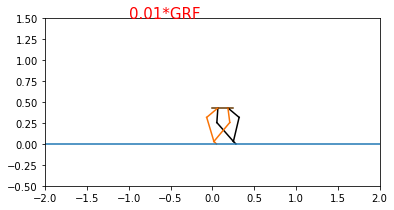

In [23]:
hide_sloution('Plot Solution')

#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_boom = {}
    plot_boom_COM = {}
    plot_UR = {}
    plot_LR = {}
    plot_UL = {}
    plot_LL = {}
    plot_foot = {}
    abs_angles = {}
    bod_angle = 0
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - m.y_bodyOffset.value - 0.5*m.lengths['body']*sin(bod_angle)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value - m.y_bodyOffset.value + 0.5*m.lengths['body']*sin(bod_angle)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:brown')
    
#     # plot boom
#     plot_boom.update({('x_back'): 0.0})
#     plot_boom.update({('y_back'): m.y_bodyOffset.value})
#     plot_boom.update({('x_front'):m.q[i,'x_body'].value })
#     plot_boom.update({('y_front'):m.q[i,'y_body'].value })  
#     ax.plot([plot_boom['x_back'],plot_boom['x_front']],[plot_boom['y_back'],plot_boom['y_front']],color='xkcd:black')

#     # plot boom COM
#     plot_boom_COM.update({('x'): (m.cg.value/m.lx_boom.value)*m.q[i,'x_body'].value})
#     plot_boom_COM.update({('y'): (m.cg.value/m.ly_boom.value)*m.q[i,'y_body'].value})
#     ax.plot([plot_boom_COM['x']],[plot_boom_COM['y']],color='xkcd:purple',marker="o")

    for leg in legs:
        if leg == 'A':
            link_colour = ['black','red']
        else:
            link_colour = ['orange','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): bod_angle + m.q[i,'theta_UR'+leg].value})
        plot_UR.update({('top','X',leg): m.q[i,'x_body'].value + m.BLD.value*cos(bod_angle)})
        plot_UR.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value + m.BLD.value*sin(bod_angle)})
        plot_UR.update({('bot','X',leg): plot_UR['top','X',leg] - m.lengths['UR'+leg]*cos(abs_angles['RU',leg])})
        plot_UR.update({('bot','Y',leg): plot_UR['top','Y',leg] - m.lengths['UR'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_UR['top','X',leg],plot_UR['bot','X',leg]],[plot_UR['top','Y',leg],plot_UR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_LR'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_LR.update({('top','X',leg): plot_UR['bot','X',leg]})
        plot_LR.update({('top','Y',leg): plot_UR['bot','Y',leg]})
        plot_LR.update({('bot','X',leg): plot_UR['bot','X',leg] - m.lengths['LR'+leg]*cos(abs_angles['RL',leg])})
        plot_LR.update({('bot','Y',leg): plot_UR['bot','Y',leg] - m.lengths['LR'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_LR['top','X',leg],plot_LR['bot','X',leg]],[plot_LR['top','Y',leg],plot_LR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot foot
        plot_foot.update({('top','X',leg): plot_LR['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_LR['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_LR['bot','X',leg] + m.foot_length.value*cos(m.foot_angle.value - (np.pi)/2)})
        plot_foot.update({('bot','Y',leg): plot_LR['bot','Y',leg] - m.foot_length.value*sin(m.foot_angle.value - (np.pi)/2)})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): bod_angle + m.q[i,'theta_UL'+leg].value})
        plot_UL.update({('top','X',leg): m.q[i,'x_body'].value - m.BLD.value*cos(bod_angle)})
        plot_UL.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value - m.BLD.value*sin(bod_angle)})
        plot_UL.update({('bot','X',leg): plot_UL['top','X',leg] - m.lengths['UL'+leg]*cos(abs_angles['LU',leg])})
        plot_UL.update({('bot','Y',leg): plot_UL['top','Y',leg]- m.lengths['UL'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_UL['top','X',leg],plot_UL['bot','X',leg]],[plot_UL['top','Y',leg],plot_UL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_LL'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_LL.update({('top','X',leg): plot_UL['bot','X',leg]})
        plot_LL.update({('top','Y',leg): plot_UL['bot','Y',leg]})
        plot_LL.update({('bot','X',leg): plot_UL['bot','X',leg] - m.lengths['LL'+leg]*cos(abs_angles['LL',leg])})
        plot_LL.update({('bot','Y',leg): plot_UL['bot','Y',leg] - m.lengths['LL'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_LL['top','X',leg],plot_LL['bot','X',leg]],[plot_LL['top','Y',leg],plot_LL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        ax.arrow(plot_LL['bot','X','A'], plot_LL['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
#     if m.GRF_x[i,'-ve','B'].value > 0.0:
#         #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#         ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_x[i,'-ve','B'].value,color='xkcd:{0}'.format('blue'),head_width = 0.1)
    
    
    #ax.legend(["GRF*0.01"], frameon=True)
    ax.text(x_low_lim, y_high_lim, '0.01*GRF', color = 'red',fontsize = 15)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [24]:
fileName = test+'_'+str(mu_value)+'_'+str(N)
f = r"{0}_biped.mp4".format(fileName) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 

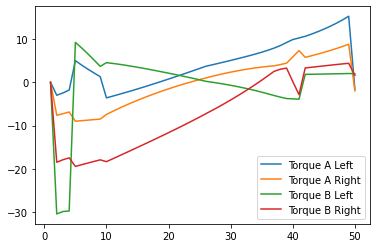

In [31]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.tau_torque[n,'left','A'].value)
    RightA.append(m.tau_torque[n,'right','A'].value)
    LeftB.append(m.tau_torque[n,'left','B'].value)
    RightB.append(m.tau_torque[n,'right','B'].value)
    
line1 = plt.plot(x,LeftA,label = 'Torque A Left')
line2 = plt.plot(x,LeftB,label = 'Torque A Right')
line3 = plt.plot(x,RightA,label = 'Torque B Left')
line4 = plt.plot(x,RightB,label = 'Torque B Right')
plt.legend()

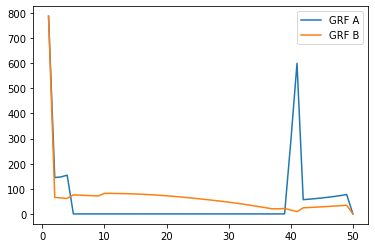

In [26]:
x = np.arange(1,N+1,1)
GRF_yA = []
GRF_yB = []


for n in range(1,N+1):
    GRF_yA.append(m.GRF_y[n,'A'].value)
    GRF_yB.append(m.GRF_y[n,'B'].value)
    
line1 = plt.plot(x,GRF_yA,label = 'GRF A')
line2 = plt.plot(x,GRF_yB,label = 'GRF B')

plt.legend()

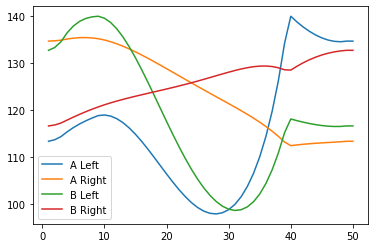

In [27]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.knee_angle[n,'left','A'].value*180/np.pi)
    RightA.append(m.knee_angle[n,'right','A'].value*180/np.pi)
    LeftB.append(m.knee_angle[n,'left','B'].value*180/np.pi)
    RightB.append(m.knee_angle[n,'right','B'].value*180/np.pi)
    
line1 = plt.plot(x,LeftA,label = 'A Left')
line2 = plt.plot(x,LeftB,label = 'A Right')
line3 = plt.plot(x,RightA,label = 'B Left')
line4 = plt.plot(x,RightB,label = 'B Right')
plt.legend()

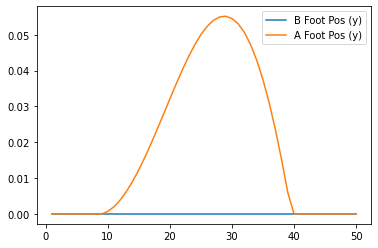

In [28]:
bGRFy = []
bFootPos = []
aGRFy = []
aFootPos = []
footScale = 1

for n in range(1,N+1):
    bGRFy.append(m.GRF_y[n,'B'].value)
    bFootPos.append(m.foot_position[n,'Y','B'].value*footScale)
    aGRFy.append(m.GRF_y[n,'A'].value)
    aFootPos.append(m.foot_position[n,'Y','A'].value*footScale)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootPos,label = 'B Foot Pos (y)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootPos,label = 'A Foot Pos (y)')
plt.legend()

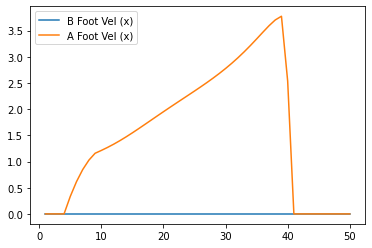

In [29]:
bFootVel = []
aFootVel = []

for n in range(1,N+1):
    bFootVel.append( m.foot_velocity[n,'X','+ve','B'].value-m.foot_velocity[n,'X','-ve','B'].value)
    aFootVel.append(m.foot_velocity[n,'X','+ve','A'].value-m.foot_velocity[n,'X','-ve','A'].value)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootVel,label = 'B Foot Vel (x)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootVel,label = 'A Foot Vel (x)')
plt.legend()

loop =  0
loop =  1
loop =  2
loop =  3
loop =  4


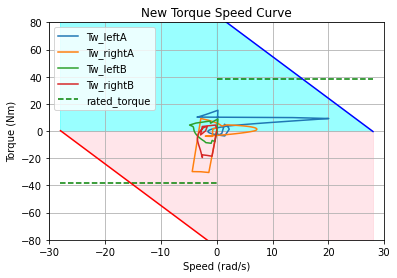

In [50]:
saveFile = True
loops = 5

if saveFile == True:
    fileName = test+'_'+str(N)
    f = r"{0}_biped.mp4".format(fileName) 
    writervideo = ani.FFMpegWriter(fps=20) 
    animate.save(f, writer=writervideo) 

    nodes = []

    xbody = []
    ybody = []
    thULA = []
    thURA = []
    thLLA = []
    thLRA = []
    thULB = []
    thURB = []
    thLLB = []
    thLRB = []



    dxbody = []
    dybody = []
    dthULA = []
    dthURA = []
    dthLLA = []
    dthLRA = []
    dthULB = []
    dthURB = []
    dthLLB = []
    dthLRB = []

    ddxbody = []
    ddybody = []
    ddthULA = []
    ddthURA = []
    ddthLLA = []
    ddthLRA = []
    ddthULB = []
    ddthURB = []
    ddthLLB = []
    ddthLRB = []

    Torque_leftA = []
    Torque_rightA = []
    Torque_leftB = []
    Torque_rightB = []

    GRF_y_A = []
    GRF_y_B = []
    foot_position_Y_A = []
    foot_position_Y_B = []

    angular_speed_leftA = []
    angular_speed_rightA = []
    angular_speed_leftB = []
    angular_speed_rightB = []



    for n in range(1,N+1):

        xbody.append(m.q[n,'x_body'].value)
        ybody.append(m.q[n,'y_body'].value)
        thULA.append(m.q[n,'theta_ULA'].value) 
        thURA.append(m.q[n,'theta_URA'].value) 
        thLLA.append(m.q[n,'theta_LLA'].value) 
        thLRA.append(m.q[n,'theta_LRA'].value) 
        thULB.append(m.q[n,'theta_ULB'].value) 
        thURB.append(m.q[n,'theta_URB'].value) 
        thLLB.append(m.q[n,'theta_LLB'].value) 
        thLRB.append(m.q[n,'theta_LRB'].value) 

        dxbody.append(m.dq[n,'x_body'].value)
        dybody.append(m.dq[n,'y_body'].value)
        dthULA.append(m.dq[n,'theta_ULA'].value) 
        dthURA.append(m.dq[n,'theta_URA'].value) 
        dthLLA.append(m.dq[n,'theta_LLA'].value) 
        dthLRA.append(m.dq[n,'theta_LRA'].value) 
        dthULB.append(m.dq[n,'theta_ULB'].value) 
        dthURB.append(m.dq[n,'theta_URB'].value) 
        dthLLB.append(m.dq[n,'theta_LLB'].value) 
        dthLRB.append(m.dq[n,'theta_LRB'].value) 

        ddxbody.append(m.ddq[n,'x_body'].value)
        ddybody.append(m.ddq[n,'y_body'].value)
        ddthULA.append(m.ddq[n,'theta_ULA'].value) 
        ddthURA.append(m.ddq[n,'theta_URA'].value) 
        ddthLLA.append(m.ddq[n,'theta_LLA'].value) 
        ddthLRA.append(m.ddq[n,'theta_LRA'].value) 
        ddthULB.append(m.ddq[n,'theta_ULB'].value) 
        ddthURB.append(m.ddq[n,'theta_URB'].value) 
        ddthLLB.append(m.ddq[n,'theta_LLB'].value) 
        ddthLRB.append(m.ddq[n,'theta_LRB'].value) 

        Torque_leftA.append(m.tau_torque[n,'left','A'].value)
        Torque_rightA.append(m.tau_torque[n,'right','A'].value)
        Torque_leftB.append(m.tau_torque[n,'left','B'].value)
        Torque_rightB.append(m.tau_torque[n,'right','B'].value)

        GRF_y_A.append(m.GRF_y[n,'A'].value)
        GRF_y_B.append(m.GRF_y[n,'B'].value)

        foot_position_Y_A.append(m.foot_position[n,'Y','A'].value)
        foot_position_Y_B.append(m.foot_position[n,'Y','B'].value)

        angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
        angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
        angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
        angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)

        nodes.append(n)

        pass



    ''' Store first values in csv file '''
    import csv
    # csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
    csv_file_name = "Test_{0}_N_{1}".format(test,N)

    heading0 = ['node']
    heading1 = ['x_body','y_body','theta_ULA','theta_URA','theta_LLA','theta_LRA','theta_ULB','theta_URB','theta_LLB','theta_LRB']
    heading2 = ['dx_body','dy_body','dtheta_ULA','dtheta_URA','dtheta_LLA','dtheta_LRA','dtheta_ULB','dtheta_URB','dtheta_LLB','dtheta_LRB']
    heading3 = ['ddx_body','ddy_body','ddtheta_ULA','ddtheta_URA','ddtheta_LLA','ddtheta_LRA','ddtheta_ULB','ddtheta_URB','ddtheta_LLB','ddtheta_LRB']
    heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
    heading5 = ['foot_position_Y_A','foot_position_Y_B']
    heading = heading0 + heading1 + heading2 + heading3 + heading4 + heading5

    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)

        writer.writerow(heading)
        
        for repeat in range(0,loops): 
            print('loop = ',repeat)
            for n in range(2*N*repeat,N*(2*repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-1
                # 0 - 50 cycle
                data1 = [xbody[n],ybody[n],thULA[n],thURA[n],thLLA[n],thLRA[n],thULB[n],thURB[n],thLLB[n],thLRB[n]]
                data2 = [dxbody[n],dybody[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n]]
                data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
                data5 = [foot_position_Y_A[n],foot_position_Y_B[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)

            for n in range(N*(2*repeat+1),2*N*(repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-N-1
                # 50 - 100 cycle
                data1 = [xbody[n],ybody[n],thULB[n],thURB[n],thLLB[n],thLRB[n],thULA[n],thURA[n],thLLA[n],thLRA[n]]
                data2 = [dxbody[n],dybody[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n]]
                data4 = [Torque_leftB[n],Torque_rightB[n],Torque_leftA[n],Torque_rightA[n],GRF_y_B[n],GRF_y_A[n]]
                data5 = [foot_position_Y_B[n],foot_position_Y_A[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)
                
            
    
    plt.figure()
    plt.plot(angular_speed_leftA,Torque_leftA)
    plt.plot(angular_speed_rightA,Torque_rightA)
    plt.plot(angular_speed_leftB,Torque_leftB)
    plt.plot(angular_speed_rightB,Torque_rightB)

    plt.grid()
    plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
    plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

    plt.plot(x_p, y_p,'b')
    plt.plot(x_n, stall_torque_p,'b')

    plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
    plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

    plt.plot(x_n, y_n,'r')
    plt.plot(x_p, stall_torque_n,'r')

    plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
    plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

    plt.axis((-30,30,-80,80))
    plt.title('New Torque Speed Curve')
    plt.xlabel('Speed (rad/s)')
    plt.ylabel('Torque (Nm)')
    plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
else:
    pass

In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[1,'y_body'].value,
             'dybod' : m.dq[1,'y_body'].value,
        'dxbod' : m.dq[1,'x_body'].value,
             
        'thULA' : m.q[1,'theta_ULA'].value,
        'thLLA' : m.q[1,'theta_LLA'].value,
        'thURA' : m.q[1,'theta_URA'].value,
        'thLRA' : m.q[1,'theta_LRA'].value,

        'thULB' : m.q[1,'theta_ULB'].value,
        'thLLB' : m.q[1,'theta_LLB'].value,
        'thURB' : m.q[1,'theta_URB'].value,
        'thLRB' : m.q[1,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[1,'theta_ULA'].value,
        'dthLLA' : m.dq[1,'theta_LLA'].value,
        'dthURA' : m.dq[1,'theta_URA'].value,
        'dthLRA' : m.dq[1,'theta_LRA'].value,

        'dthULB' : m.dq[1,'theta_ULB'].value,
        'dthLLB' : m.dq[1,'theta_LLB'].value,
        'dthURB' : m.dq[1,'theta_URB'].value,
        'dthLRB' : m.dq[1,'theta_LRB'].value}
    with open('periodic_walk_N1_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[N,'y_body'].value,
             'dybod' : m.dq[N,'y_body'].value,
        'dxbod' : m.dq[N,'x_body'].value,
             
        'thULA' : m.q[N,'theta_ULA'].value,
        'thLLA' : m.q[N,'theta_LLA'].value,
        'thURA' : m.q[N,'theta_URA'].value,
        'thLRA' : m.q[N,'theta_LRA'].value,

        'thULB' : m.q[N,'theta_ULB'].value,
        'thLLB' : m.q[N,'theta_LLB'].value,
        'thURB' : m.q[N,'theta_URB'].value,
        'thLRB' : m.q[N,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_finalN_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)